# **Sentiments of Product Reviews**

**Team members:**\
Bryan Noel Salindeho\
Edmerson Low Soon Xiang\
Fiona Valentin Wironoto Susilo


## Step 1: Import libraries

In [ ]:

import pandas as pd
import os
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Step 2: Mount Data from Google Drive

Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("My Drive contents:")
!ls "/content/drive/My Drive/AI DM PROJECT"

Mounted at /content/drive
My Drive contents:
'Copy of Final Model IE4483'   Glove	     'IE4483 Mini Project.gdoc'   test.json
'Final Model IE4483'	       IE4483.ipynb  'IE4483 Report.gdoc'	  train.json


Find Train Data

File founded
Data shape: (7401, 2)

First few rows:
                                             reviews  sentiments
0  I bought this belt for my daughter in-law for ...           1
1  The size was perfect and so was the color.  It...           1


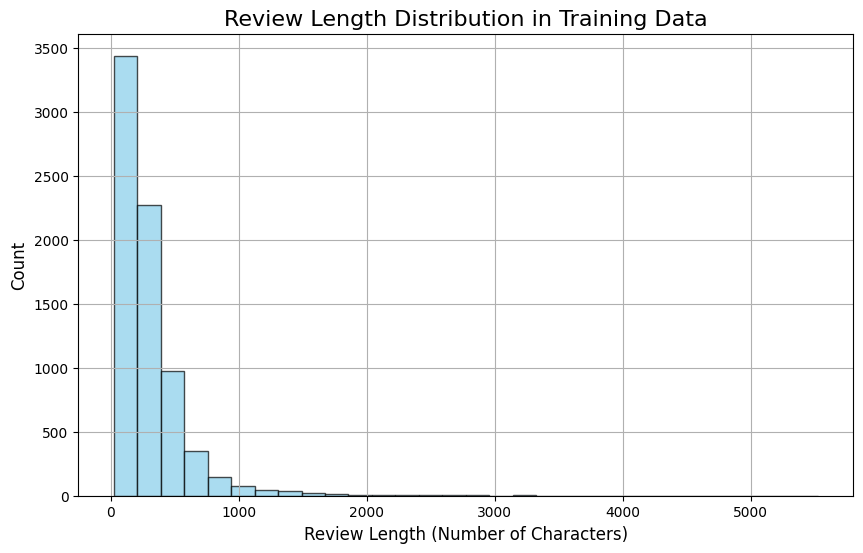


Review Length Statistics:
count    7401.000000
mean      300.926632
std       285.235376
min        24.000000
25%       133.000000
50%       223.000000
75%       373.000000
max      5525.000000
Name: review_length, dtype: float64


<ipython-input-3-fc47d9e74f5a>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=train_df, x='sentiments', palette='Blues', edgecolor='black')


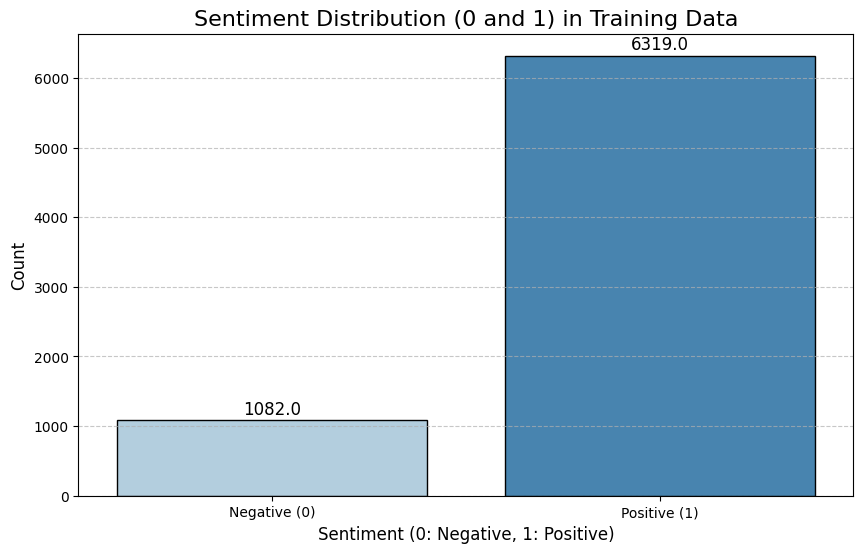


Sentiment Counts:
sentiments
1    6319
0    1082
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import TruncatedSVD  # Commenting out SVD import
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin

train_path = '/content/drive/My Drive/AI DM PROJECT/train.json'
if os.path.exists(train_path):
  print("File founded")
  df = pd.read_json(train_path)
  print(f"Data shape: {df.shape}")
  print("\nFirst few rows:")
  print(df.head(2))
  train_df = df
else:
  print("File not founded")

if 'reviews' in train_df.columns:
    # Calculate the length of each review (number of characters)
    train_df['review_length'] = train_df['reviews'].apply(len)

    # Plot the histogram of review lengths with count on the y-axis
    plt.figure(figsize=(10, 6))
    plt.hist(train_df['review_length'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

    # Customize the plot
    plt.title('Review Length Distribution in Training Data', fontsize=16)
    plt.xlabel('Review Length (Number of Characters)', fontsize=12)
    plt.ylabel('Count', fontsize=12)  # Set y-axis label to 'Count'
    plt.grid(True)
    plt.show()

    # Print summary statistics of review lengths
    print("\nReview Length Statistics:")
    print(train_df['review_length'].describe())
else:
    print("The 'reviews' column is not present in the data.")

if 'sentiments' in train_df.columns:
    # Create a countplot for the sentiment distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=train_df, x='sentiments', palette='Blues', edgecolor='black')

    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=12, color='black',
                    xytext=(0, 8), textcoords='offset points')

    # Customize the plot
    plt.title('Sentiment Distribution (0 and 1) in Training Data', fontsize=16)
    plt.xlabel('Sentiment (0: Negative, 1: Positive)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
    plt.show()

    # Print the count of each sentiment
    sentiment_counts = train_df['sentiments'].value_counts()
    print("\nSentiment Counts:")
    print(sentiment_counts)
else:
    print("The 'sentiments' column is not present in the data.")

## Step 3: Clean Data


In [ ]:
if train_df is not None:
    print("Data Info:")
    print(train_df.info())

    print("\nMissing Values:")
    print(train_df.isnull().sum())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7401 entries, 0 to 7400
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   reviews        7401 non-null   object
 1   sentiments     7401 non-null   int64 
 2   review_length  7401 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 173.6+ KB
None

Missing Values:
reviews          0
sentiments       0
review_length    0
dtype: int64


In [ ]:
class TextCleaner:
    def __init__(self):
        # Initialize lemmatizer
        self.lemmatizer = WordNetLemmatizer()

        # Custom stopwords: keep important sentiment and product-related words
        self.stop_words = set(stopwords.words('english')) - {
            'not', 'no', 'nor',  # Negations
            'very', 'too',       # Intensity
            'but', 'however',    # Contrasts
            'above', 'below',    # Spatial
            'few', 'more',       # Quantity
            'most', 'least',     # Extremes
            'should', 'would'    # Modals
        }

        # Enhanced contractions mapping
        self.contractions = {
            "ain't": "is not",
            "aren't": "are not",
            "can't": "cannot",
            "couldn't": "could not",
            "didn't": "did not",
            "doesn't": "does not",
            "don't": "do not",
            "hadn't": "had not",
            "hasn't": "has not",
            "haven't": "have not",
            "he'd": "he would",
            "he'll": "he will",
            "he's": "he is",
            "i'd": "i would",
            "i'll": "i will",
            "i'm": "i am",
            "i've": "i have",
            "isn't": "is not",
            "it's": "it is",
            "let's": "let us",
            "mightn't": "might not",
            "mustn't": "must not",
            "shan't": "shall not",
            "she'd": "she would",
            "she'll": "she will",
            "she's": "she is",
            "shouldn't": "should not",
            "that's": "that is",
            "there's": "there is",
            "they'd": "they would",
            "they'll": "they will",
            "they're": "they are",
            "they've": "they have",
            "wasn't": "was not",
            "we'd": "we would",
            "we're": "we are",
            "weren't": "were not",
            "we've": "we have",
            "what'll": "what will",
            "what're": "what are",
            "what's": "what is",
            "what've": "what have",
            "where's": "where is",
            "who'd": "who would",
            "who'll": "who will",
            "who're": "who are",
            "who's": "who is",
            "who've": "who have",
            "won't": "will not",
            "wouldn't": "would not",
            "you'd": "you would",
            "you'll": "you will",
            "you're": "you are",
            "you've": "you have"
        }

        # Product-specific terms to preserve
        self.preserve_terms = {
            'x', 'xl', 'xxl', 'xs', 's', 'm', 'l',  # Sizes
            '3d', '2d',                              # Product features
            'uk', 'us', 'eu',                        # Regions
            'mm', 'cm', 'in',                        # Measurements
            'v1', 'v2', 'v3',                        # Version numbers
        }

    def expand_contractions(self, text):
        """Expand contractions in text."""
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)
        return text

    def clean_text(self, text, lemmatize=True):
        """
        Clean text with options for different levels of processing.

        Args:
            text (str): Input text
            lemmatize (bool): Whether to apply lemmatization

        Returns:
            str: Cleaned text
        """
        if not isinstance(text, str):
            return ""

        # Convert to lowercase
        text = text.lower()

        # Expand contractions
        text = self.expand_contractions(text)

        # Replace product-specific patterns
        text = re.sub(r'(\d+)x(\d+)', r'\1 by \2', text)  # Dimensions
        text = re.sub(r'(\d+)ml', r'\1 ml', text)         # Measurements
        text = re.sub(r'(\d+)cm', r'\1 cm', text)
        text = re.sub(r'(\d+)mm', r'\1 mm', text)

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Replace multiple spaces with single space
        text = re.sub(r'\s+', ' ', text)

        # Replace newlines with a single space
        text = re.sub(r'\n+', ' ', text)

        # Remove punctuation except hyphens in product names
        text = text.translate(str.maketrans('', '', string.punctuation.replace('-', '')))

        # Tokenize
        words = word_tokenize(text)

        # Process tokens
        cleaned_words = []
        for word in words:
            # Keep preserved terms
            if word.lower() in self.preserve_terms:
                cleaned_words.append(word)
                continue

            # Remove stopwords
            if word not in self.stop_words:
                # Lemmatize if requested
                if lemmatize:
                    word = self.lemmatizer.lemmatize(word)
                cleaned_words.append(word)

        # Rejoin words
        text = ' '.join(cleaned_words)

        # Final cleanup of extra spaces
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def process_reviews(self, reviews, show_samples=5):
        """Process a series of reviews and optionally show samples."""
        cleaned_reviews = []

        for i, review in enumerate(reviews):
            cleaned = self.clean_text(review)
            cleaned_reviews.append(cleaned)

            if show_samples and i < show_samples:
                print(f"\nOriginal: {review[:100]}...")
                print(f"Cleaned:  {cleaned[:100]}...")

        return cleaned_reviews

cleaner = TextCleaner()

if 'train_df' in locals():
    print("\nProcessing training data:")
    train_df['cleaned_reviews'] = cleaner.process_reviews(train_df['reviews'])



Processing training data:

Original: I bought this belt for my daughter in-law for Christmas and she loved it...
Cleaned:  bought belt daughter in-law christmas loved...

Original: The size was perfect and so was the color.  It looked just like it did on the web page:)...
Cleaned:  size perfect color looked like web page...

Original: Fits and feels good, esp. for doing a swim race.  Highly recommend this.  

Be careful when wearing ...
Cleaned:  fit feel good esp swim race highly recommend careful wearing board short velcro zipper strap materia...

Original: These socks are absolutely the best. I take pilates classes and if it is hot your feet can slip off ...
Cleaned:  sock absolutely best take pilate class hot foot slip mat not good in middle side plankanyway sock ke...

Original: Thank you so much for the speedy delivery they came in time for the rehearsal dinner.  I loved the r...
Cleaned:  thank much speedy delivery came in time rehearsal dinner loved red silk neck tie really ma

## Step 4: Apply Vectorizer

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from nltk.tokenize import word_tokenize
# import re

# class GloVeTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, glove_file_path, size=100):
#         self.glove_model = self._load_glove_model(glove_file_path)
#         self.size = size

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([self._get_average_glove_vector(doc) for doc in X])

#     def _load_glove_model(self, glove_file_path):
#         glove_model = {}
#         with open(glove_file_path, 'r', encoding='utf-8') as f:
#             for line in f:
#                 split_line = line.split()
#                 word = split_line[0]
#                 vector = np.array([float(val) for val in split_line[1:]])
#                 glove_model[word] = vector
#         return glove_model

#     def _get_average_glove_vector(self, doc):
#         words = doc.split()
#         word_vectors = [self.glove_model[word] for word in words if word in self.glove_model]
#         if len(word_vectors) == 0:
#             return np.zeros(self.size)
#         return np.mean(word_vectors, axis=0)

# class AdvancedVectorizer:
#     def __init__(self, glove_file_path, max_features=5000, ngram_range=(1, 3),
#                  max_df=0.85, min_df=2, custom_stop_words=None):
#         self.glove_file_path = glove_file_path
#         self.max_features = max_features
#         self.ngram_range = ngram_range
#         self.max_df = max_df
#         self.min_df = min_df
#         self.custom_stop_words = custom_stop_words or set()
#         self.fitted = False
#         self.glove_transformer = GloVeTransformer(glove_file_path=self.glove_file_path, size=100)
#         self.pipeline = self._create_pipeline()

#     def _create_pipeline(self):
#         return Pipeline([
#             ('glove', self.glove_transformer),
#         ])

#     def fit(self, texts):
#         self.pipeline.fit(texts)
#         self.fitted = True
#         return self

#     def transform(self, texts):
#         if not self.fitted:
#             raise ValueError("The vectorizer pipeline is not fitted yet. Call 'fit' first.")
#         return self.pipeline.transform(texts)

#     def fit_transform(self, texts):
#         return self.pipeline.fit_transform(texts)

#     def visualize_top_features(self, n_features=20):
#         # Implement visualization logic here based on your needs
#         pass

# def main():
#     # Create sample training data
#     train_df = pd.DataFrame({
#         'cleaned_reviews': [
#             "this product is excellent quality",
#             "poor service and terrible experience",
#             "great product highly recommend",
#             "waste of money do not buy",
#             "amazing customer service",
#             "defective product disappointed"
#         ],
#         'sentiments': [1, 0, 1, 0, 1, 0]  # 1 for positive, 0 for negative
#     })

#     # Set up GloVe path
#     glove_file_path = '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt'

#     # Initialize vectorizer
#     vectorizer = AdvancedVectorizer(
#         glove_file_path=glove_file_path,
#         max_features=5000,
#         ngram_range=(1, 2),
#         max_df=0.7,
#         min_df=5,
#         custom_stop_words={'custom', 'stopwords', 'here', 'thing', 'stuff', 'item', 'ones'}
#     )

#     # Transform the data
#     transformed_data = vectorizer.fit_transform(train_df['cleaned_reviews'])

#     # Split the data
#     X_train, X_val, y_train, y_val = train_test_split(
#         transformed_data,
#         train_df['sentiments'],
#         test_size=0.2,
#         random_state=42
#     )

#     return X_train, X_val, y_train, y_val, vectorizer

# if __name__ == "__main__":
#     try:
#         X_train, X_val, y_train, y_val, vectorizer = main()
#         print("Data transformation and split successful!")
#         print(f"Training set shape: {X_train.shape}")
#         print(f"Validation set shape: {X_val.shape}")
#     except Exception as e:
#         print(f"An error occurred: {str(e)}")

# # Cell 1: Imports for GloVe and Vectorizer
# import numpy as np
# import pandas as pd
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from nltk.tokenize import word_tokenize
# import re

# # Cell 2: GloVe Transformer
# class GloVeTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, glove_file_path, size=100):
#         self.glove_model = self._load_glove_model(glove_file_path)
#         self.size = size

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return np.array([self._get_average_glove_vector(doc) for doc in X])

#     def _load_glove_model(self, glove_file_path):
#         glove_model = {}
#         with open(glove_file_path, 'r', encoding='utf-8') as f:
#             for line in f:
#                 split_line = line.split()
#                 word = split_line[0]
#                 vector = np.array([float(val) for val in split_line[1:]])
#                 glove_model[word] = vector
#         return glove_model

#     def _get_average_glove_vector(self, doc):
#         words = doc.split()
#         word_vectors = [self.glove_model[word] for word in words if word in self.glove_model]
#         if len(word_vectors) == 0:
#             return np.zeros(self.size)
#         return np.mean(word_vectors, axis=0)

# # Cell 3: Advanced Vectorizer
# class AdvancedVectorizer:
#     def __init__(self, glove_file_path, max_features=5000, ngram_range=(1, 3),
#                  max_df=0.85, min_df=2, custom_stop_words=None):
#         self.glove_file_path = glove_file_path
#         self.max_features = max_features
#         self.ngram_range = ngram_range
#         self.max_df = max_df
    #     self.min_df = min_df
    #     self.custom_stop_words = custom_stop_words or set()
    #     self.fitted = False
    #     self.glove_transformer = GloVeTransformer(glove_file_path=self.glove_file_path, size=100)
    #     self.pipeline = self._create_pipeline()

    # def _create_pipeline(self):
    #     return Pipeline([
    #         ('glove', self.glove_transformer),
    #     ])

    # def fit(self, texts):
    #     self.pipeline.fit(texts)
    #     self.fitted = True
    #     return self

    # def transform(self, texts):
    #     if not self.fitted:
    #         raise ValueError("The vectorizer pipeline is not fitted yet. Call 'fit' first.")
    #     return self.pipeline.transform(texts)

    # def fit_transform(self, texts):
    #     return self.pipeline.fit_transform(texts)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
import re

class GloVeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, glove_file_path, size=100):
        self.glove_file_path = glove_file_path
        self.size = size
        self.glove_model = None
        self._load_glove_model()

    def _load_glove_model(self):
        print("Loading GloVe model...")
        self.glove_model = {}
        with open(self.glove_file_path, 'r', encoding='utf-8') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                vector = np.array([float(val) for val in split_line[1:]])
                self.glove_model[word] = vector
        print(f"Loaded {len(self.glove_model)} word vectors")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.glove_model is None:
            raise ValueError("GloVe model not loaded. Initialize the transformer first.")
        return np.array([self._get_average_glove_vector(doc) for doc in X])

    def _get_average_glove_vector(self, doc):
        words = doc.lower().split()
        word_vectors = [self.glove_model[word] for word in words if word in self.glove_model]
        if len(word_vectors) == 0:
            return np.zeros(self.size)
        return np.mean(word_vectors, axis=0)

class AdvancedVectorizer(BaseVectorizer):
    def __init__(self, glove_file_path, max_features=5000, ngram_range=(1, 3),
                 max_df=0.85, min_df=2, custom_stop_words=None):
        super().__init__()
        self.glove_file_path = glove_file_path
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.max_df = max_df
        self.min_df = min_df
        self.custom_stop_words = custom_stop_words or set()
        self.glove_transformer = GloVeTransformer(glove_file_path=self.glove_file_path)
        self.pipeline = self._create_pipeline()

    def _create_pipeline(self):
        return Pipeline([
            ('glove', self.glove_transformer),
        ])

    def fit(self, texts):
        """Fit the vectorizer on the training texts."""
        self.pipeline.fit(texts)
        self.fitted = True
        return self

    def transform(self, texts):
        """Transform texts into feature vectors."""
        self.check_fitted()
        return self.pipeline.transform(texts)

    def fit_transform(self, texts):
        """Fit the vectorizer and transform the texts."""
        return self.fit(texts).transform(texts)

# Update the get_vectorizer function
def get_vectorizer(vec_config):
    method = vec_config['method']
    if method == 'glove':
        return AdvancedVectorizer(
            glove_file_path=vec_config['glove_path'],
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2)),
            max_df=vec_config.get('max_df', 0.85),
            min_df=vec_config.get('min_df', 2)
        )
    elif method == 'tfidf':
        return TfidfTextVectorizer(
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2)),
            max_df=vec_config.get('max_df', 0.85),
            min_df=vec_config.get('min_df', 2)
        )
    elif method == 'count':
        return CountTextVectorizer(
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2)),
            max_df=vec_config.get('max_df', 0.85),
            min_df=vec_config.get('min_df', 2)
        )
    elif method == 'word2vec':
        return Word2VecTextVectorizer(
            vector_size=vec_config.get('vector_size', 100),
            window=vec_config.get('window', 5),
            min_count=vec_config.get('min_count', 1)
        )
    elif method == 'combined':
        return CombinedVectorizer(
            glove_path=vec_config['glove_path'],
            tfidf_max_features=vec_config.get('max_features', 5000)
        )
    else:
        raise ValueError(f"Unknown vectorizer method: {method}")


NameError: name 'BaseVectorizer' is not defined

## Step 5: Implementing Feedforward Neural Network Classifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import wordcloud
from collections import Counter
import time


class SentimentDataset(Dataset):
    def __init__(self, features, labels=None):
        # features_dense = features.toarray()
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels.values) if labels is not None else None  # Convert Series to NumPy array

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        if self.labels is not None:
            return self.features[idx], self.labels[idx]
        else:
            return self.features[idx]

class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128], dropout_rate=0.3):
        super(SentimentClassifier, self).__init__()

        layers = []
        prev_dim = input_dim

        # Build hidden layers
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = dim

        # Output layer
        layers.append(nn.Linear(prev_dim, 2))  # 2 classes: positive and negative

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class SentimentAnalyzer:
    def __init__(self,
                 hidden_dims=[256, 128],
                 dropout_rate=0.3,
                 learning_rate=0.001,
                 batch_size=32,
                 num_epochs=10,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.device = device
        self.model = None
        self.history = {'train_loss': [], 'val_loss': [],
                       'train_acc': [], 'val_acc': []}

    def create_data_loaders(self, X_train, y_train, X_val=None, y_val=None):
        """Create training and validation data loaders"""
        train_dataset = SentimentDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        val_loader = None
        if X_val is not None and y_val is not None:
            val_dataset = SentimentDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=self.batch_size)

        return train_loader, val_loader

    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Train the sentiment classifier"""
        # Initialize model
        input_dim = X_train.shape[1]
        self.model = SentimentClassifier(input_dim, self.hidden_dims, self.dropout_rate).to(self.device)

        # Create data loaders
        train_loader, val_loader = self.create_data_loaders(X_train, y_train, X_val, y_val)

        # Initialize optimizer and loss function
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        for epoch in range(self.num_epochs):
            # Training phase
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            for batch_features, batch_labels in train_loader:
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += batch_labels.size(0)
                train_correct += (predicted == batch_labels).sum().item()

            # Calculate training metrics
            train_loss = train_loss / len(train_loader)
            train_acc = 100 * train_correct / train_total

            # Validation phase
            if val_loader is not None:
                val_loss, val_acc = self.evaluate(val_loader, criterion)
                print(f'Epoch [{epoch+1}/{self.num_epochs}], '
                      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                      f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
            else:
                print(f'Epoch [{epoch+1}/{self.num_epochs}], '
                      f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')

            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)

    def evaluate(self, data_loader, criterion):
        """Evaluate the model on the given data loader"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for features, labels in data_loader:
                features = features.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(features)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return total_loss / len(data_loader), 100 * correct / total

    def predict(self, X):
        """Make predictions on new data"""
        self.model.eval()
        dataset = SentimentDataset(X)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        predictions = []
        all_probabilities = []  # To store probabilities

        with torch.no_grad():
            for features in data_loader:
                features = features.to(self.device)
                outputs = self.model(features)
                probabilities = torch.softmax(outputs, dim=1)  # Get probabilities
                _, predicted = torch.max(probabilities.data, 1)  # Get predicted class

                # Collect predicted classes and probabilities
                predictions.extend(predicted.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        return np.array(predictions), np.array(all_probabilities)  # Return both

    def plot_training_history(self):
        high_epoch = 0
        max_accuracy = 0
        index = 1
        """Plot training history"""
        plt.figure(figsize=(12, 4))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        if 'val_loss' in self.history and self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Val Loss')
        plt.title('Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.history['train_acc'], label='Train Acc')
        if 'val_acc' in self.history and self.history['val_acc']:
            plt.plot(self.history['val_acc'], label='Val Acc')
            for index, accuracy in enumerate(self.history['val_acc']):
              if accuracy > max_accuracy:
                  max_accuracy = accuracy
                  high_epoch = index + 1

        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        print("maximum accuracy: ", round(max_accuracy, 2), "%")
        print("high epoch: ", high_epoch)

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def plot_interactive_training_history(self):
        """Create an interactive training history plot using Plotly"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Loss Curves', 'Accuracy Curves',
                          'Loss Distribution', 'Accuracy Progression')
        )

        # Loss curves
        fig.add_trace(
            go.Scatter(y=self.history['train_loss'], name='Train Loss',
                      line=dict(color='blue', width=2)), row=1, col=1)
        if self.history['val_loss']:
            fig.add_trace(
                go.Scatter(y=self.history['val_loss'], name='Val Loss',
                          line=dict(color='red', width=2)), row=1, col=1)

        # Accuracy curves
        fig.add_trace(
            go.Scatter(y=self.history['train_acc'], name='Train Acc',
                      line=dict(color='green', width=2)), row=1, col=2)
        if self.history['val_acc']:
            fig.add_trace(
                go.Scatter(y=self.history['val_acc'], name='Val Acc',
                          line=dict(color='orange', width=2)), row=1, col=2)

        # Loss distribution
        fig.add_trace(
            go.Histogram(x=self.history['train_loss'], name='Train Loss Dist',
                        nbinsx=20, histnorm='probability'), row=2, col=1)

        # Accuracy progression
        epochs = list(range(1, len(self.history['train_acc']) + 1))
        fig.add_trace(
            go.Scatter(x=epochs, y=self.history['train_acc'],
                      mode='lines+markers',
                      name='Accuracy Progress'), row=2, col=2)

        fig.update_layout(height=800, width=1200, showlegend=True,
                         title_text="Detailed Training Analysis")
        fig.show()

    def plot_roc_and_pr_curves(self, X_val, y_val):
        """Plot ROC and PR curves using Plotly"""
        self.model.eval()
        with torch.no_grad():
            probs = torch.softmax(self.model(torch.FloatTensor(X_val).to(self.device)), dim=1)
            y_proba = probs.cpu().numpy()[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        roc_auc = auc(fpr, tpr)

        # Calculate PR curve
        precision, recall, _ = precision_recall_curve(y_val, y_proba)
        pr_auc = auc(recall, precision)

        # Create subplots
        fig = make_subplots(rows=1, cols=2,
                           subplot_titles=('ROC Curve', 'Precision-Recall Curve'))

        # ROC curve
        fig.add_trace(
            go.Scatter(x=fpr, y=tpr,
                      name=f'ROC (AUC = {roc_auc:.3f})',
                      line=dict(color='darkorange', width=2)),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=[0, 1], y=[0, 1],
                      name='Random',
                      line=dict(color='navy', dash='dash')),
            row=1, col=1
        )

        # PR curve
        fig.add_trace(
            go.Scatter(x=recall, y=precision,
                      name=f'PR (AUC = {pr_auc:.3f})',
                      line=dict(color='green', width=2)),
            row=1, col=2
        )

        fig.update_layout(height=500, width=1200,
                         title_text="Model Performance Curves")
        fig.show()

    def plot_prediction_confidence(self, X):
        """Plot prediction confidence distribution"""
        self.model.eval()
        with torch.no_grad():
            probs = torch.softmax(self.model(torch.FloatTensor(X).to(self.device)), dim=1)
            confidences = torch.max(probs, dim=1)[0].cpu().numpy()
            predictions = torch.argmax(probs, dim=1).cpu().numpy()

        fig = go.Figure()

        # Add confidence distribution for each class
        for class_idx in [0, 1]:
            mask = predictions == class_idx
            fig.add_trace(go.Histogram(
                x=confidences[mask],
                name=f'Class {class_idx}',
                opacity=0.7,
                nbinsx=30
            ))

        fig.update_layout(
            title="Prediction Confidence Distribution",
            xaxis_title="Confidence Score",
            yaxis_title="Count",
            barmode='overlay',
            height=500,
            width=800
        )
        fig.show()

    def analyze_misclassifications(self, X_val, y_val, texts=None):
        """Analyze misclassified examples"""
        predictions = self.predict(X_val)
        misclassified = predictions != y_val

        print(f"Total misclassified examples: {misclassified.sum()}")
        print(f"Misclassification rate: {misclassified.sum() / len(y_val):.2%}")

        if texts is not None:
            print("\nSample misclassified texts:")
            misclassified_indices = np.where(misclassified)[0]
            for idx in misclassified_indices[:5]:
                print(f"\nTrue label: {y_val[idx]}, Predicted: {predictions[idx]}")
                print(f"Text: {texts[idx][:200]}...")

    def plot_training_time_analysis(self):
        """Plot training time analysis"""
        if not hasattr(self, 'epoch_times'):
            print("No timing information available")
            return

        fig = go.Figure()

        # Add training time per epoch
        fig.add_trace(go.Scatter(
            x=list(range(1, len(self.epoch_times) + 1)),
            y=self.epoch_times,
            mode='lines+markers',
            name='Training Time'
        ))

        fig.update_layout(
            title="Training Time Analysis",
            xaxis_title="Epoch",
            yaxis_title="Time (seconds)",
            height=400,
            width=800
        )
        fig.show()

        print(f"Average time per epoch: {np.mean(self.epoch_times):.2f} seconds")

    def modified_train(self, X_train, y_train, X_val=None, y_val=None):
        """Modified training method with timing analysis"""
        self.epoch_times = []

        # Call original train method
        start_time = time.time()
        super().train(X_train, y_train, X_val, y_val)
        total_time = time.time() - start_time

        print(f"\nTraining completed in {total_time:.2f} seconds")
        self.plot_training_time_analysis()

# # Initialize and train the model
# analyzer = SentimentAnalyzer(
#     hidden_dims=[256, 128, 64],
#     dropout_rate=0.6,
#     learning_rate=0.0005,
#     batch_size=32,
#     num_epochs=10
# )

# # Train the model
# analyzer.train(X_train, y_train, X_val, y_val)

# analyzer.plot_training_history()
# y_pred = analyzer.predict(X_val)
# # analyzer.plot_confusion_matrix(y_val, y_pred)
# # analyzer.plot_interactive_training_history()
# # analyzer.plot_roc_and_pr_curves(X_val, y_val)
# # analyzer.plot_prediction_confidence(X_val)


In [ ]:
"""
1. BERT (Bidirectional Encoder Representations from Transformers):
- Pre-trained on massive text data
- Strong understanding of language context
- Bidirectional understanding of text
"""
from transformers import BertModel, BertTokenizer

class BERTClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(768, 2)  # 768 is BERT's hidden size

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(self.dropout(pooled_output))

"""
2. BiLSTM (Bidirectional Long Short-Term Memory):
- Processes text in both directions
- Good at capturing sequential patterns
- Can remember long-term dependencies
"""
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout_rate=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim*2, 2)  # *2 for bidirectional

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take the last output from both directions
        avg_pool = torch.mean(lstm_out, 1)
        output = self.classifier(self.dropout(avg_pool))
        return output

"""
3. Transformer:
- Based on self-attention mechanism
- Can process all words in parallel
- Good at capturing global dependencies
"""
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, nhead=8, num_layers=2, dropout_rate=0.3):
        super().__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=input_dim,
                nhead=nhead,
                dropout=dropout_rate
            ),
            num_layers=num_layers
        )
        self.classifier = nn.Linear(input_dim, 2)

    def forward(self, x):
        x = self.transformer_encoder(x)
        # Global average pooling
        x = torch.mean(x, dim=1)
        return self.classifier(x)

"""
4. TextCNN (Convolutional Neural Network for Text):
- Uses multiple filter sizes to capture n-grams
- Fast and effective
- Good at capturing local patterns
"""
class TextCNN(nn.Module):
    def __init__(self, input_dim, filter_sizes=[3,4,5], num_filters=100, dropout_rate=0.3):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(input_dim, num_filters, size)
            for size in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(len(filter_sizes) * num_filters, 2)

    def forward(self, x):
        # Convert to (batch_size, input_dim, seq_len)
        x = x.transpose(1, 2)

        # Apply CNN and max-pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(x))
            pool_out = F.max_pool1d(conv_out, conv_out.shape[2])
            conv_outputs.append(pool_out.squeeze(2))

        # Concatenate all features
        combined = torch.cat(conv_outputs, dim=1)
        return self.classifier(self.dropout(combined))

"""
5. Hybrid (CNN + BiLSTM):
- Combines benefits of both CNN and LSTM
- CNN captures local features
- LSTM captures sequential patterns
"""
class HybridModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, filter_sizes=[3,4,5], num_filters=100, dropout_rate=0.3):
        super().__init__()

        # CNN layers
        self.convs = nn.ModuleList([
            nn.Conv1d(input_dim, num_filters, size, padding=size//2)
            for size in filter_sizes
        ])

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_filters * len(filter_sizes),
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(hidden_dim*2, 2)

    def forward(self, x):
        # CNN
        x = x.transpose(1, 2)  # (batch, input_dim, seq_len)
        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(x))
            conv_outputs.append(conv_out)

        # Combine CNN outputs
        combined = torch.cat(conv_outputs, dim=1)
        combined = combined.transpose(1, 2)  # (batch, seq_len, features)

        # LSTM
        lstm_out, _ = self.lstm(combined)
        avg_pool = torch.mean(lstm_out, 1)

        return self.classifier(self.dropout(avg_pool))

"""
COMPARISON:

1. BERT:
   Pros:
   - Best understanding of language
   - Pre-trained on massive data
   - Great for complex tasks
   Cons:
   - Slow training/inference
   - Resource intensive
   Best for: Complex language understanding tasks

2. BiLSTM:
   Pros:
   - Good for sequential data
   - Can capture long dependencies
   - Moderate resource usage
   Cons:
   - Slower than CNN
   - May struggle with very long sequences
   Best for: Sequential patterns, moderate-length texts

3. Transformer:
   Pros:
   - Parallel processing
   - Good at global context
   - Faster training than LSTM
   Cons:
   - Needs more data
   - Memory intensive
   Best for: When you have lots of data and need global context

4. TextCNN:
   Pros:
   - Very fast
   - Good at local patterns
   - Lightweight
   Cons:
   - Limited sequential understanding
   - Fixed context window
   Best for: Short text classification, speed-critical applications

5. Hybrid:
   Pros:
   - Combines benefits of CNN and LSTM
   - Good balance of local and global features
   - Flexible architecture
   Cons:
   - More complex
   - More parameters
   Best for: When you need both local and sequential patterns
"""

In [ ]:
# Cell 1: Data Loading
train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')

In [ ]:
# Cell 2: Vectorizer Initialization and Fitting
vectorizer = AdvancedVectorizer(
    glove_file_path='/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
    max_features=5000,
    ngram_range=(1, 2),
    max_df=0.7,
    min_df=5
)

# First fit the vectorizer on all training texts
print("\nFitting vectorizer...")
vectorizer.fit(train_texts)

# Then transform each dataset
print("\nTransforming datasets...")
X_train_transformed = vectorizer.transform(train_texts)
X_val_transformed = vectorizer.transform(val_texts)
X_test_transformed = vectorizer.transform(test_df['reviews'])

print("\nTransformed shapes:")
print(f"Train: {X_train_transformed.shape}")
print(f"Validation: {X_val_transformed.shape}")
print(f"Test: {X_test_transformed.shape}")


Fitting vectorizer...

Transforming datasets...

Transformed shapes:
Train: (5920, 100)
Validation: (1481, 100)
Test: (1851, 100)


In [ ]:

# Cell 3: Train FNN Model
print("\nTraining FNN model...")
fnn_analyzer = SentimentAnalyzer(
    hidden_dims=[256, 128, 64],
    dropout_rate=0.6,
    learning_rate=0.0005,
    batch_size=32,
    num_epochs=10
)

fnn_analyzer.train(X_train_transformed, train_labels, X_val_transformed, val_labels)



Training FNN model...
Epoch [1/10], Train Loss: 0.6961, Train Acc: 59.92%, Val Loss: 0.5241, Val Acc: 84.81%
Epoch [2/10], Train Loss: 0.5392, Train Acc: 75.02%, Val Loss: 0.4178, Val Acc: 87.58%
Epoch [3/10], Train Loss: 0.4616, Train Acc: 80.66%, Val Loss: 0.3511, Val Acc: 88.25%
Epoch [4/10], Train Loss: 0.4067, Train Acc: 83.67%, Val Loss: 0.3254, Val Acc: 87.85%
Epoch [5/10], Train Loss: 0.3839, Train Acc: 84.41%, Val Loss: 0.3133, Val Acc: 87.44%
Epoch [6/10], Train Loss: 0.3699, Train Acc: 85.05%, Val Loss: 0.3097, Val Acc: 88.25%
Epoch [7/10], Train Loss: 0.3544, Train Acc: 85.15%, Val Loss: 0.3071, Val Acc: 87.64%
Epoch [8/10], Train Loss: 0.3508, Train Acc: 85.84%, Val Loss: 0.3043, Val Acc: 87.44%
Epoch [9/10], Train Loss: 0.3468, Train Acc: 85.46%, Val Loss: 0.3054, Val Acc: 88.25%
Epoch [10/10], Train Loss: 0.3385, Train Acc: 86.06%, Val Loss: 0.3009, Val Acc: 88.52%


In [ ]:

# Cell 4: Predictions and Results
print("\nMaking predictions...")
fnn_predictions, fnn_probabilities = fnn_analyzer.predict(X_test_transformed)

fnn_results = pd.DataFrame({
    'reviews': test_df['reviews'],
    'predicted_sentiment': fnn_predictions,
    'probability_0': fnn_probabilities[:, 0],
    'probability_1': fnn_probabilities[:, 1]
})

fnn_results.to_csv('fnn_predictions.csv', index=False)
print("\nResults saved to 'fnn_predictions.csv'")



Making predictions...

Results saved to 'fnn_predictions.csv'



Generating visualizations...


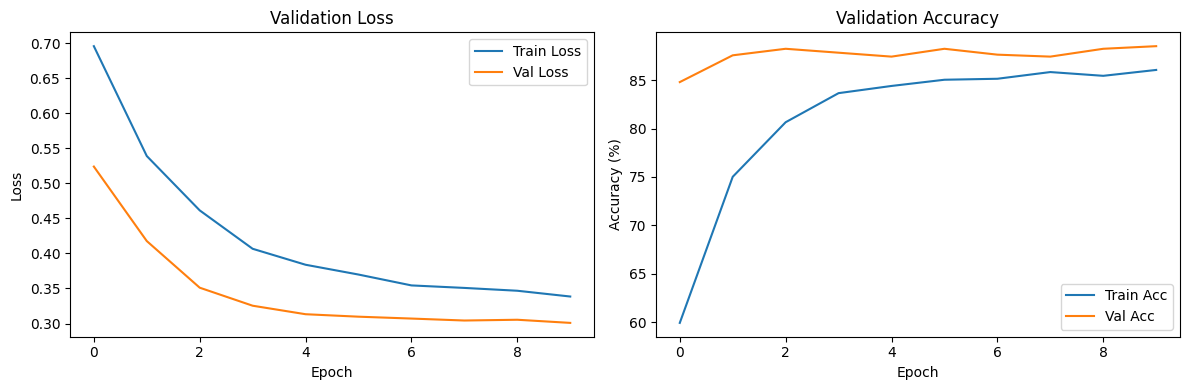

maximum accuracy:  88.52 %
high epoch:  10


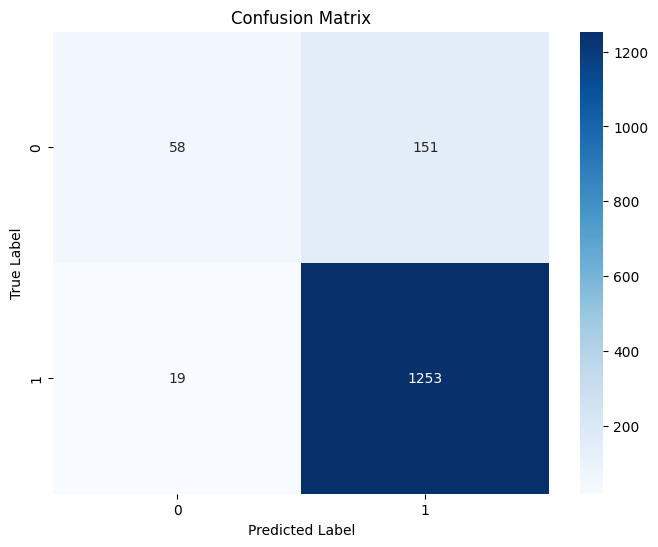

In [ ]:

# Cell 5: Visualization
print("\nGenerating visualizations...")
fnn_analyzer.plot_training_history()
fnn_analyzer.plot_interactive_training_history()
val_predictions = fnn_analyzer.predict(X_val_transformed)[0]
fnn_analyzer.plot_confusion_matrix(val_labels, val_predictions)

In [ ]:
 #Cell 1: Vectorizer Configurations
vectorizer_configs = {
    # 1. GloVe Configurations
    'glove_base': {
        'method': 'glove',
        'glove_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'name': 'glove_base'
    },

    # 2. TF-IDF Configurations
    'tfidf_base': {
        'method': 'tfidf',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'max_df': 0.85,
        'min_df': 2,
        'name': 'tfidf_base'
    },
    'tfidf_large': {
        'method': 'tfidf',
        'max_features': 10000,
        'ngram_range': (1, 3),
        'max_df': 0.9,
        'min_df': 1,
        'name': 'tfidf_large'
    },

    # 3. Combined GloVe + TF-IDF
    'combined': {
        'method': 'combined',
        'glove_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'max_features': 5000,
        'name': 'combined_base'
    },

    # 4. Count Vectorizer (BoW)
    'count_base': {
        'method': 'count',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'max_df': 0.85,
        'min_df': 2,
        'name': 'count_base'
    },

    # 5. Word2Vec
    'word2vec': {
        'method': 'word2vec',
        'vector_size': 100,
        'window': 5,
        'min_count': 2,
        'name': 'word2vec_base'
    }
}


In [ ]:
model_configs = {
    # Configurations for GloVe
    'glove_configs': [
        {
            'hidden_dims': [256, 128, 64],
            'dropout_rate': 0.6,
            'learning_rate': 0.0005,
            'batch_size': 32,
            'num_epochs': 10,
            'name': 'glove_baseline'
        },
        {
            'hidden_dims': [512, 256, 128],
            'dropout_rate': 0.5,
            'learning_rate': 0.001,
            'batch_size': 64,
            'num_epochs': 15,
            'name': 'glove_large'
        }
    ],

    # Configurations for TF-IDF
    'tfidf_configs': [
        {
            'hidden_dims': [512, 256],
            'dropout_rate': 0.5,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 10,
            'name': 'tfidf_baseline'
        },
        {
            'hidden_dims': [1024, 512, 256],
            'dropout_rate': 0.6,
            'learning_rate': 0.0005,
            'batch_size': 64,
            'num_epochs': 15,
            'name': 'tfidf_large'
        }
    ],

    # Configurations for Combined
    'combined_configs': [
        {
            'hidden_dims': [512, 256, 128],
            'dropout_rate': 0.6,
            'learning_rate': 0.0005,
            'batch_size': 32,
            'num_epochs': 12,
            'name': 'combined_baseline'
        }
    ],

    # Configurations for Count Vectorizer
    'count_configs': [
        {
            'hidden_dims': [256, 128],
            'dropout_rate': 0.5,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 10,
            'name': 'count_baseline'
        }
    ],

    # Configurations for Word2Vec
    'word2vec_configs': [
        {
            'hidden_dims': [256, 128, 64],
            'dropout_rate': 0.5,
            'learning_rate': 0.001,
            'batch_size': 32,
            'num_epochs': 10,
            'name': 'word2vec_baseline'
        }
    ]
}


Testing vectorizer: glove_base


NameError: name 'TextVectorizer' is not defined

In [ ]:
# First, update vectorizer_configs
vectorizer_configs = {
    'glove_base': {
        'method': 'glove',
        'glove_file_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'name': 'glove_base'
    },
    'tfidf_base': {
        'method': 'tfidf',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'name': 'tfidf_base'
    },
    'count_base': {
        'method': 'count',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'name': 'count_base'
    },
    'word2vec_base': {
        'method': 'word2vec',
        'vector_size': 100,
        'name': 'word2vec_base'
    },
    'combined_base': {
        'method': 'combined',
        'glove_file_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'max_features': 5000,
        'name': 'combined_base'
    }
}

# Update get_vectorizer function
def get_vectorizer(vec_config):
    method = vec_config['method']
    if method == 'glove':
        return AdvancedVectorizer(
            glove_file_path=vec_config['glove_file_path'],
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2))
        )
    elif method == 'tfidf':
        return TfidfTextVectorizer(
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2))
        )
    elif method == 'count':
        return CountTextVectorizer(
            max_features=vec_config.get('max_features', 5000),
            ngram_range=vec_config.get('ngram_range', (1, 2))
        )
    elif method == 'word2vec':
        return Word2VecTextVectorizer(
            vector_size=vec_config.get('vector_size', 100)
        )
    elif method == 'combined':
        return CombinedVectorizer(
            glove_path=vec_config['glove_file_path'],
            tfidf_max_features=vec_config.get('max_features', 5000)
        )
    else:
        raise ValueError(f"Unknown vectorizer method: {method}")

# Update run_vectorization_experiments function
def run_vectorization_experiments(train_texts, test_texts, train_labels, val_texts, val_labels, test_df):
    all_results = []

    for vec_name, vec_config in vectorizer_configs.items():
        print(f"\nTesting vectorizer: {vec_name}")

        try:
            # Initialize vectorizer
            vectorizer = get_vectorizer(vec_config)

            # Transform data
            print("Transforming data...")
            X_train = vectorizer.fit_transform(train_texts)
            X_val = vectorizer.transform(val_texts)
            X_test = vectorizer.transform(test_texts)

            print(f"Data shapes:")
            print(f"Train: {X_train.shape}")
            print(f"Val: {X_val.shape}")
            print(f"Test: {X_test.shape}")

            # Get model configs for this vectorizer
            model_configs_for_method = model_configs[f"{vec_config['method']}_configs"]

            # Train models with this vectorization
            for model_config in model_configs_for_method:
                print(f"\nTraining model: {model_config['name']}")
                result = train_and_evaluate_model(
                    model_config, X_train, train_labels,
                    X_val, val_labels, X_test, test_df
                )
                result['vectorizer'] = vec_name
                all_results.append(result)

        except Exception as e:
            print(f"Error with vectorizer {vec_name}: {str(e)}")
            continue

    return pd.DataFrame(all_results)

# Usage
if __name__ == "__main__":
    # Load data
    train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
    test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['reviews'],
        train_df['sentiments'],
        test_size=0.2,
        random_state=42
    )

    # Run experiments
    results_df = run_vectorization_experiments(
        train_texts, test_df['reviews'],
        train_labels, val_texts, val_labels,
        test_df
    )

    # Save results
    results_df.to_csv('vectorization_comparison_results.csv', index=False)


Testing vectorizer: glove_base
Loading GloVe model...
Loaded 400000 word vectors
Transforming data...
Data shapes:
Train: (5920, 100)
Val: (1481, 100)
Test: (1851, 100)

Training model: glove_baseline

Training model: glove_baseline
Parameters: {'hidden_dims': [256, 128, 64], 'dropout_rate': 0.6, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 10, 'name': 'glove_baseline'}
Epoch [1/10], Train Loss: 0.7319, Train Acc: 58.40%, Val Loss: 0.4851, Val Acc: 85.75%
Epoch [2/10], Train Loss: 0.5437, Train Acc: 73.80%, Val Loss: 0.4041, Val Acc: 87.51%
Epoch [3/10], Train Loss: 0.4544, Train Acc: 80.59%, Val Loss: 0.3648, Val Acc: 87.64%
Epoch [4/10], Train Loss: 0.4035, Train Acc: 83.31%, Val Loss: 0.3340, Val Acc: 88.25%
Epoch [5/10], Train Loss: 0.3739, Train Acc: 84.07%, Val Loss: 0.3073, Val Acc: 87.51%
Epoch [6/10], Train Loss: 0.3631, Train Acc: 84.85%, Val Loss: 0.3057, Val Acc: 87.37%
Epoch [7/10], Train Loss: 0.3534, Train Acc: 85.32%, Val Loss: 0.3043, Val Acc: 87.10%
Epoch

In [ ]:
 #Vectorizer configurations
vectorizer_configs = {
    'glove_base': {
        'method': 'glove',
        'glove_file_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'name': 'glove_base'
    },
    'tfidf_base': {
        'method': 'tfidf',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'name': 'tfidf_base'
    },
    'count_base': {
        'method': 'count',
        'max_features': 5000,
        'ngram_range': (1, 2),
        'name': 'count_base'
    },
    'word2vec_base': {
        'method': 'word2vec',
        'vector_size': 100,
        'name': 'word2vec_base'
    },
    'combined_base': {
        'method': 'combined',
        'glove_file_path': '/content/drive/My Drive/AI DM PROJECT/Glove/glove.6B.100d.txt',
        'max_features': 5000,
        'name': 'combined_base'
    }
}

# Model configurations for different architectures
model_configs = {
    'glove_configs': [
        {
            'name': 'base_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [256, 128],
                'dropout_rate': 0.3,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 10
            }
        },
        {
            'name': 'large_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [512, 256, 128],
                'dropout_rate': 0.5,
                'learning_rate': 0.001,
                'batch_size': 64,
                'num_epochs': 15
            }
        },
        {
            'name': 'small_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [128, 64],
                'dropout_rate': 0.2,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 8
            }
        },
        {
            'name': 'deep_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'num_epochs': 20
            }
        },
        {
            'name': 'fast_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [64],
                'dropout_rate': 0.2,
                'learning_rate': 0.002,
                'batch_size': 128,
                'num_epochs': 5
            }
        }
    ],
    'tfidf_configs': [
        {
            'name': 'base_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [256, 128],
                'dropout_rate': 0.3,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 10
            }
        },
        {
            'name': 'large_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [1024, 512, 256],
                'dropout_rate': 0.5,
                'learning_rate': 0.001,
                'batch_size': 64,
                'num_epochs': 15
            }
        },
        {
            'name': 'small_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [128, 64],
                'dropout_rate': 0.2,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 8
            }
        },
        {
            'name': 'deep_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [1024, 512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'num_epochs': 20
            }
        },
        {
            'name': 'fast_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [64],
                'dropout_rate': 0.2,
                'learning_rate': 0.002,
                'batch_size': 128,
                'num_epochs': 5
            }
        }
    ],
    'count_configs': [
        {
            'name': 'base_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [256, 128],
                'dropout_rate': 0.3,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 10
            }
        },
        {
            'name': 'large_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [1024, 512, 256],
                'dropout_rate': 0.5,
                'learning_rate': 0.001,
                'batch_size': 64,
                'num_epochs': 15
            }
        },
        {
            'name': 'small_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [128, 64],
                'dropout_rate': 0.2,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 8
            }
        },
        {
            'name': 'deep_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [1024, 512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'num_epochs': 20
            }
        },
        {
            'name': 'fast_mlp',
            'type': 'mlp',
            'params': {
                'hidden_dims': [64],
                'dropout_rate': 0.2,
                'learning_rate': 0.002,
                'batch_size': 128,
                'num_epochs': 5
            }
        }
    ],
    'word2vec_configs': [
        {
            'name': 'base_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [256, 128],
                'dropout_rate': 0.3,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 10
            }
        },
        {
            'name': 'large_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [512, 256, 128],
                'dropout_rate': 0.5,
                'learning_rate': 0.001,
                'batch_size': 64,
                'num_epochs': 15
            }
        },
        {
            'name': 'small_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [128, 64],
                'dropout_rate': 0.2,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 8
            }
        },
        {
            'name': 'deep_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'num_epochs': 20
            }
        },
        {
            'name': 'fast_lstm',
            'type': 'lstm',
            'params': {
                'hidden_dims': [64],
                'dropout_rate': 0.2,
                'learning_rate': 0.002,
                'batch_size': 128,
                'num_epochs': 5
            }
        }
    ],
    'combined_configs': [
        {
            'name': 'base_combined',
            'type': 'combined',
            'params': {
                'hidden_dims': [256, 128],
                'dropout_rate': 0.3,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 10
            }
        },
        {
            'name': 'large_combined',
            'type': 'combined',
            'params': {
                'hidden_dims': [512, 256, 128],
                'dropout_rate': 0.5,
                'learning_rate': 0.001,
                'batch_size': 64,
                'num_epochs': 15
            }
        },
        {
            'name': 'small_combined',
            'type': 'combined',
            'params': {
                'hidden_dims': [128, 64],
                'dropout_rate': 0.2,
                'learning_rate': 0.001,
                'batch_size': 32,
                'num_epochs': 8
            }
        },
        {
            'name': 'deep_combined',
            'type': 'combined',
            'params': {
                'hidden_dims': [512, 256, 128, 64],
                'dropout_rate': 0.5,
                'learning_rate': 0.0005,
                'batch_size': 32,
                'num_epochs': 20
            }
        },
        {
            'name': 'fast_combined',
            'type': 'combined',
            'params': {
                'hidden_dims': [64],
                'dropout_rate': 0.2,
                'learning_rate': 0.002,
                'batch_size': 128,
                'num_epochs': 5
            }
        }
    ]
}

# Model architecture characteristics:
# Base models: Balanced architecture with moderate complexity
# Large models: More neurons and layers, longer training time
# Small models: Fewer neurons and layers, faster training
# Deep models: Many layers with gradual size reduction
# Fast models: Minimal architecture for quick training

"""
1. ARCHITECTURAL PARAMETERS BEING TUNED:
---------------------------------------
hidden_dims: Neural network layer sizes
- Base models: [256, 128]           # Balanced 2-layer architecture
- Large models: [512, 256, 128]     # Wider and deeper 3-layer
- Small models: [128, 64]           # Compact 2-layer
- Deep models: [512, 256, 128, 64]  # Deep 4-layer with gradual reduction
- Fast models: [64]                 # Single small layer

2. TRAINING PARAMETERS BEING TUNED:
----------------------------------
dropout_rate:
- Heavy regularization: 0.5         # Used in large and deep models
- Medium regularization: 0.3        # Used in base models
- Light regularization: 0.2         # Used in small and fast models

learning_rate:
- Fast learning: 0.002             # Used in fast models
- Standard learning: 0.001         # Used in base, large, small models
- Careful learning: 0.0005        # Used in deep models

batch_size:
- Large batches: 128              # Used in fast models
- Medium batches: 64              # Used in large models
- Small batches: 32              # Used in base, small, deep models

num_epochs:
- Long training: 20              # Used in deep models
- Medium training: 15           # Used in large models
- Standard training: 10        # Used in base models
- Short training: 8           # Used in small models
- Quick training: 5          # Used in fast models

3. VECTORIZER PARAMETERS BEING TUNED:
-----------------------------------
For TFIDF and Count Vectorizers:
- max_features: 5000              # Maximum number of words to keep
- ngram_range: (1, 2)            # Use both unigrams and bigrams

For Word2Vec:
- vector_size: 100               # Dimension of word vectors

For GloVe:
- Using pre-trained 100d vectors  # Fixed 100-dimensional vectors

For Combined:
- Combines GloVe with TFIDF
- max_features: 5000             # For the TFIDF component

4. PARAMETER RELATIONSHIPS:
-------------------------
Fast Models:
- Smallest architecture [64]
- Highest learning rate (0.002)
- Largest batch size (128)
- Fewest epochs (5)
- Light dropout (0.2)
-> Optimized for speed

Deep Models:
- Most layers [512, 256, 128, 64]
- Lowest learning rate (0.0005)
- Small batch size (32)
- Most epochs (20)
- Heavy dropout (0.5)
-> Optimized for complex patterns

Large Models:
- Wide layers [512, 256, 128]
- Standard learning rate (0.001)
- Medium batch size (64)
- More epochs (15)
- Heavy dropout (0.5)
-> Optimized for capacity

Small Models:
- Compact layers [128, 64]
- Standard learning rate (0.001)
- Small batch size (32)
- Fewer epochs (8)
- Light dropout (0.2)
-> Optimized for efficiency

Base Models:
- Balanced layers [256, 128]
- Standard learning rate (0.001)
- Small batch size (32)
- Standard epochs (10)
- Medium dropout (0.3)
-> Balanced baseline
"""


"""
VECTORIZER TYPES EXPLANATION:
----------------------------
1. glove_base:
   - Pre-trained word embeddings from GloVe (Global Vectors for Word Representation)
   - Converts words to 100-dimensional vectors based on their usage in large text corpora
   - Good for capturing word meaning and relationships

2. tfidf_base:
   - TF-IDF (Term Frequency-Inverse Document Frequency) vectorization
   - Converts texts to numerical vectors based on word importance
   - Good for capturing important words while downweighting common words

3. count_base:
   - Simple Bag-of-Words (BoW) approach using word counts
   - Converts texts to vectors based on word frequency
   - Basic but effective for many tasks

4. word2vec_base:
   - Trains word embeddings on your specific dataset
   - Similar to GloVe but learns relationships from your data
   - Good for domain-specific vocabulary

5. combined_base:
   - Hybrid approach combining GloVe embeddings with TF-IDF
   - Leverages both semantic meaning and word importance
   - Can capture both global and local word relationships

MODEL ARCHITECTURES EXPLANATION:
------------------------------
1. LSTM (Long Short-Term Memory) Models:
   - Used for sequential data like text
   - Can remember important information over long sequences
   - Better at understanding context and word order
   - Types:
     * base_lstm: Balanced architecture (2 layers: 256->128)
     * large_lstm: More capacity (3 layers: 512->256->128)
     * small_lstm: Lightweight (2 layers: 128->64)
     * deep_lstm: Complex patterns (4 layers: 512->256->128->64)
     * fast_lstm: Quick training (1 layer: 64)

2. Feedforward/MLP (Multi-Layer Perceptron) Models:
   - Basic neural network architecture
   - Processes input all at once rather than sequentially
   - Good for fixed-length feature vectors
   - Types:
     * base_mlp: Balanced architecture (2 layers: 256->128)
     * large_mlp: More capacity (3 layers: 1024->512->256)
     * small_mlp: Lightweight (2 layers: 128->64)
     * deep_mlp: Complex patterns (5 layers: 1024->512->256->128->64)
     * fast_mlp: Quick training (1 layer: 64)

MODEL VARIATIONS EXPLANATION:
---------------------------
1. Base Models:
   - Balanced architecture for general use
   - Moderate complexity and training time
   - Good default choice for most tasks

2. Large Models:
   - More neurons and layers
   - Better at learning complex patterns
   - Requires more training time and data
   - May perform better on larger datasets

3. Small Models:
   - Fewer neurons and layers
   - Faster training and inference
   - Good for quick experiments or smaller datasets
   - May have lower capacity for complex patterns

4. Deep Models:
   - Many layers with gradual size reduction
   - Can learn hierarchical features
   - Longest training time
   - Best for complex relationships in data

5. Fast Models:
   - Minimal architecture
   - Quickest training time
   - Good for rapid prototyping
   - May sacrifice some accuracy for speed

WHEN TO USE WHICH:
-----------------
1. LSTM Models (base_lstm, etc.):
   - When word order matters
   - For capturing long-range dependencies
   - When you need to understand context
   - Better with word embeddings (GloVe, Word2Vec)

2. Feedforward Models (base_mlp, etc.):
   - When using bag-of-words features
   - For simpler text classification
   - When word order is less important
   - Better with TF-IDF or count vectors

3. Size Selection:
   - Base: Start here for most tasks
   - Large: If base model underfits
   - Small: If base model is too slow
   - Deep: For complex relationships
   - Fast: For quick experiments

PARAMETER MEANINGS:
-----------------
hidden_dims: Size of hidden layers (e.g., [256, 128] means two layers)
dropout_rate: Regularization strength (higher = more regularization)
learning_rate: Speed of training (higher = faster but potentially unstable)
batch_size: Number of examples processed at once
num_epochs: Number of times to process entire dataset
"""



Testing vectorizer: glove_base
Loading GloVe model...
Loaded 400000 word vectors
Transforming data...
Data shapes:
Train: (5920, 100)
Val: (1481, 100)
Test: (1851, 100)
Training model: base_lstm
Parameters: {'name': 'base_lstm', 'type': 'lstm', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.5136, Train Acc: 75.81%, Val Loss: 0.3479, Val Acc: 86.23%
Epoch [2/10], Train Loss: 0.3341, Train Acc: 86.49%, Val Loss: 0.3214, Val Acc: 86.90%
Epoch [3/10], Train Loss: 0.3065, Train Acc: 87.52%, Val Loss: 0.3543, Val Acc: 86.36%
Epoch [4/10], Train Loss: 0.2922, Train Acc: 87.89%, Val Loss: 0.3130, Val Acc: 88.05%
Epoch [5/10], Train Loss: 0.2892, Train Acc: 87.96%, Val Loss: 0.3074, Val Acc: 88.32%
Epoch [6/10], Train Loss: 0.2883, Train Acc: 87.94%, Val Loss: 0.3050, Val Acc: 87.51%
Epoch [7/10], Train Loss: 0.2823, Train Acc: 87.89%, Val Loss: 0.3192, Val Acc: 87.24%
Epoch [8/10], Train Loss:

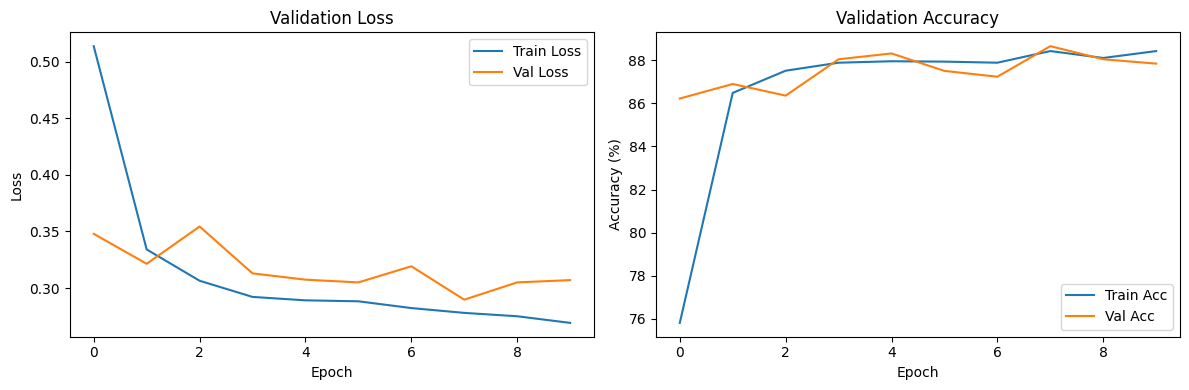

maximum accuracy:  88.66 %
high epoch:  8
Training model: large_lstm
Parameters: {'name': 'large_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.6288, Train Acc: 66.94%, Val Loss: 0.4505, Val Acc: 86.83%
Epoch [2/15], Train Loss: 0.4448, Train Acc: 81.81%, Val Loss: 0.3322, Val Acc: 87.64%
Epoch [3/15], Train Loss: 0.3627, Train Acc: 85.76%, Val Loss: 0.3127, Val Acc: 87.64%
Epoch [4/15], Train Loss: 0.3358, Train Acc: 86.20%, Val Loss: 0.3038, Val Acc: 87.51%
Epoch [5/15], Train Loss: 0.3213, Train Acc: 86.59%, Val Loss: 0.3032, Val Acc: 87.44%
Epoch [6/15], Train Loss: 0.3061, Train Acc: 86.88%, Val Loss: 0.3042, Val Acc: 87.78%
Epoch [7/15], Train Loss: 0.3002, Train Acc: 86.98%, Val Loss: 0.2975, Val Acc: 87.98%
Epoch [8/15], Train Loss: 0.2919, Train Acc: 87.53%, Val Loss: 0.3084, Val Acc: 87.64%
Epoch [9/15], Train Loss: 0.2902, Train Acc: 87.45%, Val Lo

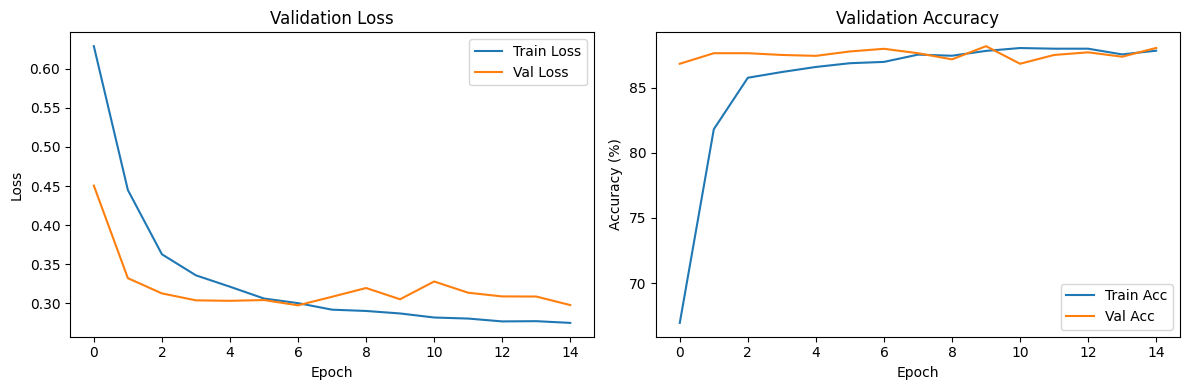

maximum accuracy:  88.18 %
high epoch:  10
Training model: small_lstm
Parameters: {'name': 'small_lstm', 'type': 'lstm', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.5022, Train Acc: 76.25%, Val Loss: 0.3316, Val Acc: 87.17%
Epoch [2/8], Train Loss: 0.3333, Train Acc: 86.42%, Val Loss: 0.3397, Val Acc: 86.29%
Epoch [3/8], Train Loss: 0.3088, Train Acc: 87.28%, Val Loss: 0.3187, Val Acc: 86.63%
Epoch [4/8], Train Loss: 0.2976, Train Acc: 87.13%, Val Loss: 0.2946, Val Acc: 87.71%
Epoch [5/8], Train Loss: 0.2958, Train Acc: 87.38%, Val Loss: 0.2949, Val Acc: 87.71%
Epoch [6/8], Train Loss: 0.2779, Train Acc: 88.29%, Val Loss: 0.3120, Val Acc: 87.04%
Epoch [7/8], Train Loss: 0.2792, Train Acc: 87.97%, Val Loss: 0.3347, Val Acc: 87.31%
Epoch [8/8], Train Loss: 0.2716, Train Acc: 88.18%, Val Loss: 0.3317, Val Acc: 87.58%


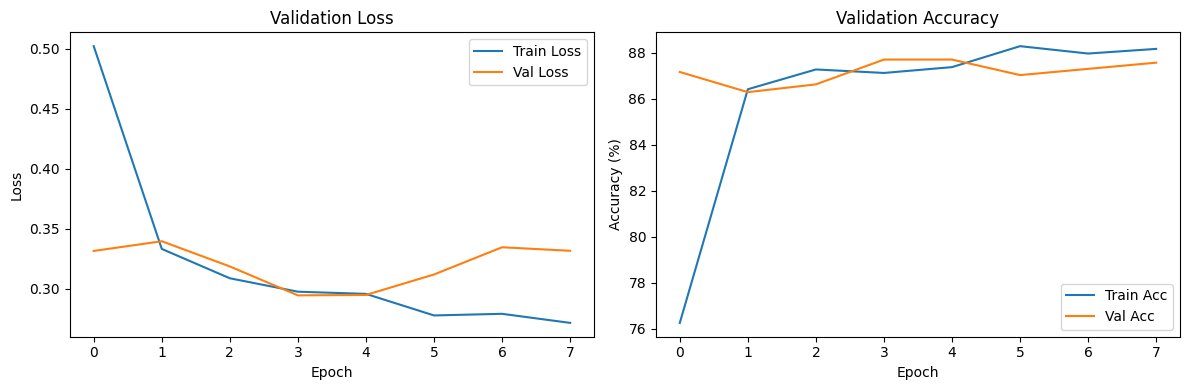

maximum accuracy:  87.71 %
high epoch:  4
Training model: deep_lstm
Parameters: {'name': 'deep_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6293, Train Acc: 66.72%, Val Loss: 0.4734, Val Acc: 86.56%
Epoch [2/20], Train Loss: 0.4773, Train Acc: 79.88%, Val Loss: 0.3735, Val Acc: 88.05%
Epoch [3/20], Train Loss: 0.4028, Train Acc: 83.94%, Val Loss: 0.3328, Val Acc: 87.85%
Epoch [4/20], Train Loss: 0.3598, Train Acc: 85.15%, Val Loss: 0.3109, Val Acc: 88.39%
Epoch [5/20], Train Loss: 0.3414, Train Acc: 85.69%, Val Loss: 0.3183, Val Acc: 87.10%
Epoch [6/20], Train Loss: 0.3227, Train Acc: 86.81%, Val Loss: 0.3003, Val Acc: 87.24%
Epoch [7/20], Train Loss: 0.3262, Train Acc: 86.42%, Val Loss: 0.2961, Val Acc: 87.71%
Epoch [8/20], Train Loss: 0.3131, Train Acc: 86.44%, Val Loss: 0.2925, Val Acc: 87.10%
Epoch [9/20], Train Loss: 0.3128, Train Acc: 87.06%, Val

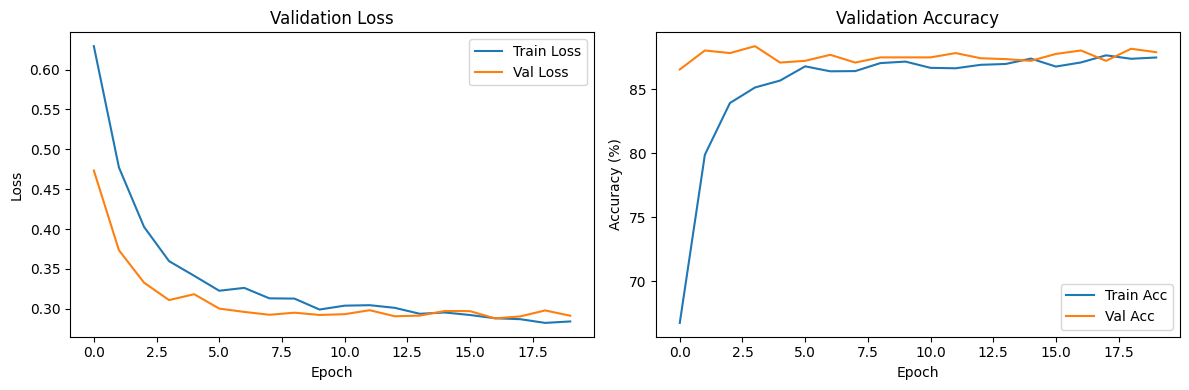

maximum accuracy:  88.39 %
high epoch:  4
Training model: fast_lstm
Parameters: {'name': 'fast_lstm', 'type': 'lstm', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5865, Train Acc: 68.50%, Val Loss: 0.4374, Val Acc: 87.51%
Epoch [2/5], Train Loss: 0.3408, Train Acc: 86.72%, Val Loss: 0.3897, Val Acc: 82.92%
Epoch [3/5], Train Loss: 0.3005, Train Acc: 87.64%, Val Loss: 0.2956, Val Acc: 87.91%
Epoch [4/5], Train Loss: 0.2957, Train Acc: 86.93%, Val Loss: 0.3496, Val Acc: 85.89%
Epoch [5/5], Train Loss: 0.2897, Train Acc: 87.57%, Val Loss: 0.3076, Val Acc: 86.97%


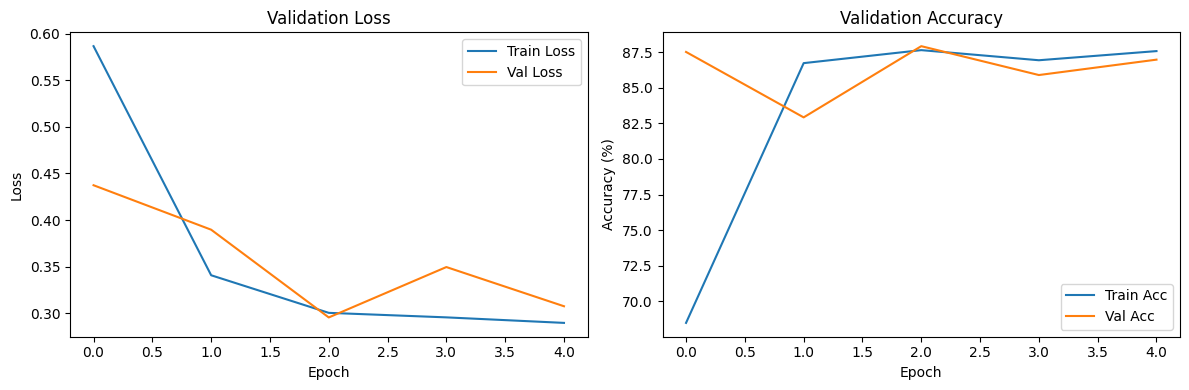

maximum accuracy:  87.91 %
high epoch:  3

Testing vectorizer: tfidf_base
Transforming data...
Data shapes:
Train: (5920, 5000)
Val: (1481, 5000)
Test: (1851, 5000)
Training model: base_mlp
Parameters: {'name': 'base_mlp', 'type': 'mlp', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4707, Train Acc: 78.56%, Val Loss: 0.2570, Val Acc: 91.56%
Epoch [2/10], Train Loss: 0.1487, Train Acc: 95.08%, Val Loss: 0.2419, Val Acc: 91.42%
Epoch [3/10], Train Loss: 0.0820, Train Acc: 97.06%, Val Loss: 0.2954, Val Acc: 91.09%
Epoch [4/10], Train Loss: 0.0533, Train Acc: 98.12%, Val Loss: 0.2952, Val Acc: 91.83%
Epoch [5/10], Train Loss: 0.0420, Train Acc: 98.53%, Val Loss: 0.3063, Val Acc: 91.90%
Epoch [6/10], Train Loss: 0.0332, Train Acc: 98.94%, Val Loss: 0.3218, Val Acc: 92.23%
Epoch [7/10], Train Loss: 0.0221, Train Acc: 99.21%, Val Loss: 0.3626, Val Acc: 92.17%
Epoch [8/10], Train Loss: 0.0179,

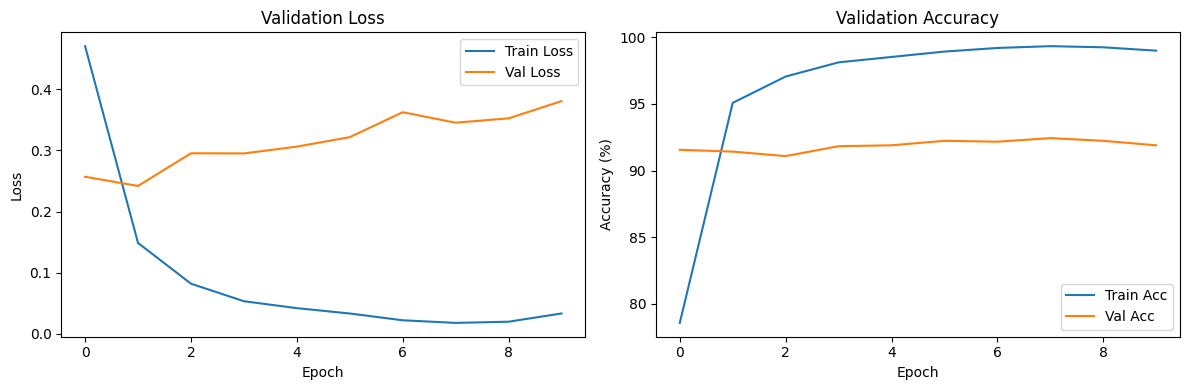

maximum accuracy:  92.44 %
high epoch:  8
Training model: large_mlp
Parameters: {'name': 'large_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5612, Train Acc: 72.70%, Val Loss: 0.3198, Val Acc: 91.96%
Epoch [2/15], Train Loss: 0.2299, Train Acc: 93.65%, Val Loss: 0.2718, Val Acc: 91.83%
Epoch [3/15], Train Loss: 0.1237, Train Acc: 96.50%, Val Loss: 0.3193, Val Acc: 91.42%
Epoch [4/15], Train Loss: 0.0747, Train Acc: 97.70%, Val Loss: 0.3483, Val Acc: 91.56%
Epoch [5/15], Train Loss: 0.0562, Train Acc: 98.29%, Val Loss: 0.3598, Val Acc: 91.90%
Epoch [6/15], Train Loss: 0.0488, Train Acc: 98.55%, Val Loss: 0.3422, Val Acc: 91.83%
Epoch [7/15], Train Loss: 0.0351, Train Acc: 98.80%, Val Loss: 0.3637, Val Acc: 92.10%
Epoch [8/15], Train Loss: 0.0278, Train Acc: 99.07%, Val Loss: 0.3993, Val Acc: 91.76%
Epoch [9/15], Train Loss: 0.0297, Train Acc: 99.10%, Val Loss

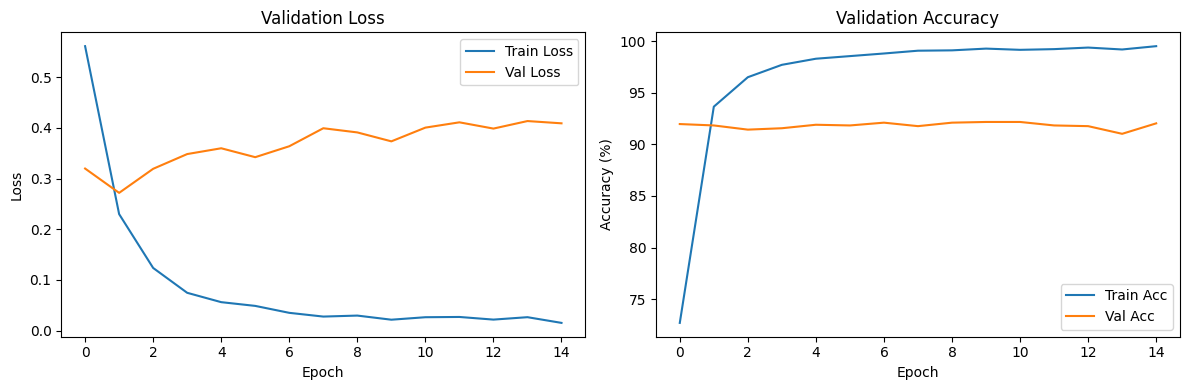

maximum accuracy:  92.17 %
high epoch:  10
Training model: small_mlp
Parameters: {'name': 'small_mlp', 'type': 'mlp', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4507, Train Acc: 80.46%, Val Loss: 0.2642, Val Acc: 90.75%
Epoch [2/8], Train Loss: 0.1436, Train Acc: 95.69%, Val Loss: 0.2421, Val Acc: 91.49%
Epoch [3/8], Train Loss: 0.0665, Train Acc: 97.84%, Val Loss: 0.2774, Val Acc: 91.76%
Epoch [4/8], Train Loss: 0.0472, Train Acc: 98.43%, Val Loss: 0.2930, Val Acc: 91.49%
Epoch [5/8], Train Loss: 0.0358, Train Acc: 98.72%, Val Loss: 0.3183, Val Acc: 92.17%
Epoch [6/8], Train Loss: 0.0274, Train Acc: 99.00%, Val Loss: 0.3309, Val Acc: 91.76%
Epoch [7/8], Train Loss: 0.0299, Train Acc: 98.90%, Val Loss: 0.3625, Val Acc: 91.15%
Epoch [8/8], Train Loss: 0.0194, Train Acc: 99.46%, Val Loss: 0.3551, Val Acc: 91.49%


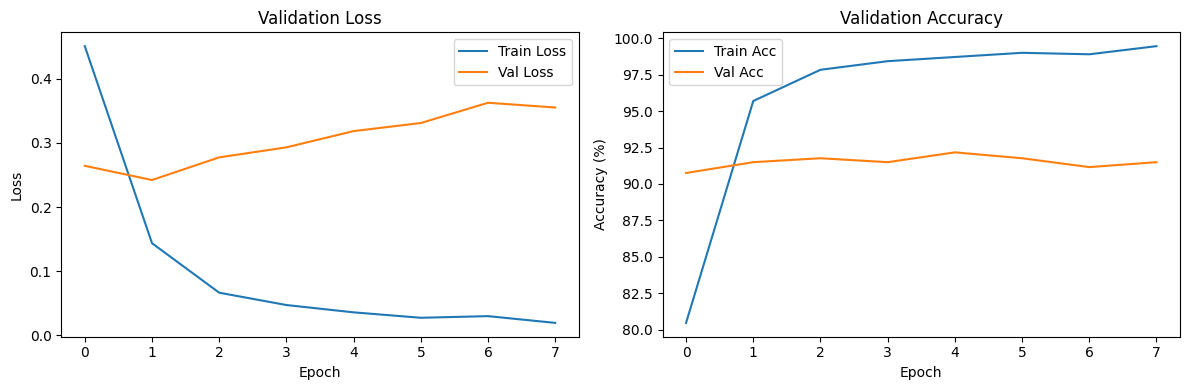

maximum accuracy:  92.17 %
high epoch:  5
Training model: deep_mlp
Parameters: {'name': 'deep_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6507, Train Acc: 64.78%, Val Loss: 0.3954, Val Acc: 87.98%
Epoch [2/20], Train Loss: 0.4333, Train Acc: 83.75%, Val Loss: 0.2671, Val Acc: 92.03%
Epoch [3/20], Train Loss: 0.2722, Train Acc: 91.77%, Val Loss: 0.2480, Val Acc: 90.95%
Epoch [4/20], Train Loss: 0.1916, Train Acc: 94.32%, Val Loss: 0.2696, Val Acc: 90.95%
Epoch [5/20], Train Loss: 0.1498, Train Acc: 95.68%, Val Loss: 0.2837, Val Acc: 90.21%
Epoch [6/20], Train Loss: 0.1096, Train Acc: 97.04%, Val Loss: 0.2871, Val Acc: 91.02%
Epoch [7/20], Train Loss: 0.0947, Train Acc: 97.40%, Val Loss: 0.3194, Val Acc: 90.61%
Epoch [8/20], Train Loss: 0.0749, Train Acc: 97.64%, Val Loss: 0.3228, Val Acc: 91.83%
Epoch [9/20], Train Loss: 0.0686, Train Acc: 97.84%, 

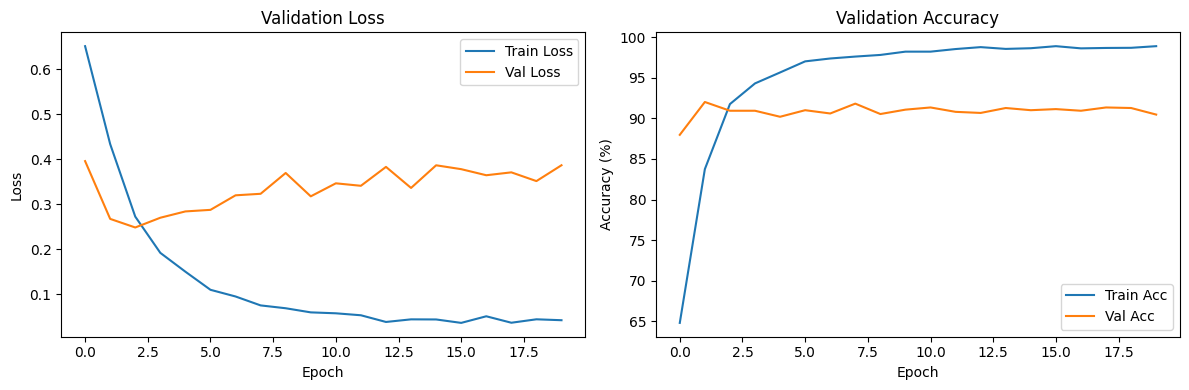

maximum accuracy:  92.03 %
high epoch:  2
Training model: fast_mlp
Parameters: {'name': 'fast_mlp', 'type': 'mlp', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.4899, Train Acc: 78.09%, Val Loss: 0.4129, Val Acc: 88.39%
Epoch [2/5], Train Loss: 0.1254, Train Acc: 97.23%, Val Loss: 0.2081, Val Acc: 92.64%
Epoch [3/5], Train Loss: 0.0262, Train Acc: 99.51%, Val Loss: 0.2426, Val Acc: 92.44%
Epoch [4/5], Train Loss: 0.0126, Train Acc: 99.83%, Val Loss: 0.2614, Val Acc: 92.51%
Epoch [5/5], Train Loss: 0.0065, Train Acc: 99.97%, Val Loss: 0.2814, Val Acc: 92.37%


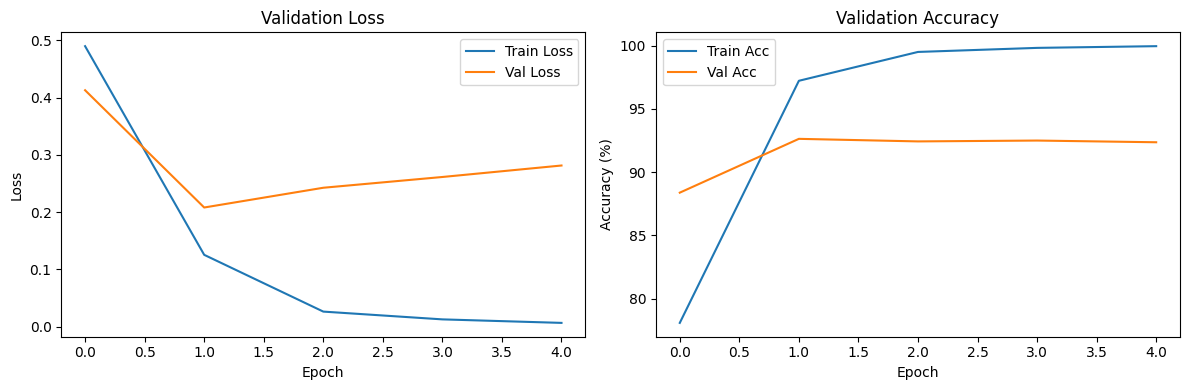

maximum accuracy:  92.64 %
high epoch:  2

Testing vectorizer: count_base
Transforming data...
Data shapes:
Train: (5920, 5000)
Val: (1481, 5000)
Test: (1851, 5000)
Training model: base_mlp
Parameters: {'name': 'base_mlp', 'type': 'mlp', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4647, Train Acc: 78.75%, Val Loss: 0.2720, Val Acc: 90.95%
Epoch [2/10], Train Loss: 0.1787, Train Acc: 94.05%, Val Loss: 0.2216, Val Acc: 91.56%
Epoch [3/10], Train Loss: 0.0895, Train Acc: 96.94%, Val Loss: 0.2435, Val Acc: 92.51%
Epoch [4/10], Train Loss: 0.0554, Train Acc: 97.94%, Val Loss: 0.2542, Val Acc: 92.37%
Epoch [5/10], Train Loss: 0.0456, Train Acc: 98.45%, Val Loss: 0.2822, Val Acc: 91.63%
Epoch [6/10], Train Loss: 0.0363, Train Acc: 98.70%, Val Loss: 0.2961, Val Acc: 91.56%
Epoch [7/10], Train Loss: 0.0296, Train Acc: 99.09%, Val Loss: 0.2972, Val Acc: 92.17%
Epoch [8/10], Train Loss: 0.0288,

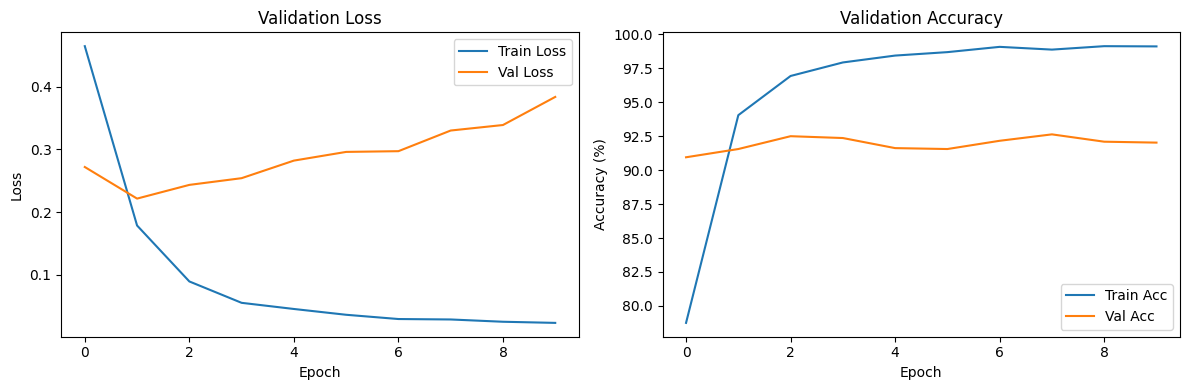

maximum accuracy:  92.64 %
high epoch:  8
Training model: large_mlp
Parameters: {'name': 'large_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5398, Train Acc: 73.90%, Val Loss: 0.3781, Val Acc: 89.20%
Epoch [2/15], Train Loss: 0.2449, Train Acc: 92.53%, Val Loss: 0.2385, Val Acc: 92.64%
Epoch [3/15], Train Loss: 0.1201, Train Acc: 96.44%, Val Loss: 0.2318, Val Acc: 92.84%
Epoch [4/15], Train Loss: 0.0872, Train Acc: 97.38%, Val Loss: 0.2682, Val Acc: 92.23%
Epoch [5/15], Train Loss: 0.0578, Train Acc: 98.24%, Val Loss: 0.2962, Val Acc: 92.64%
Epoch [6/15], Train Loss: 0.0419, Train Acc: 98.70%, Val Loss: 0.3253, Val Acc: 92.57%
Epoch [7/15], Train Loss: 0.0344, Train Acc: 99.02%, Val Loss: 0.3470, Val Acc: 91.63%
Epoch [8/15], Train Loss: 0.0214, Train Acc: 99.29%, Val Loss: 0.4090, Val Acc: 91.83%
Epoch [9/15], Train Loss: 0.0275, Train Acc: 99.14%, Val Loss

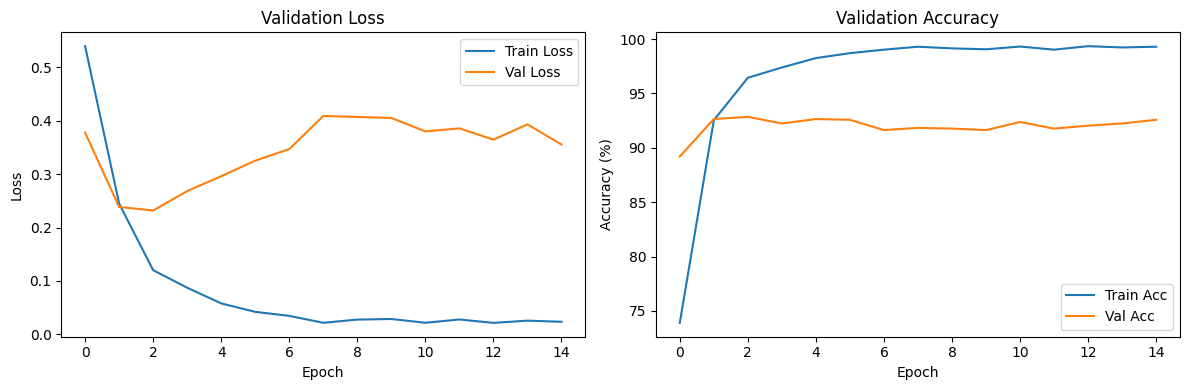

maximum accuracy:  92.84 %
high epoch:  3
Training model: small_mlp
Parameters: {'name': 'small_mlp', 'type': 'mlp', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4767, Train Acc: 79.21%, Val Loss: 0.2706, Val Acc: 91.63%
Epoch [2/8], Train Loss: 0.1646, Train Acc: 94.83%, Val Loss: 0.2486, Val Acc: 91.29%
Epoch [3/8], Train Loss: 0.0908, Train Acc: 96.88%, Val Loss: 0.2591, Val Acc: 91.29%
Epoch [4/8], Train Loss: 0.0600, Train Acc: 97.91%, Val Loss: 0.2690, Val Acc: 92.44%
Epoch [5/8], Train Loss: 0.0424, Train Acc: 98.43%, Val Loss: 0.2802, Val Acc: 92.03%
Epoch [6/8], Train Loss: 0.0475, Train Acc: 98.36%, Val Loss: 0.2924, Val Acc: 92.23%
Epoch [7/8], Train Loss: 0.0302, Train Acc: 98.99%, Val Loss: 0.3202, Val Acc: 92.03%
Epoch [8/8], Train Loss: 0.0178, Train Acc: 99.46%, Val Loss: 0.3286, Val Acc: 92.30%


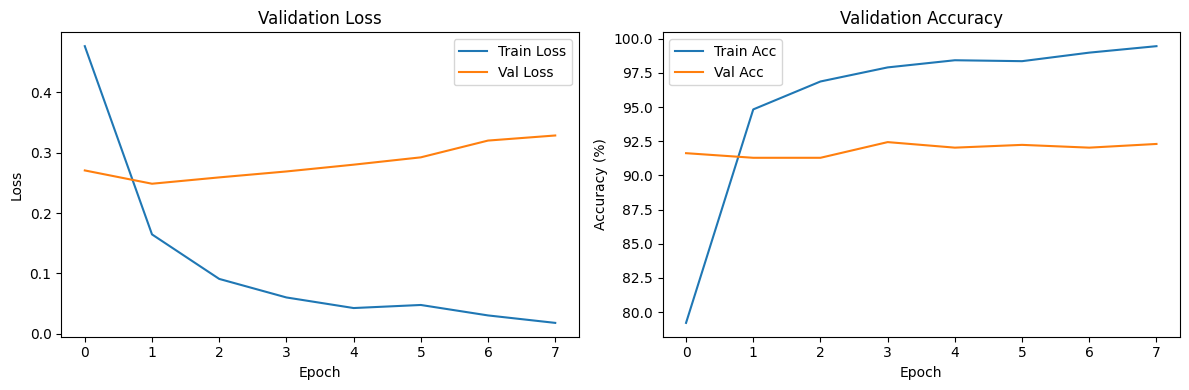

maximum accuracy:  92.44 %
high epoch:  4
Training model: deep_mlp
Parameters: {'name': 'deep_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.7062, Train Acc: 57.18%, Val Loss: 0.5426, Val Acc: 86.83%
Epoch [2/20], Train Loss: 0.4919, Train Acc: 78.40%, Val Loss: 0.3319, Val Acc: 90.61%
Epoch [3/20], Train Loss: 0.3150, Train Acc: 89.66%, Val Loss: 0.2439, Val Acc: 91.63%
Epoch [4/20], Train Loss: 0.2183, Train Acc: 93.06%, Val Loss: 0.2379, Val Acc: 92.23%
Epoch [5/20], Train Loss: 0.1735, Train Acc: 95.02%, Val Loss: 0.2243, Val Acc: 92.98%
Epoch [6/20], Train Loss: 0.1452, Train Acc: 95.52%, Val Loss: 0.2299, Val Acc: 91.63%
Epoch [7/20], Train Loss: 0.1029, Train Acc: 96.89%, Val Loss: 0.2389, Val Acc: 92.44%
Epoch [8/20], Train Loss: 0.0775, Train Acc: 97.62%, Val Loss: 0.2792, Val Acc: 91.69%
Epoch [9/20], Train Loss: 0.0776, Train Acc: 97.75%, 

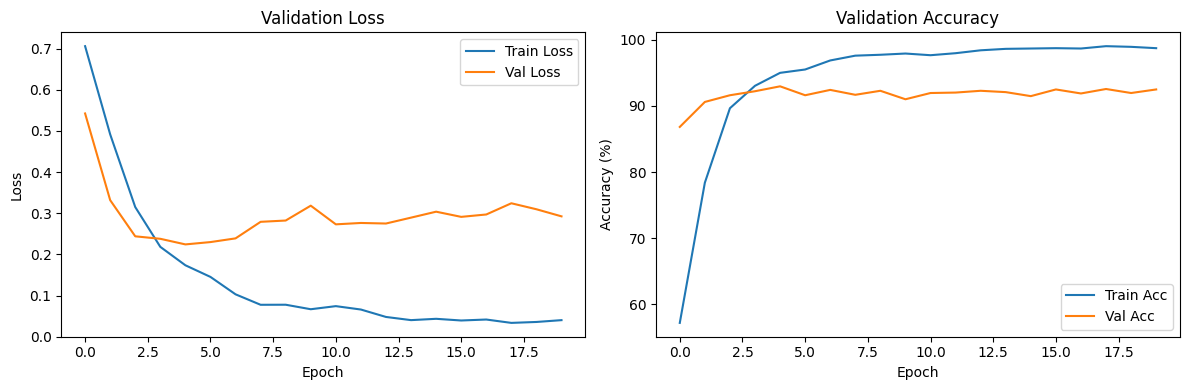

maximum accuracy:  92.98 %
high epoch:  5
Training model: fast_mlp
Parameters: {'name': 'fast_mlp', 'type': 'mlp', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.4953, Train Acc: 78.68%, Val Loss: 0.3337, Val Acc: 91.96%
Epoch [2/5], Train Loss: 0.1706, Train Acc: 96.01%, Val Loss: 0.2127, Val Acc: 92.78%
Epoch [3/5], Train Loss: 0.0500, Train Acc: 99.10%, Val Loss: 0.2107, Val Acc: 92.44%
Epoch [4/5], Train Loss: 0.0189, Train Acc: 99.71%, Val Loss: 0.2282, Val Acc: 92.84%
Epoch [5/5], Train Loss: 0.0111, Train Acc: 99.78%, Val Loss: 0.2438, Val Acc: 92.44%


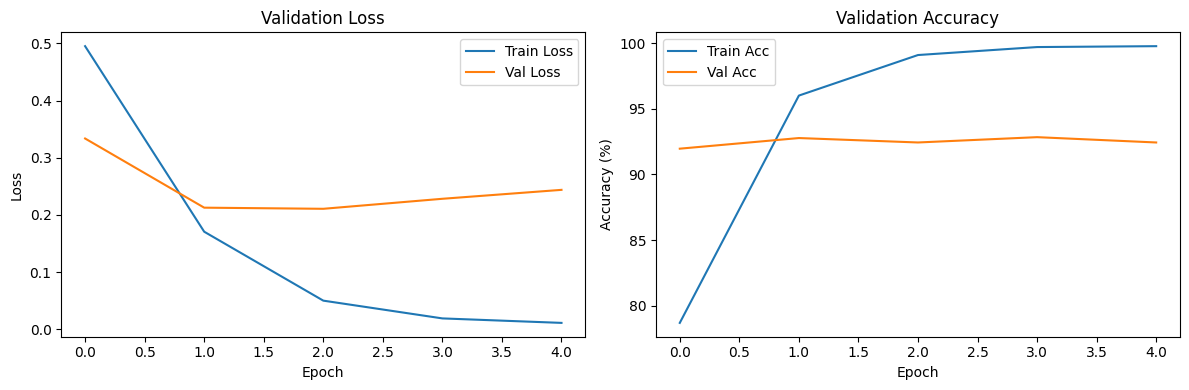

maximum accuracy:  92.84 %
high epoch:  4

Testing vectorizer: word2vec_base
Transforming data...
Data shapes:
Train: (5920, 100)
Val: (1481, 100)
Test: (1851, 100)
Training model: base_lstm
Parameters: {'name': 'base_lstm', 'type': 'lstm', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.5378, Train Acc: 73.36%, Val Loss: 0.3470, Val Acc: 86.43%
Epoch [2/10], Train Loss: 0.3734, Train Acc: 84.31%, Val Loss: 0.3420, Val Acc: 86.56%
Epoch [3/10], Train Loss: 0.3499, Train Acc: 85.47%, Val Loss: 0.3416, Val Acc: 86.09%
Epoch [4/10], Train Loss: 0.3376, Train Acc: 85.74%, Val Loss: 0.3197, Val Acc: 86.77%
Epoch [5/10], Train Loss: 0.3359, Train Acc: 85.93%, Val Loss: 0.3150, Val Acc: 87.51%
Epoch [6/10], Train Loss: 0.3301, Train Acc: 85.78%, Val Loss: 0.3123, Val Acc: 87.04%
Epoch [7/10], Train Loss: 0.3277, Train Acc: 86.30%, Val Loss: 0.3155, Val Acc: 86.70%
Epoch [8/10], Train Loss: 0.32

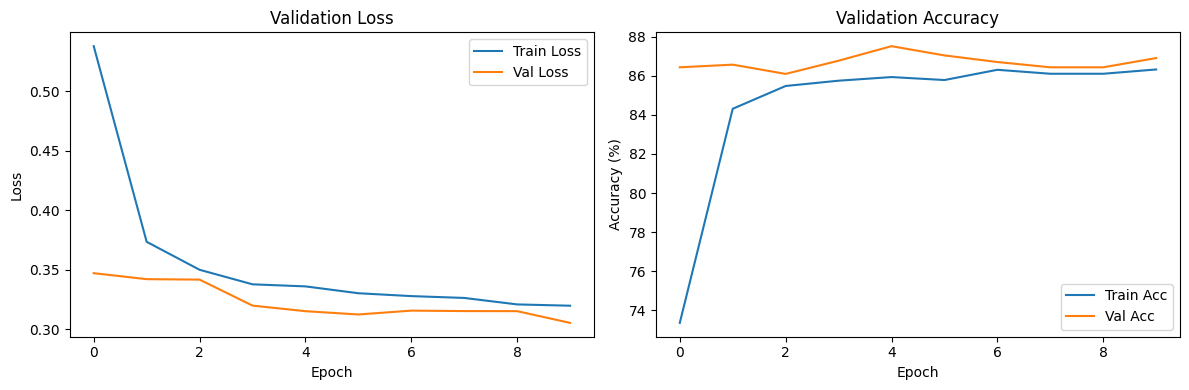

maximum accuracy:  87.51 %
high epoch:  5
Training model: large_lstm
Parameters: {'name': 'large_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.6308, Train Acc: 66.39%, Val Loss: 0.4827, Val Acc: 81.63%
Epoch [2/15], Train Loss: 0.4622, Train Acc: 80.42%, Val Loss: 0.3699, Val Acc: 86.16%
Epoch [3/15], Train Loss: 0.3916, Train Acc: 83.65%, Val Loss: 0.3406, Val Acc: 86.23%
Epoch [4/15], Train Loss: 0.3734, Train Acc: 84.63%, Val Loss: 0.3307, Val Acc: 86.56%
Epoch [5/15], Train Loss: 0.3520, Train Acc: 85.59%, Val Loss: 0.3273, Val Acc: 86.50%
Epoch [6/15], Train Loss: 0.3449, Train Acc: 85.54%, Val Loss: 0.3262, Val Acc: 86.70%
Epoch [7/15], Train Loss: 0.3432, Train Acc: 85.03%, Val Loss: 0.3298, Val Acc: 86.36%
Epoch [8/15], Train Loss: 0.3365, Train Acc: 85.66%, Val Loss: 0.3202, Val Acc: 86.56%
Epoch [9/15], Train Loss: 0.3354, Train Acc: 85.83%, Val Lo

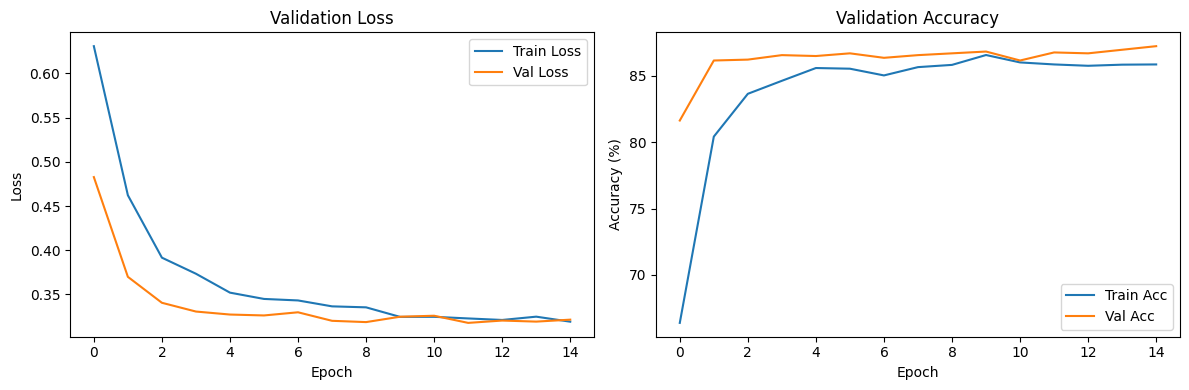

maximum accuracy:  87.24 %
high epoch:  15
Training model: small_lstm
Parameters: {'name': 'small_lstm', 'type': 'lstm', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.5094, Train Acc: 75.95%, Val Loss: 0.3432, Val Acc: 86.43%
Epoch [2/8], Train Loss: 0.3659, Train Acc: 85.41%, Val Loss: 0.3217, Val Acc: 86.90%
Epoch [3/8], Train Loss: 0.3428, Train Acc: 85.95%, Val Loss: 0.3370, Val Acc: 86.36%
Epoch [4/8], Train Loss: 0.3356, Train Acc: 85.51%, Val Loss: 0.3182, Val Acc: 86.29%
Epoch [5/8], Train Loss: 0.3354, Train Acc: 86.15%, Val Loss: 0.3249, Val Acc: 86.43%
Epoch [6/8], Train Loss: 0.3263, Train Acc: 86.17%, Val Loss: 0.3536, Val Acc: 86.77%
Epoch [7/8], Train Loss: 0.3293, Train Acc: 85.74%, Val Loss: 0.3044, Val Acc: 87.37%
Epoch [8/8], Train Loss: 0.3248, Train Acc: 86.22%, Val Loss: 0.3302, Val Acc: 86.83%


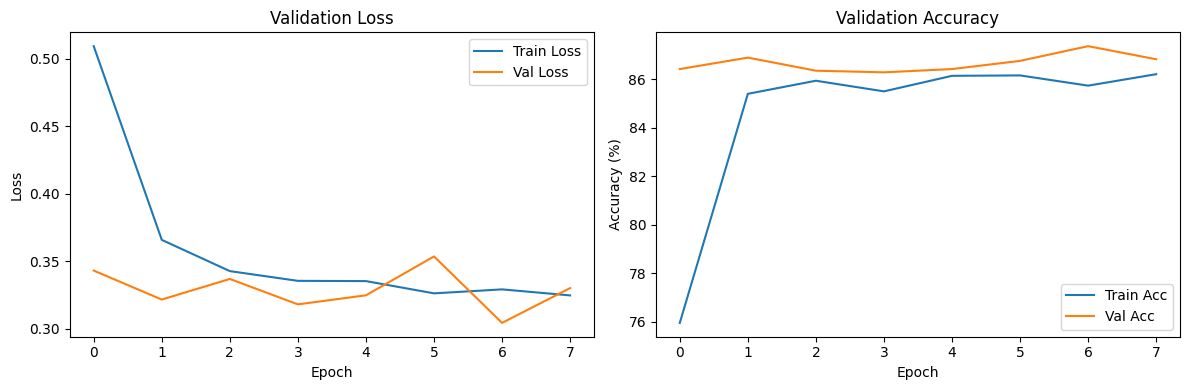

maximum accuracy:  87.37 %
high epoch:  7
Training model: deep_lstm
Parameters: {'name': 'deep_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6971, Train Acc: 60.59%, Val Loss: 0.5049, Val Acc: 82.04%
Epoch [2/20], Train Loss: 0.5368, Train Acc: 74.73%, Val Loss: 0.4063, Val Acc: 85.35%
Epoch [3/20], Train Loss: 0.4577, Train Acc: 80.74%, Val Loss: 0.3650, Val Acc: 85.62%
Epoch [4/20], Train Loss: 0.4131, Train Acc: 83.23%, Val Loss: 0.3400, Val Acc: 86.50%
Epoch [5/20], Train Loss: 0.3839, Train Acc: 84.46%, Val Loss: 0.3347, Val Acc: 86.29%
Epoch [6/20], Train Loss: 0.3724, Train Acc: 84.73%, Val Loss: 0.3295, Val Acc: 86.70%
Epoch [7/20], Train Loss: 0.3622, Train Acc: 84.49%, Val Loss: 0.3305, Val Acc: 86.29%
Epoch [8/20], Train Loss: 0.3524, Train Acc: 85.39%, Val Loss: 0.3347, Val Acc: 86.16%
Epoch [9/20], Train Loss: 0.3534, Train Acc: 85.00%, Val

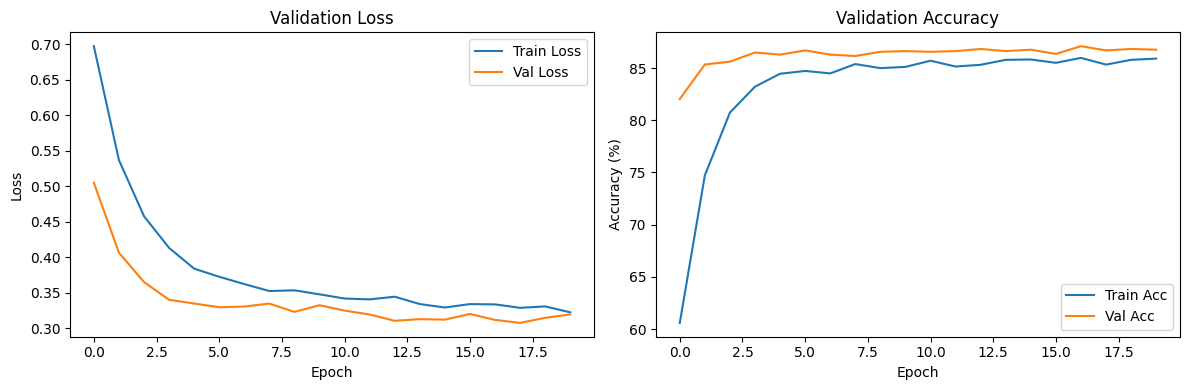

maximum accuracy:  87.1 %
high epoch:  17
Training model: fast_lstm
Parameters: {'name': 'fast_lstm', 'type': 'lstm', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5810, Train Acc: 69.68%, Val Loss: 0.3748, Val Acc: 85.96%
Epoch [2/5], Train Loss: 0.3741, Train Acc: 85.07%, Val Loss: 0.3403, Val Acc: 86.23%
Epoch [3/5], Train Loss: 0.3389, Train Acc: 85.95%, Val Loss: 0.3155, Val Acc: 86.90%
Epoch [4/5], Train Loss: 0.3274, Train Acc: 86.20%, Val Loss: 0.3835, Val Acc: 82.31%
Epoch [5/5], Train Loss: 0.3267, Train Acc: 86.13%, Val Loss: 0.3236, Val Acc: 86.23%


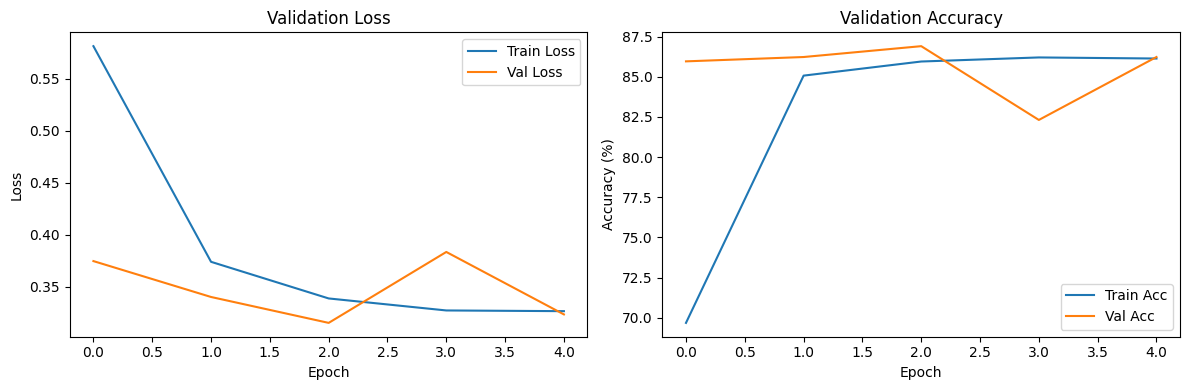

maximum accuracy:  86.9 %
high epoch:  3

Testing vectorizer: combined_base
Loading GloVe model...
Loaded 400000 word vectors
Transforming data...
Data shapes:
Train: (5920, 5100)
Val: (1481, 5100)
Test: (1851, 5100)
Training model: base_combined
Parameters: {'name': 'base_combined', 'type': 'combined', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4590, Train Acc: 79.51%, Val Loss: 0.2457, Val Acc: 92.17%
Epoch [2/10], Train Loss: 0.1811, Train Acc: 93.67%, Val Loss: 0.2515, Val Acc: 90.75%
Epoch [3/10], Train Loss: 0.0928, Train Acc: 96.98%, Val Loss: 0.2680, Val Acc: 91.02%
Epoch [4/10], Train Loss: 0.0648, Train Acc: 97.55%, Val Loss: 0.2587, Val Acc: 93.11%
Epoch [5/10], Train Loss: 0.0548, Train Acc: 97.84%, Val Loss: 0.2761, Val Acc: 91.15%
Epoch [6/10], Train Loss: 0.0541, Train Acc: 97.99%, Val Loss: 0.3151, Val Acc: 90.68%
Epoch [7/10], Train Loss: 0.0382, Train Acc: 98.56%, 

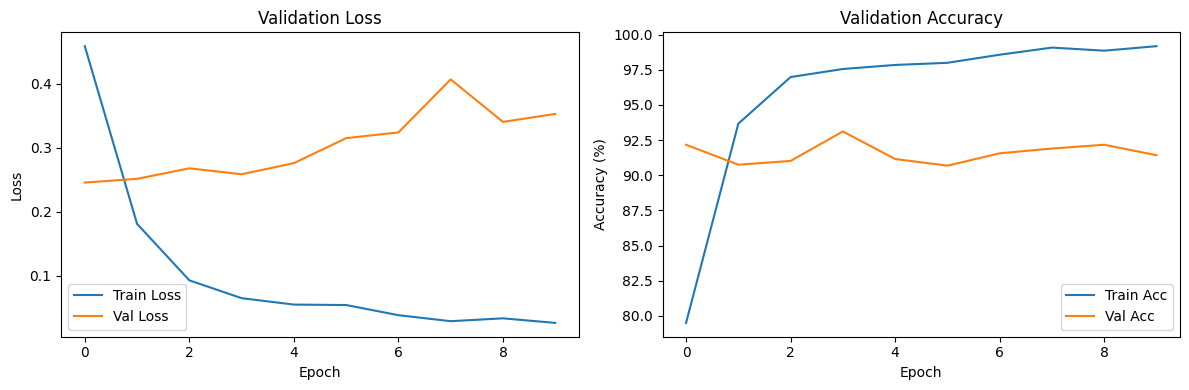

maximum accuracy:  93.11 %
high epoch:  4
Training model: large_combined
Parameters: {'name': 'large_combined', 'type': 'combined', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5675, Train Acc: 71.77%, Val Loss: 0.2998, Val Acc: 91.76%
Epoch [2/15], Train Loss: 0.3047, Train Acc: 90.51%, Val Loss: 0.2701, Val Acc: 91.02%
Epoch [3/15], Train Loss: 0.1818, Train Acc: 94.51%, Val Loss: 0.4314, Val Acc: 87.58%
Epoch [4/15], Train Loss: 0.1118, Train Acc: 96.45%, Val Loss: 0.3003, Val Acc: 90.61%
Epoch [5/15], Train Loss: 0.0997, Train Acc: 97.13%, Val Loss: 0.2963, Val Acc: 91.90%
Epoch [6/15], Train Loss: 0.0720, Train Acc: 97.67%, Val Loss: 0.3847, Val Acc: 90.48%
Epoch [7/15], Train Loss: 0.0736, Train Acc: 97.87%, Val Loss: 0.3271, Val Acc: 91.83%
Epoch [8/15], Train Loss: 0.0686, Train Acc: 97.85%, Val Loss: 0.3513, Val Acc: 91.56%
Epoch [9/15], Train Loss: 0.0564, Train Acc: 98

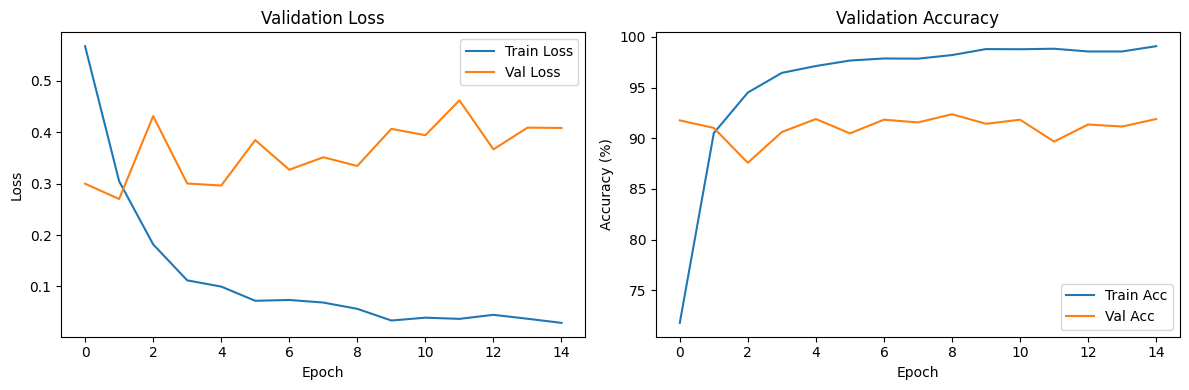

maximum accuracy:  92.37 %
high epoch:  9
Training model: small_combined
Parameters: {'name': 'small_combined', 'type': 'combined', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4605, Train Acc: 79.48%, Val Loss: 0.2887, Val Acc: 90.14%
Epoch [2/8], Train Loss: 0.1690, Train Acc: 94.46%, Val Loss: 0.2558, Val Acc: 90.48%
Epoch [3/8], Train Loss: 0.1098, Train Acc: 96.18%, Val Loss: 1.4579, Val Acc: 58.07%
Epoch [4/8], Train Loss: 0.0750, Train Acc: 97.28%, Val Loss: 0.2543, Val Acc: 91.76%
Epoch [5/8], Train Loss: 0.0586, Train Acc: 97.87%, Val Loss: 0.2884, Val Acc: 91.90%
Epoch [6/8], Train Loss: 0.0514, Train Acc: 98.11%, Val Loss: 0.2431, Val Acc: 91.90%
Epoch [7/8], Train Loss: 0.0393, Train Acc: 98.77%, Val Loss: 0.7053, Val Acc: 88.05%
Epoch [8/8], Train Loss: 0.0380, Train Acc: 98.68%, Val Loss: 0.2768, Val Acc: 92.37%


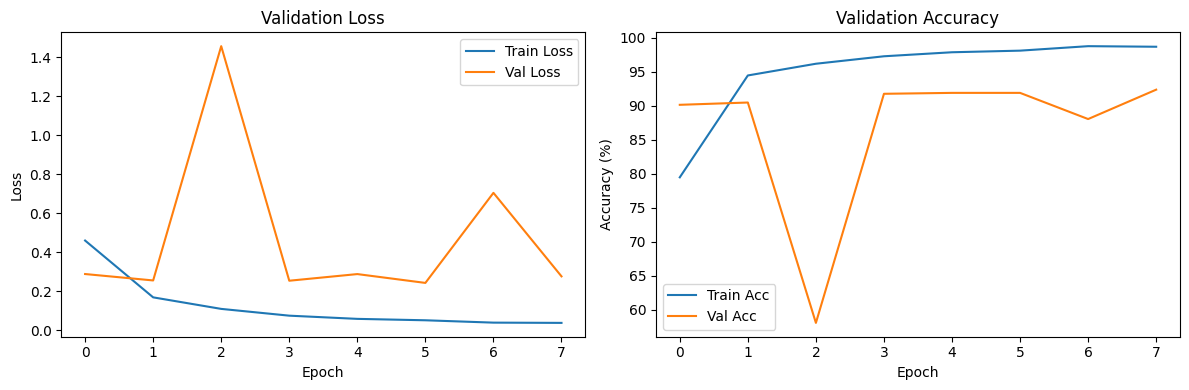

maximum accuracy:  92.37 %
high epoch:  8
Training model: deep_combined
Parameters: {'name': 'deep_combined', 'type': 'combined', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6712, Train Acc: 62.47%, Val Loss: 0.4299, Val Acc: 88.52%
Epoch [2/20], Train Loss: 0.4273, Train Acc: 83.45%, Val Loss: 0.2717, Val Acc: 91.22%
Epoch [3/20], Train Loss: 0.2868, Train Acc: 90.96%, Val Loss: 0.2462, Val Acc: 92.17%
Epoch [4/20], Train Loss: 0.2021, Train Acc: 93.56%, Val Loss: 0.2556, Val Acc: 90.95%
Epoch [5/20], Train Loss: 0.1760, Train Acc: 94.26%, Val Loss: 0.2513, Val Acc: 91.49%
Epoch [6/20], Train Loss: 0.1480, Train Acc: 95.29%, Val Loss: 0.2385, Val Acc: 91.69%
Epoch [7/20], Train Loss: 0.1301, Train Acc: 95.84%, Val Loss: 0.2364, Val Acc: 91.90%
Epoch [8/20], Train Loss: 0.1101, Train Acc: 96.42%, Val Loss: 0.2361, Val Acc: 92.78%
Epoch [9/20], Train Loss: 0.1042, Train Acc:

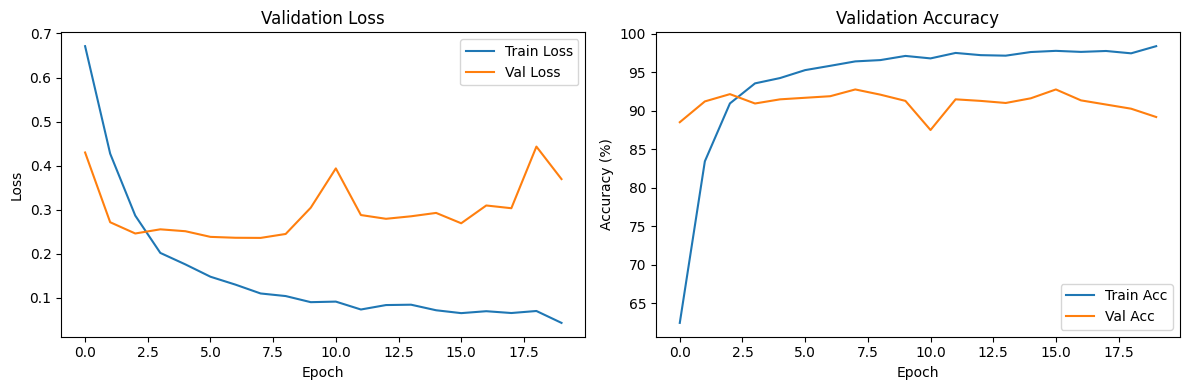

maximum accuracy:  92.78 %
high epoch:  8
Training model: fast_combined
Parameters: {'name': 'fast_combined', 'type': 'combined', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.4791, Train Acc: 78.45%, Val Loss: 0.3299, Val Acc: 88.72%
Epoch [2/5], Train Loss: 0.1558, Train Acc: 95.91%, Val Loss: 0.2094, Val Acc: 92.23%
Epoch [3/5], Train Loss: 0.0682, Train Acc: 98.24%, Val Loss: 0.2268, Val Acc: 92.91%
Epoch [4/5], Train Loss: 0.0400, Train Acc: 99.19%, Val Loss: 0.2768, Val Acc: 90.41%
Epoch [5/5], Train Loss: 0.0232, Train Acc: 99.66%, Val Loss: 0.3136, Val Acc: 91.56%


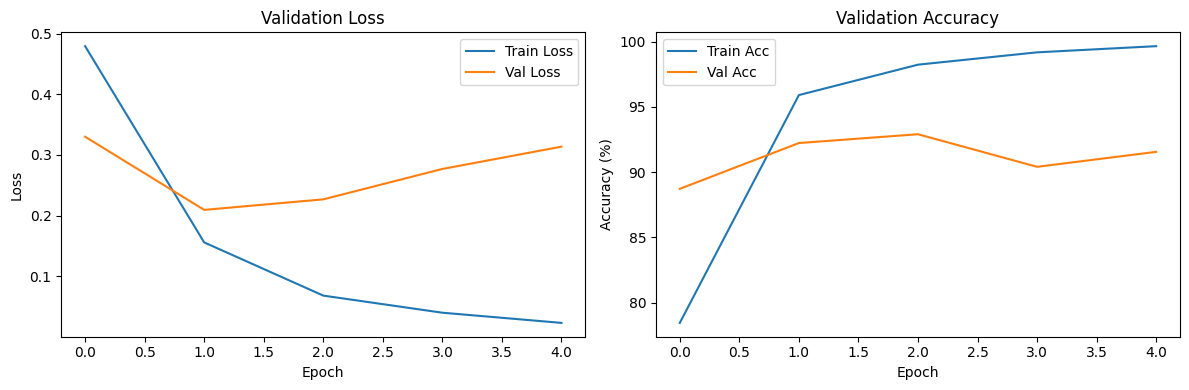

maximum accuracy:  92.91 %
high epoch:  3


OSError: 'seaborn' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.metrics import accuracy_score

def train_and_evaluate_model(model_config, X_train, train_labels, X_val, val_labels, X_test, test_df):
    """
    Train and evaluate a model with the given configuration
    """
    print(f"Training model: {model_config['name']}")
    print(f"Parameters: {model_config}")

    try:
        # Initialize the analyzer with model configuration
        analyzer = SentimentAnalyzer(
            hidden_dims=model_config['params']['hidden_dims'],
            dropout_rate=model_config['params']['dropout_rate'],
            learning_rate=model_config['params']['learning_rate'],
            batch_size=model_config['params']['batch_size'],
            num_epochs=model_config['params']['num_epochs']
        )

        # Train the model
        start_time = time.time()
        analyzer.train(X_train, train_labels, X_val, val_labels)
        training_time = time.time() - start_time

        # Make predictions
        val_predictions, val_probabilities = analyzer.predict(X_val)
        test_predictions, test_probabilities = analyzer.predict(X_test)

        # Calculate metrics
        val_accuracy = accuracy_score(val_labels, val_predictions)

        # Store results
        result = {
            'model_name': model_config['name'],
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_train_loss': analyzer.history['train_loss'][-1],
            'final_val_loss': analyzer.history['val_loss'][-1],
            'max_val_acc': max(analyzer.history['val_acc']),
            'num_epochs': model_config['params']['num_epochs'],
            'learning_rate': model_config['params']['learning_rate'],
            'test_predictions': test_predictions,
            'test_probabilities': test_probabilities
        }

        # Optional: Plot training curves
        analyzer.plot_training_history()

        return result

    except Exception as e:
        print(f"Error training model: {str(e)}")
        raise e

def run_vectorization_experiments(train_texts, test_texts, train_labels, val_texts, val_labels, test_df):
    all_results = []

    for vec_name, vec_config in vectorizer_configs.items():
        print(f"\nTesting vectorizer: {vec_name}")

        try:
            # Initialize vectorizer
            vectorizer = get_vectorizer(vec_config)

            # Transform data
            print("Transforming data...")
            X_train = vectorizer.fit_transform(train_texts)
            X_val = vectorizer.transform(val_texts)
            X_test = vectorizer.transform(test_texts)

            # Convert sparse matrices to dense if necessary
            if scipy.sparse.issparse(X_train):
                X_train = X_train.toarray()
                X_val = X_val.toarray()
                X_test = X_test.toarray()

            print(f"Data shapes:")
            print(f"Train: {X_train.shape}")
            print(f"Val: {X_val.shape}")
            print(f"Test: {X_test.shape}")

            # Get model configs for this vectorizer
            model_configs_for_method = model_configs[f"{vec_config['method']}_configs"]

            # Train models with this vectorization
            for model_config in model_configs_for_method:
                try:
                    result = train_and_evaluate_model(
                        model_config, X_train, train_labels,
                        X_val, val_labels, X_test, test_df
                    )
                    result['vectorizer'] = vec_name
                    all_results.append(result)
                except Exception as e:
                    print(f"Error with model {model_config['name']}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error with vectorizer {vec_name}: {str(e)}")
            continue


    results_df = pd.DataFrame(all_results)

    # Plot overall results
    plot_comprehensive_results(results_df)

    return results_df

# Example usage
if __name__ == "__main__":
    # Load data
    train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
    test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_df['reviews'],
        train_df['sentiments'],
        test_size=0.2,
        random_state=42
    )

    # Run experiments
    results_df = run_vectorization_experiments(
        train_texts, test_df['reviews'],
        train_labels, val_texts, val_labels,
        test_df
    )

    # Save results
    results_df.to_csv('vectorization_comparison_results.csv', index=False)

    # Print summary
    print("\nBest Models:")
    print(results_df.sort_values('val_accuracy', ascending=False)[
        ['vectorizer', 'model_name', 'val_accuracy', 'training_time']
    ].head())

In [ ]:
%%capture
!pip install numpy pandas scipy scikit-learn torch matplotlib seaborn tqdm

In [ ]:
# Cell 2: Imports
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:

# Cell 3: Define training function
def train_and_evaluate_model(model_config, X_train, train_labels, X_val, val_labels, X_test, test_df):
    """
    Train and evaluate a model with the given configuration
    """
    print(f"Training model: {model_config['name']}")
    print(f"Parameters: {model_config}")

    try:
        # Initialize the analyzer with model configuration
        analyzer = SentimentAnalyzer(
            hidden_dims=model_config['params']['hidden_dims'],
            dropout_rate=model_config['params']['dropout_rate'],
            learning_rate=model_config['params']['learning_rate'],
            batch_size=model_config['params']['batch_size'],
            num_epochs=model_config['params']['num_epochs']
        )

        # Train the model
        start_time = time.time()
        analyzer.train(X_train, train_labels, X_val, val_labels)
        training_time = time.time() - start_time

        # Make predictions
        val_predictions, val_probabilities = analyzer.predict(X_val)
        test_predictions, test_probabilities = analyzer.predict(X_test)

        # Calculate metrics
        val_accuracy = accuracy_score(val_labels, val_predictions)

        # Store results
        result = {
            'model_name': model_config['name'],
            'val_accuracy': val_accuracy,
            'training_time': training_time,
            'final_train_loss': analyzer.history['train_loss'][-1],
            'final_val_loss': analyzer.history['val_loss'][-1],
            'max_val_acc': max(analyzer.history['val_acc']),
            'num_epochs': model_config['params']['num_epochs'],
            'learning_rate': model_config['params']['learning_rate'],
            'test_predictions': test_predictions,
            'test_probabilities': test_probabilities
        }

        # Optional: Plot training curves
        analyzer.plot_training_history()

        return result

    except Exception as e:
        print(f"Error training model: {str(e)}")
        raise e

In [ ]:
# Cell 4: Define experiment function
def run_vectorization_experiments(train_texts, test_texts, train_labels, val_texts, val_labels, test_df):
    all_results = []

    for vec_name, vec_config in tqdm(vectorizer_configs.items(), desc="Testing vectorizers"):
        print(f"\nTesting vectorizer: {vec_name}")

        try:
            # Initialize vectorizer
            vectorizer = get_vectorizer(vec_config)

            # Transform data
            print("Transforming data...")
            X_train = vectorizer.fit_transform(train_texts)
            X_val = vectorizer.transform(val_texts)
            X_test = vectorizer.transform(test_texts)

            # Convert sparse matrices to dense if necessary
            if sparse.issparse(X_train):
                X_train = X_train.toarray()
                X_val = X_val.toarray()
                X_test = X_test.toarray()

            print(f"Data shapes:")
            print(f"Train: {X_train.shape}")
            print(f"Val: {X_val.shape}")
            print(f"Test: {X_test.shape}")

            # Get model configs for this vectorizer
            model_configs_for_method = model_configs[f"{vec_config['method']}_configs"]

            # Train models with this vectorization
            for model_config in tqdm(model_configs_for_method, desc=f"Training {vec_name} models"):
                try:
                    result = train_and_evaluate_model(
                        model_config, X_train, train_labels,
                        X_val, val_labels, X_test, test_df
                    )
                    result['vectorizer'] = vec_name
                    all_results.append(result)
                except Exception as e:
                    print(f"Error with model {model_config['name']}: {str(e)}")
                    continue

        except Exception as e:
            print(f"Error with vectorizer {vec_name}: {str(e)}")
            continue

    return pd.DataFrame(all_results)


In [ ]:
# Cell 5: Load and prepare data
# Mount Google Drive if using Colab

# Load data
train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['reviews'],
    train_df['sentiments'],
    test_size=0.2,
    random_state=42
)




Testing vectorizers:   0%|          | 0/5 [00:00<?, ?it/s]


Testing vectorizer: glove_base
Loading GloVe model...
Loaded 400000 word vectors
Transforming data...
Data shapes:
Train: (5920, 100)
Val: (1481, 100)
Test: (1851, 100)


Training glove_base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: base_lstm
Parameters: {'name': 'base_lstm', 'type': 'lstm', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.5031, Train Acc: 76.13%, Val Loss: 0.3926, Val Acc: 84.20%
Epoch [2/10], Train Loss: 0.3432, Train Acc: 86.15%, Val Loss: 0.3031, Val Acc: 87.58%
Epoch [3/10], Train Loss: 0.3187, Train Acc: 87.04%, Val Loss: 0.3090, Val Acc: 86.97%
Epoch [4/10], Train Loss: 0.3018, Train Acc: 87.47%, Val Loss: 0.3091, Val Acc: 87.17%
Epoch [5/10], Train Loss: 0.2906, Train Acc: 88.01%, Val Loss: 0.3126, Val Acc: 86.97%
Epoch [6/10], Train Loss: 0.2858, Train Acc: 87.97%, Val Loss: 0.2926, Val Acc: 88.52%
Epoch [7/10], Train Loss: 0.2764, Train Acc: 88.31%, Val Loss: 0.2967, Val Acc: 88.59%
Epoch [8/10], Train Loss: 0.2787, Train Acc: 88.41%, Val Loss: 0.3120, Val Acc: 86.97%
Epoch [9/10], Train Loss: 0.2655, Train Acc: 88.60%, Val Loss: 0.2981, Val Acc: 87.58%
Epoch [10/10], Train 

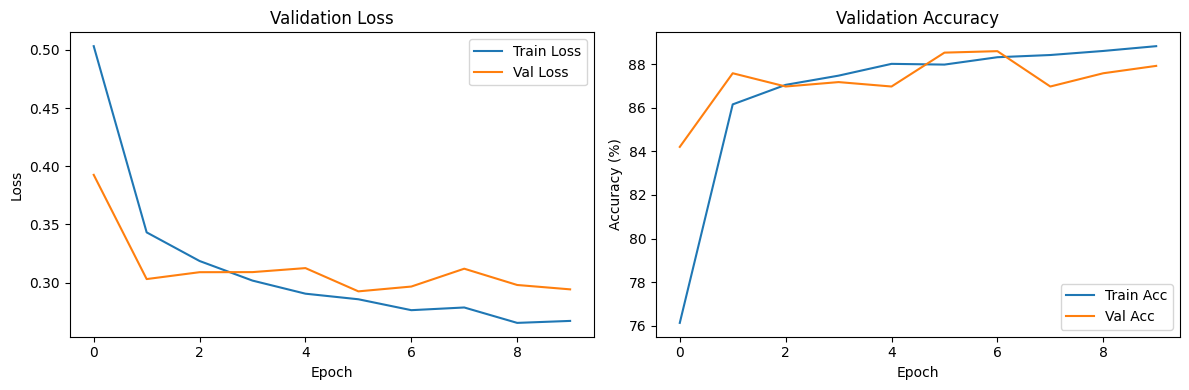

maximum accuracy:  88.59 %
high epoch:  7
Training model: large_lstm
Parameters: {'name': 'large_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.6062, Train Acc: 68.18%, Val Loss: 0.4324, Val Acc: 85.75%
Epoch [2/15], Train Loss: 0.4343, Train Acc: 82.11%, Val Loss: 0.3561, Val Acc: 87.10%
Epoch [3/15], Train Loss: 0.3656, Train Acc: 85.00%, Val Loss: 0.3359, Val Acc: 86.23%
Epoch [4/15], Train Loss: 0.3344, Train Acc: 86.37%, Val Loss: 0.3024, Val Acc: 87.78%
Epoch [5/15], Train Loss: 0.3213, Train Acc: 86.49%, Val Loss: 0.2997, Val Acc: 88.25%
Epoch [6/15], Train Loss: 0.3045, Train Acc: 87.36%, Val Loss: 0.3209, Val Acc: 86.36%
Epoch [7/15], Train Loss: 0.3029, Train Acc: 87.57%, Val Loss: 0.3033, Val Acc: 87.98%
Epoch [8/15], Train Loss: 0.2931, Train Acc: 87.62%, Val Loss: 0.3318, Val Acc: 85.96%
Epoch [9/15], Train Loss: 0.2887, Train Acc: 87.91%, Val Lo

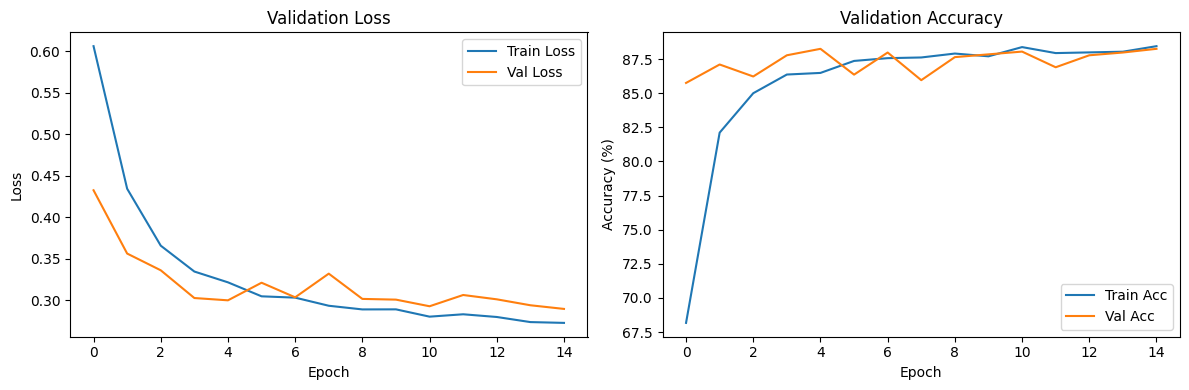

maximum accuracy:  88.25 %
high epoch:  5
Training model: small_lstm
Parameters: {'name': 'small_lstm', 'type': 'lstm', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.5347, Train Acc: 74.34%, Val Loss: 0.3217, Val Acc: 88.18%
Epoch [2/8], Train Loss: 0.3411, Train Acc: 86.28%, Val Loss: 0.3102, Val Acc: 87.31%
Epoch [3/8], Train Loss: 0.3075, Train Acc: 87.28%, Val Loss: 0.3164, Val Acc: 87.58%
Epoch [4/8], Train Loss: 0.3041, Train Acc: 86.81%, Val Loss: 0.2989, Val Acc: 88.12%
Epoch [5/8], Train Loss: 0.2896, Train Acc: 87.55%, Val Loss: 0.3042, Val Acc: 87.44%
Epoch [6/8], Train Loss: 0.2856, Train Acc: 87.62%, Val Loss: 0.3050, Val Acc: 87.10%
Epoch [7/8], Train Loss: 0.2787, Train Acc: 88.11%, Val Loss: 0.2977, Val Acc: 87.85%
Epoch [8/8], Train Loss: 0.2699, Train Acc: 88.68%, Val Loss: 0.3310, Val Acc: 86.97%


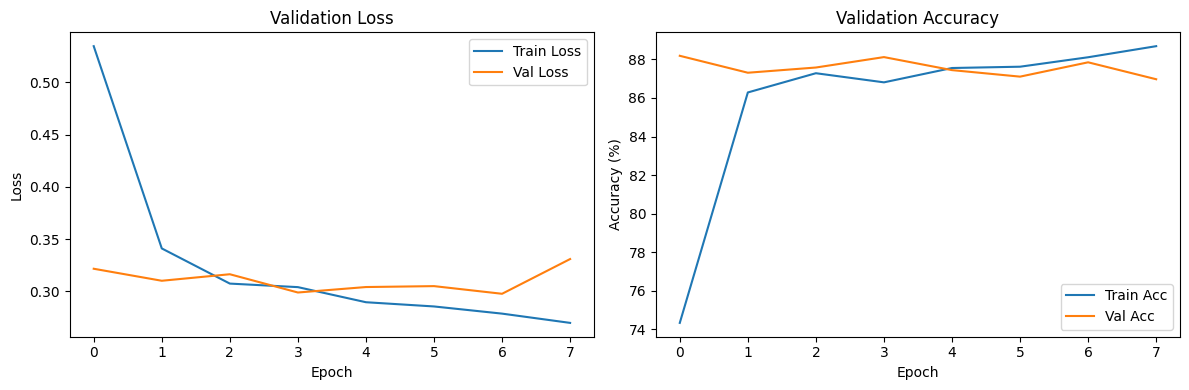

maximum accuracy:  88.18 %
high epoch:  1
Training model: deep_lstm
Parameters: {'name': 'deep_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6492, Train Acc: 62.36%, Val Loss: 0.5402, Val Acc: 82.04%
Epoch [2/20], Train Loss: 0.4924, Train Acc: 77.60%, Val Loss: 0.4130, Val Acc: 87.98%
Epoch [3/20], Train Loss: 0.4133, Train Acc: 83.38%, Val Loss: 0.3486, Val Acc: 87.31%
Epoch [4/20], Train Loss: 0.3719, Train Acc: 84.78%, Val Loss: 0.3256, Val Acc: 87.51%
Epoch [5/20], Train Loss: 0.3457, Train Acc: 85.81%, Val Loss: 0.3087, Val Acc: 88.45%
Epoch [6/20], Train Loss: 0.3337, Train Acc: 86.06%, Val Loss: 0.3050, Val Acc: 87.37%
Epoch [7/20], Train Loss: 0.3203, Train Acc: 86.35%, Val Loss: 0.2956, Val Acc: 87.91%
Epoch [8/20], Train Loss: 0.3145, Train Acc: 86.54%, Val Loss: 0.2942, Val Acc: 87.91%
Epoch [9/20], Train Loss: 0.3094, Train Acc: 86.79%, Val

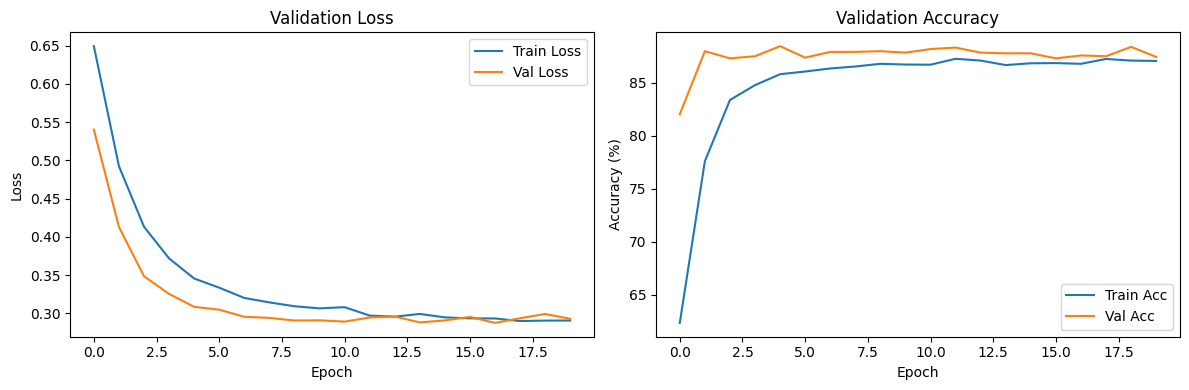

maximum accuracy:  88.45 %
high epoch:  5
Training model: fast_lstm
Parameters: {'name': 'fast_lstm', 'type': 'lstm', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5795, Train Acc: 69.31%, Val Loss: 0.4194, Val Acc: 87.10%
Epoch [2/5], Train Loss: 0.3431, Train Acc: 86.84%, Val Loss: 0.2944, Val Acc: 87.37%
Epoch [3/5], Train Loss: 0.2999, Train Acc: 87.03%, Val Loss: 0.2984, Val Acc: 87.37%
Epoch [4/5], Train Loss: 0.2930, Train Acc: 87.42%, Val Loss: 0.2852, Val Acc: 88.25%
Epoch [5/5], Train Loss: 0.2873, Train Acc: 87.65%, Val Loss: 0.3443, Val Acc: 86.97%


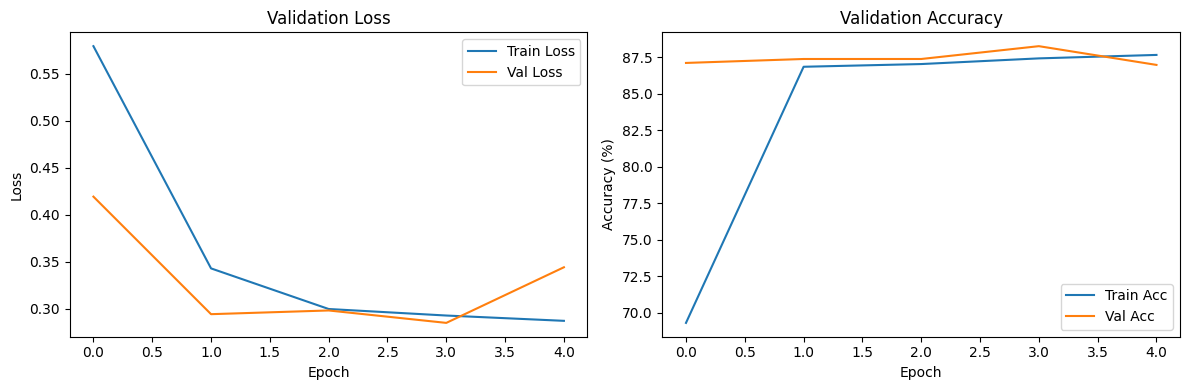

maximum accuracy:  88.25 %
high epoch:  4

Testing vectorizer: tfidf_base
Transforming data...
Data shapes:
Train: (5920, 5000)
Val: (1481, 5000)
Test: (1851, 5000)


Training tfidf_base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: base_mlp
Parameters: {'name': 'base_mlp', 'type': 'mlp', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4706, Train Acc: 79.68%, Val Loss: 0.2644, Val Acc: 90.88%
Epoch [2/10], Train Loss: 0.1531, Train Acc: 94.75%, Val Loss: 0.2126, Val Acc: 92.57%
Epoch [3/10], Train Loss: 0.0720, Train Acc: 97.67%, Val Loss: 0.2691, Val Acc: 92.03%
Epoch [4/10], Train Loss: 0.0454, Train Acc: 98.58%, Val Loss: 0.3161, Val Acc: 91.36%
Epoch [5/10], Train Loss: 0.0371, Train Acc: 98.77%, Val Loss: 0.3294, Val Acc: 91.63%
Epoch [6/10], Train Loss: 0.0381, Train Acc: 98.68%, Val Loss: 0.3159, Val Acc: 92.30%
Epoch [7/10], Train Loss: 0.0292, Train Acc: 98.89%, Val Loss: 0.3350, Val Acc: 92.17%
Epoch [8/10], Train Loss: 0.0324, Train Acc: 98.80%, Val Loss: 0.3393, Val Acc: 91.83%
Epoch [9/10], Train Loss: 0.0216, Train Acc: 99.22%, Val Loss: 0.3429, Val Acc: 92.30%
Epoch [10/10], Train Los

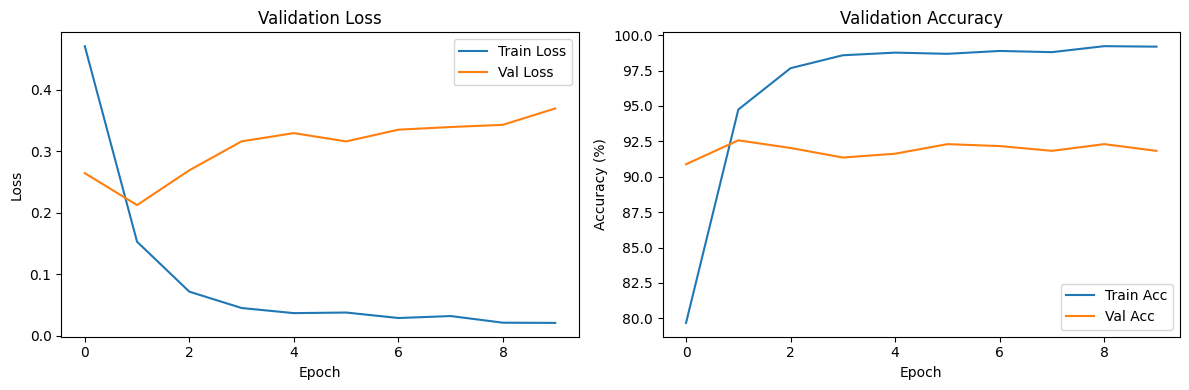

maximum accuracy:  92.57 %
high epoch:  2
Training model: large_mlp
Parameters: {'name': 'large_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5218, Train Acc: 75.76%, Val Loss: 0.2712, Val Acc: 91.76%
Epoch [2/15], Train Loss: 0.2435, Train Acc: 93.31%, Val Loss: 0.2773, Val Acc: 91.02%
Epoch [3/15], Train Loss: 0.1192, Train Acc: 96.33%, Val Loss: 0.2914, Val Acc: 92.44%
Epoch [4/15], Train Loss: 0.0729, Train Acc: 97.92%, Val Loss: 0.3019, Val Acc: 92.10%
Epoch [5/15], Train Loss: 0.0560, Train Acc: 98.33%, Val Loss: 0.3166, Val Acc: 92.03%
Epoch [6/15], Train Loss: 0.0452, Train Acc: 98.53%, Val Loss: 0.3447, Val Acc: 91.96%
Epoch [7/15], Train Loss: 0.0235, Train Acc: 99.16%, Val Loss: 0.3662, Val Acc: 91.69%
Epoch [8/15], Train Loss: 0.0241, Train Acc: 99.29%, Val Loss: 0.3812, Val Acc: 92.17%
Epoch [9/15], Train Loss: 0.0307, Train Acc: 99.07%, Val Loss

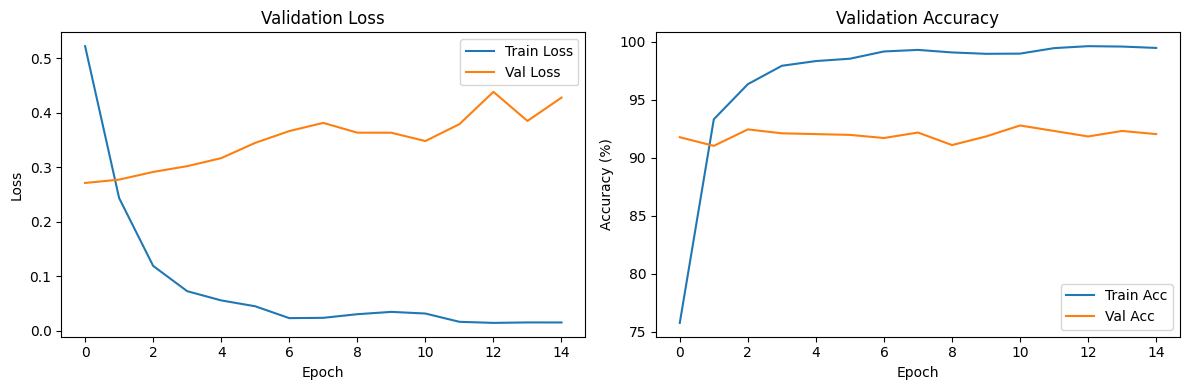

maximum accuracy:  92.78 %
high epoch:  11
Training model: small_mlp
Parameters: {'name': 'small_mlp', 'type': 'mlp', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4821, Train Acc: 78.11%, Val Loss: 0.2777, Val Acc: 91.49%
Epoch [2/8], Train Loss: 0.1464, Train Acc: 95.52%, Val Loss: 0.2405, Val Acc: 91.83%
Epoch [3/8], Train Loss: 0.0661, Train Acc: 97.92%, Val Loss: 0.2580, Val Acc: 91.76%
Epoch [4/8], Train Loss: 0.0349, Train Acc: 98.85%, Val Loss: 0.2938, Val Acc: 91.49%
Epoch [5/8], Train Loss: 0.0249, Train Acc: 99.19%, Val Loss: 0.3042, Val Acc: 91.49%
Epoch [6/8], Train Loss: 0.0267, Train Acc: 99.07%, Val Loss: 0.3128, Val Acc: 92.23%
Epoch [7/8], Train Loss: 0.0304, Train Acc: 98.90%, Val Loss: 0.3208, Val Acc: 91.96%
Epoch [8/8], Train Loss: 0.0256, Train Acc: 99.26%, Val Loss: 0.3320, Val Acc: 91.90%


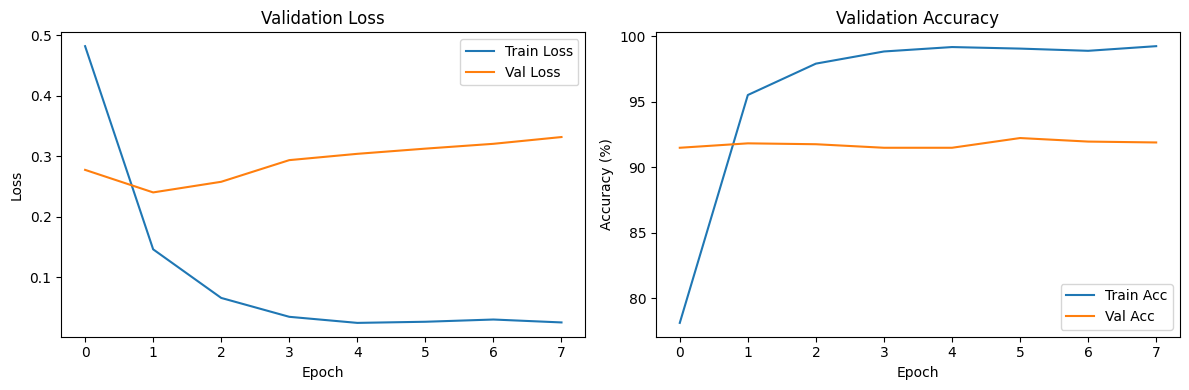

maximum accuracy:  92.23 %
high epoch:  6
Training model: deep_mlp
Parameters: {'name': 'deep_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6751, Train Acc: 62.15%, Val Loss: 0.4526, Val Acc: 89.26%
Epoch [2/20], Train Loss: 0.4496, Train Acc: 82.25%, Val Loss: 0.2689, Val Acc: 92.57%
Epoch [3/20], Train Loss: 0.2696, Train Acc: 92.09%, Val Loss: 0.2423, Val Acc: 92.03%
Epoch [4/20], Train Loss: 0.1736, Train Acc: 94.95%, Val Loss: 0.2527, Val Acc: 91.09%
Epoch [5/20], Train Loss: 0.1447, Train Acc: 95.51%, Val Loss: 0.2725, Val Acc: 90.95%
Epoch [6/20], Train Loss: 0.1112, Train Acc: 96.55%, Val Loss: 0.2478, Val Acc: 91.69%
Epoch [7/20], Train Loss: 0.0941, Train Acc: 97.48%, Val Loss: 0.2897, Val Acc: 90.95%
Epoch [8/20], Train Loss: 0.0886, Train Acc: 97.47%, Val Loss: 0.2858, Val Acc: 91.15%
Epoch [9/20], Train Loss: 0.0651, Train Acc: 98.16%, 

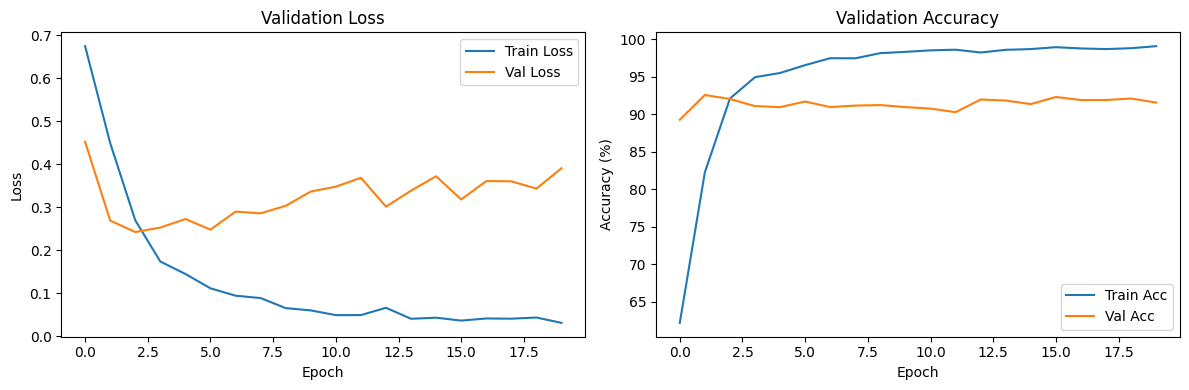

maximum accuracy:  92.57 %
high epoch:  2
Training model: fast_mlp
Parameters: {'name': 'fast_mlp', 'type': 'mlp', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5042, Train Acc: 78.18%, Val Loss: 0.4054, Val Acc: 88.52%
Epoch [2/5], Train Loss: 0.1158, Train Acc: 97.25%, Val Loss: 0.2139, Val Acc: 92.44%
Epoch [3/5], Train Loss: 0.0252, Train Acc: 99.76%, Val Loss: 0.2467, Val Acc: 92.84%
Epoch [4/5], Train Loss: 0.0095, Train Acc: 99.85%, Val Loss: 0.2639, Val Acc: 92.57%
Epoch [5/5], Train Loss: 0.0047, Train Acc: 100.00%, Val Loss: 0.2835, Val Acc: 92.84%


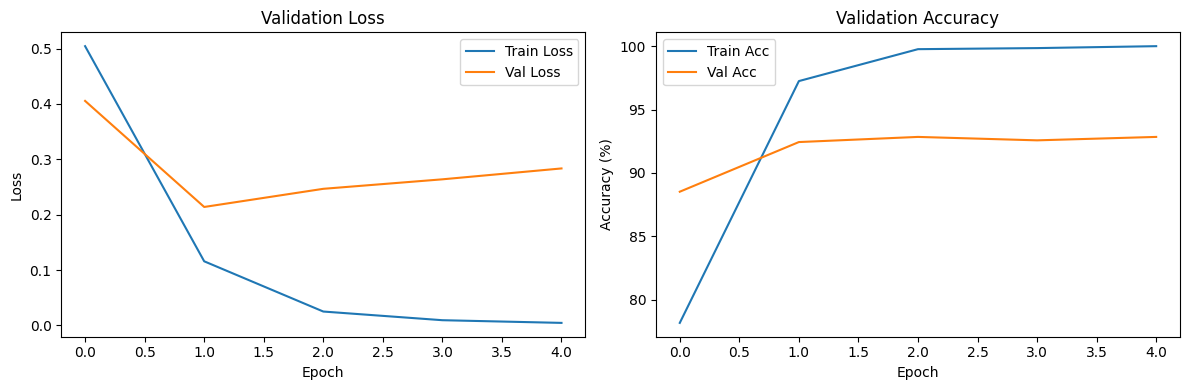

maximum accuracy:  92.84 %
high epoch:  3

Testing vectorizer: count_base
Transforming data...
Data shapes:
Train: (5920, 5000)
Val: (1481, 5000)
Test: (1851, 5000)


Training count_base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: base_mlp
Parameters: {'name': 'base_mlp', 'type': 'mlp', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4648, Train Acc: 79.38%, Val Loss: 0.2494, Val Acc: 92.78%
Epoch [2/10], Train Loss: 0.1747, Train Acc: 94.19%, Val Loss: 0.2227, Val Acc: 91.56%
Epoch [3/10], Train Loss: 0.0916, Train Acc: 97.13%, Val Loss: 0.2343, Val Acc: 92.78%
Epoch [4/10], Train Loss: 0.0588, Train Acc: 97.96%, Val Loss: 0.2589, Val Acc: 92.23%
Epoch [5/10], Train Loss: 0.0487, Train Acc: 98.31%, Val Loss: 0.3049, Val Acc: 91.49%
Epoch [6/10], Train Loss: 0.0367, Train Acc: 98.63%, Val Loss: 0.2924, Val Acc: 92.30%
Epoch [7/10], Train Loss: 0.0339, Train Acc: 98.87%, Val Loss: 0.2792, Val Acc: 91.96%
Epoch [8/10], Train Loss: 0.0243, Train Acc: 99.17%, Val Loss: 0.2985, Val Acc: 92.37%
Epoch [9/10], Train Loss: 0.0219, Train Acc: 99.29%, Val Loss: 0.3051, Val Acc: 92.71%
Epoch [10/10], Train Los

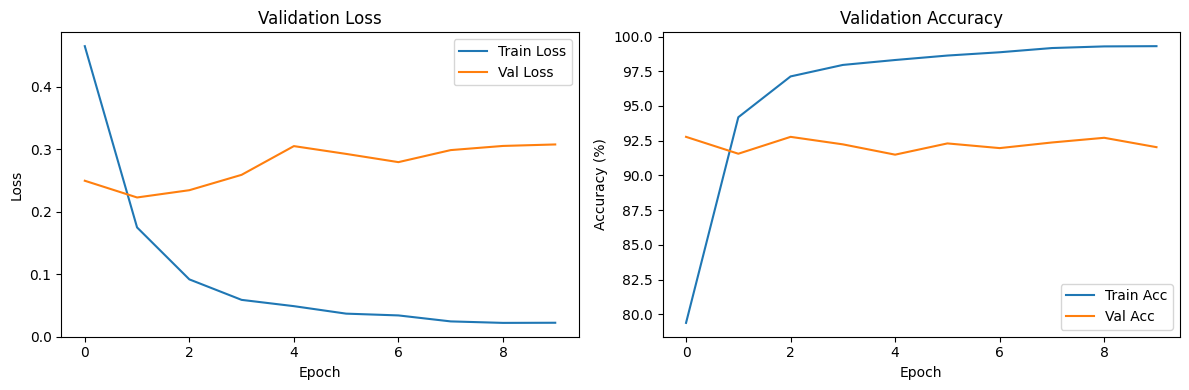

maximum accuracy:  92.78 %
high epoch:  1
Training model: large_mlp
Parameters: {'name': 'large_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5580, Train Acc: 74.07%, Val Loss: 0.3559, Val Acc: 89.13%
Epoch [2/15], Train Loss: 0.2468, Train Acc: 92.48%, Val Loss: 0.2437, Val Acc: 91.90%
Epoch [3/15], Train Loss: 0.1160, Train Acc: 96.49%, Val Loss: 0.2736, Val Acc: 92.10%
Epoch [4/15], Train Loss: 0.0822, Train Acc: 97.75%, Val Loss: 0.3038, Val Acc: 92.03%
Epoch [5/15], Train Loss: 0.0646, Train Acc: 97.99%, Val Loss: 0.3023, Val Acc: 91.90%
Epoch [6/15], Train Loss: 0.0434, Train Acc: 98.68%, Val Loss: 0.3124, Val Acc: 92.23%
Epoch [7/15], Train Loss: 0.0336, Train Acc: 98.94%, Val Loss: 0.3399, Val Acc: 91.96%
Epoch [8/15], Train Loss: 0.0384, Train Acc: 98.83%, Val Loss: 0.3417, Val Acc: 92.10%
Epoch [9/15], Train Loss: 0.0304, Train Acc: 99.02%, Val Loss

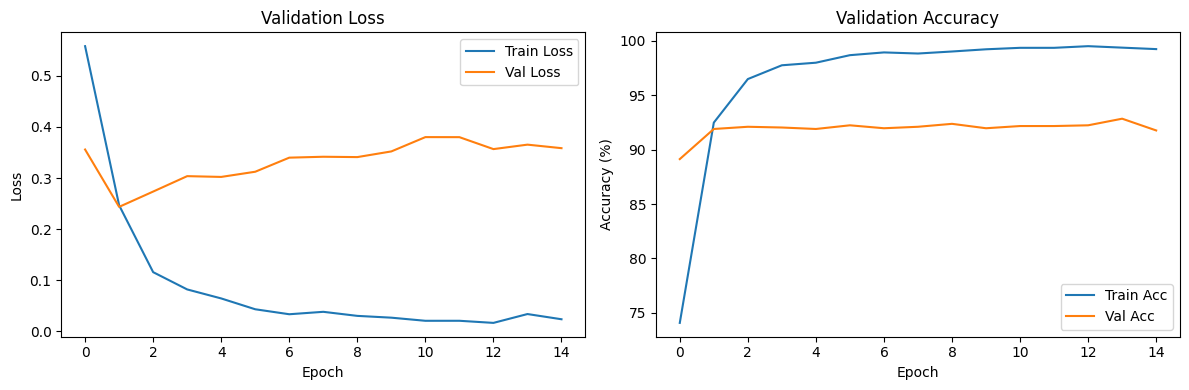

maximum accuracy:  92.84 %
high epoch:  14
Training model: small_mlp
Parameters: {'name': 'small_mlp', 'type': 'mlp', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4834, Train Acc: 78.75%, Val Loss: 0.2780, Val Acc: 90.88%
Epoch [2/8], Train Loss: 0.1762, Train Acc: 94.44%, Val Loss: 0.2257, Val Acc: 91.36%
Epoch [3/8], Train Loss: 0.0934, Train Acc: 96.89%, Val Loss: 0.2164, Val Acc: 91.56%
Epoch [4/8], Train Loss: 0.0571, Train Acc: 98.23%, Val Loss: 0.2498, Val Acc: 91.96%
Epoch [5/8], Train Loss: 0.0351, Train Acc: 98.82%, Val Loss: 0.2764, Val Acc: 92.23%
Epoch [6/8], Train Loss: 0.0325, Train Acc: 98.99%, Val Loss: 0.2922, Val Acc: 91.96%
Epoch [7/8], Train Loss: 0.0249, Train Acc: 99.10%, Val Loss: 0.3188, Val Acc: 91.36%
Epoch [8/8], Train Loss: 0.0199, Train Acc: 99.36%, Val Loss: 0.3413, Val Acc: 92.17%


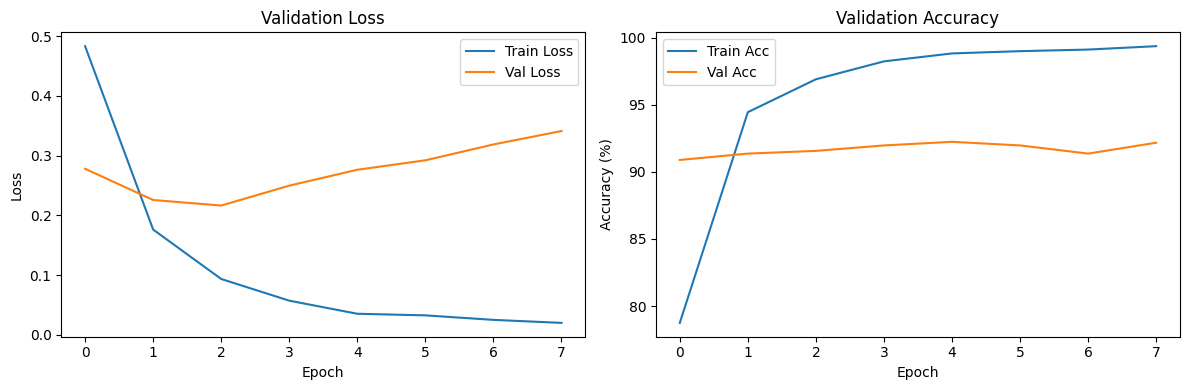

maximum accuracy:  92.23 %
high epoch:  5
Training model: deep_mlp
Parameters: {'name': 'deep_mlp', 'type': 'mlp', 'params': {'hidden_dims': [1024, 512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6854, Train Acc: 62.04%, Val Loss: 0.4837, Val Acc: 85.82%
Epoch [2/20], Train Loss: 0.4836, Train Acc: 79.31%, Val Loss: 0.2947, Val Acc: 90.28%
Epoch [3/20], Train Loss: 0.3382, Train Acc: 88.11%, Val Loss: 0.2419, Val Acc: 91.15%
Epoch [4/20], Train Loss: 0.2274, Train Acc: 92.35%, Val Loss: 0.2362, Val Acc: 91.22%
Epoch [5/20], Train Loss: 0.1736, Train Acc: 94.54%, Val Loss: 0.2393, Val Acc: 91.56%
Epoch [6/20], Train Loss: 0.1215, Train Acc: 95.96%, Val Loss: 0.2597, Val Acc: 91.09%
Epoch [7/20], Train Loss: 0.1005, Train Acc: 96.96%, Val Loss: 0.2930, Val Acc: 90.75%
Epoch [8/20], Train Loss: 0.0961, Train Acc: 96.98%, Val Loss: 0.2528, Val Acc: 92.10%
Epoch [9/20], Train Loss: 0.0742, Train Acc: 97.79%, 

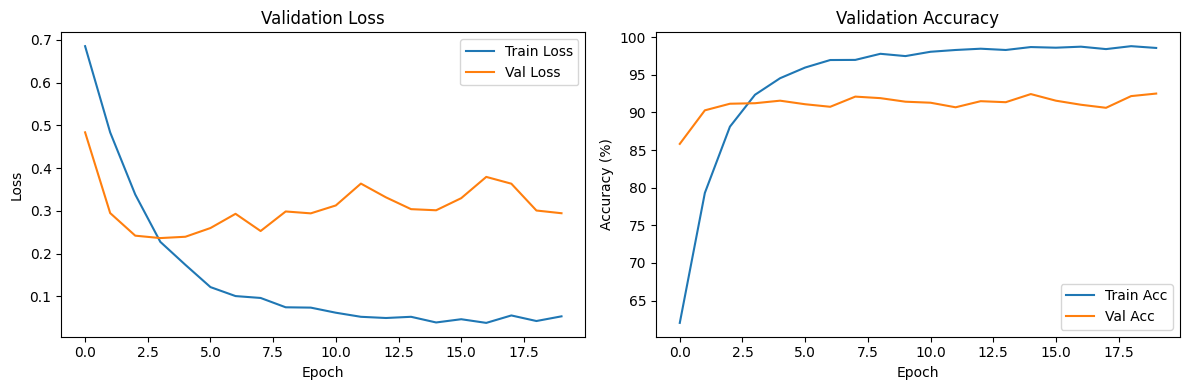

maximum accuracy:  92.51 %
high epoch:  20
Training model: fast_mlp
Parameters: {'name': 'fast_mlp', 'type': 'mlp', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5599, Train Acc: 75.88%, Val Loss: 0.3527, Val Acc: 92.03%
Epoch [2/5], Train Loss: 0.1895, Train Acc: 95.91%, Val Loss: 0.2386, Val Acc: 91.90%
Epoch [3/5], Train Loss: 0.0536, Train Acc: 99.00%, Val Loss: 0.2255, Val Acc: 91.83%
Epoch [4/5], Train Loss: 0.0195, Train Acc: 99.66%, Val Loss: 0.2334, Val Acc: 92.30%
Epoch [5/5], Train Loss: 0.0092, Train Acc: 99.93%, Val Loss: 0.2443, Val Acc: 92.17%


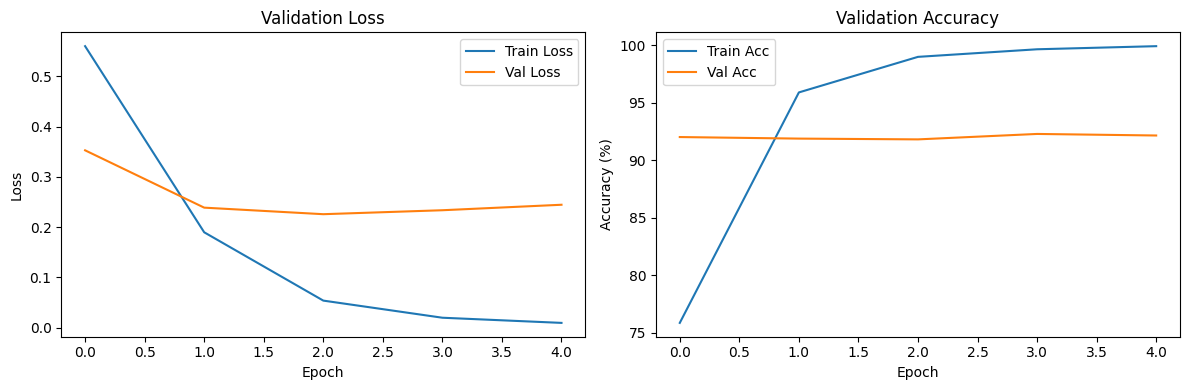

maximum accuracy:  92.3 %
high epoch:  4

Testing vectorizer: word2vec_base
Transforming data...
Data shapes:
Train: (5920, 100)
Val: (1481, 100)
Test: (1851, 100)


Training word2vec_base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: base_lstm
Parameters: {'name': 'base_lstm', 'type': 'lstm', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.5209, Train Acc: 74.65%, Val Loss: 0.3486, Val Acc: 85.96%
Epoch [2/10], Train Loss: 0.3665, Train Acc: 84.53%, Val Loss: 0.3377, Val Acc: 85.75%
Epoch [3/10], Train Loss: 0.3534, Train Acc: 85.22%, Val Loss: 0.3378, Val Acc: 86.02%
Epoch [4/10], Train Loss: 0.3349, Train Acc: 85.59%, Val Loss: 0.3182, Val Acc: 86.77%
Epoch [5/10], Train Loss: 0.3336, Train Acc: 85.81%, Val Loss: 0.3350, Val Acc: 86.70%
Epoch [6/10], Train Loss: 0.3315, Train Acc: 85.78%, Val Loss: 0.3114, Val Acc: 86.97%
Epoch [7/10], Train Loss: 0.3274, Train Acc: 85.88%, Val Loss: 0.3109, Val Acc: 87.10%
Epoch [8/10], Train Loss: 0.3279, Train Acc: 85.64%, Val Loss: 0.3031, Val Acc: 87.17%
Epoch [9/10], Train Loss: 0.3271, Train Acc: 85.52%, Val Loss: 0.3265, Val Acc: 86.63%
Epoch [10/10], Train 

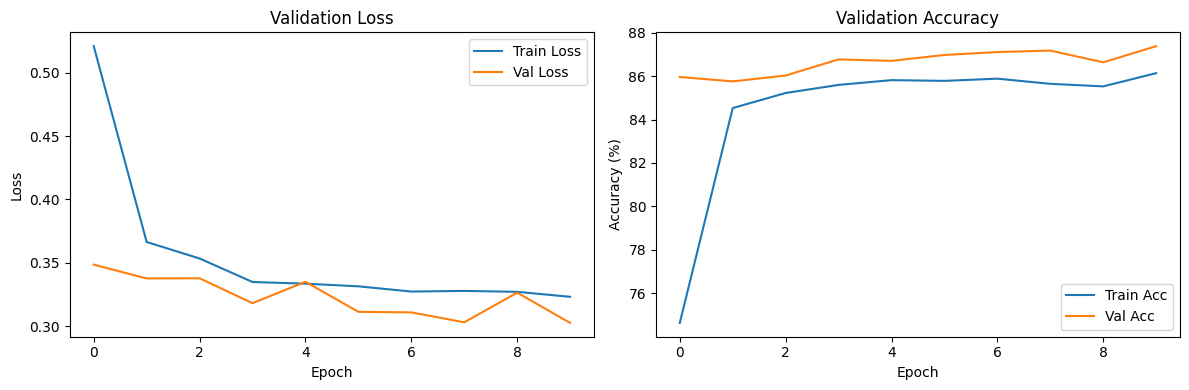

maximum accuracy:  87.37 %
high epoch:  10
Training model: large_lstm
Parameters: {'name': 'large_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.6282, Train Acc: 66.17%, Val Loss: 0.4554, Val Acc: 84.60%
Epoch [2/15], Train Loss: 0.4592, Train Acc: 80.57%, Val Loss: 0.3486, Val Acc: 86.63%
Epoch [3/15], Train Loss: 0.3961, Train Acc: 83.53%, Val Loss: 0.3402, Val Acc: 86.36%
Epoch [4/15], Train Loss: 0.3602, Train Acc: 84.75%, Val Loss: 0.3350, Val Acc: 85.55%
Epoch [5/15], Train Loss: 0.3501, Train Acc: 85.44%, Val Loss: 0.3251, Val Acc: 86.56%
Epoch [6/15], Train Loss: 0.3456, Train Acc: 85.17%, Val Loss: 0.3239, Val Acc: 86.36%
Epoch [7/15], Train Loss: 0.3406, Train Acc: 85.51%, Val Loss: 0.3236, Val Acc: 86.63%
Epoch [8/15], Train Loss: 0.3335, Train Acc: 86.28%, Val Loss: 0.3262, Val Acc: 86.97%
Epoch [9/15], Train Loss: 0.3367, Train Acc: 85.74%, Val L

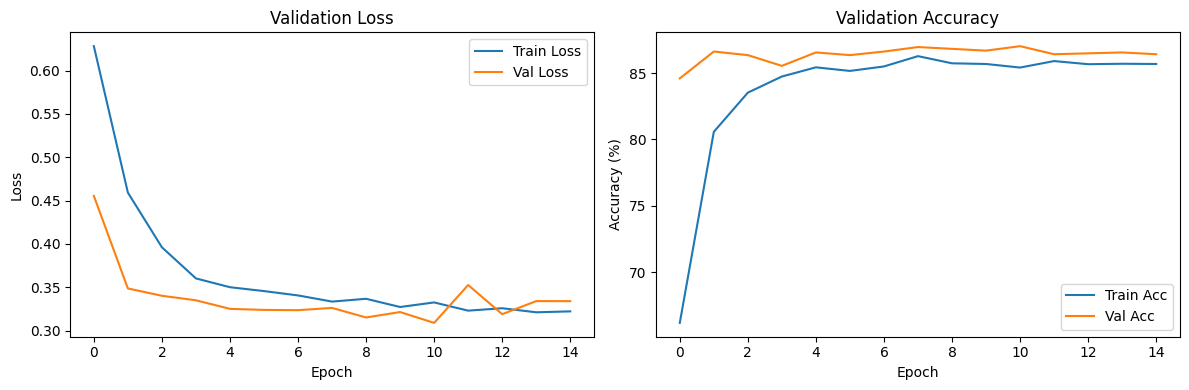

maximum accuracy:  87.04 %
high epoch:  11
Training model: small_lstm
Parameters: {'name': 'small_lstm', 'type': 'lstm', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.5268, Train Acc: 75.44%, Val Loss: 0.4399, Val Acc: 79.14%
Epoch [2/8], Train Loss: 0.3689, Train Acc: 84.58%, Val Loss: 0.3464, Val Acc: 85.89%
Epoch [3/8], Train Loss: 0.3375, Train Acc: 85.74%, Val Loss: 0.3198, Val Acc: 86.50%
Epoch [4/8], Train Loss: 0.3379, Train Acc: 85.59%, Val Loss: 0.3211, Val Acc: 85.82%
Epoch [5/8], Train Loss: 0.3297, Train Acc: 86.06%, Val Loss: 0.3179, Val Acc: 86.43%
Epoch [6/8], Train Loss: 0.3239, Train Acc: 85.91%, Val Loss: 0.3333, Val Acc: 85.62%
Epoch [7/8], Train Loss: 0.3268, Train Acc: 85.93%, Val Loss: 0.3198, Val Acc: 86.16%
Epoch [8/8], Train Loss: 0.3240, Train Acc: 86.27%, Val Loss: 0.3124, Val Acc: 86.97%


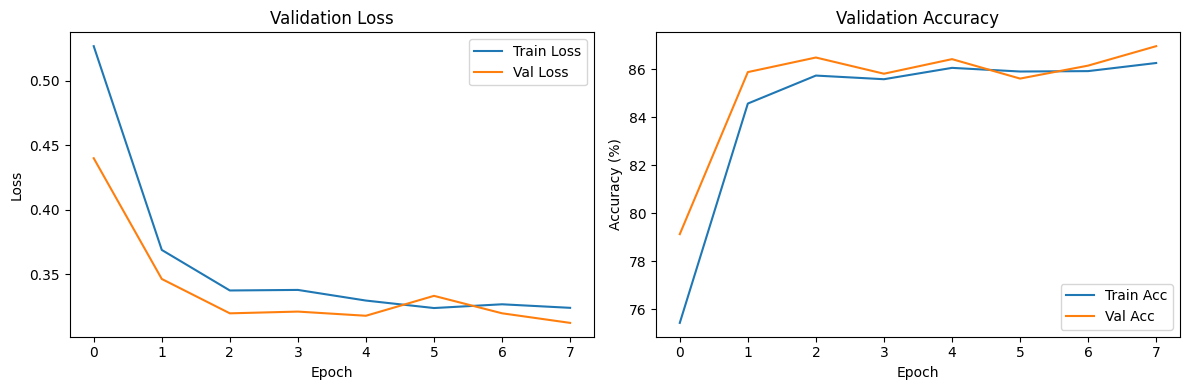

maximum accuracy:  86.97 %
high epoch:  8
Training model: deep_lstm
Parameters: {'name': 'deep_lstm', 'type': 'lstm', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6177, Train Acc: 67.15%, Val Loss: 0.4791, Val Acc: 84.94%
Epoch [2/20], Train Loss: 0.4878, Train Acc: 79.29%, Val Loss: 0.3998, Val Acc: 85.35%
Epoch [3/20], Train Loss: 0.4168, Train Acc: 82.55%, Val Loss: 0.3534, Val Acc: 86.02%
Epoch [4/20], Train Loss: 0.3909, Train Acc: 84.07%, Val Loss: 0.3470, Val Acc: 85.82%
Epoch [5/20], Train Loss: 0.3727, Train Acc: 84.44%, Val Loss: 0.3299, Val Acc: 86.29%
Epoch [6/20], Train Loss: 0.3655, Train Acc: 84.38%, Val Loss: 0.3315, Val Acc: 86.43%
Epoch [7/20], Train Loss: 0.3548, Train Acc: 85.14%, Val Loss: 0.3242, Val Acc: 86.83%
Epoch [8/20], Train Loss: 0.3472, Train Acc: 85.03%, Val Loss: 0.3184, Val Acc: 86.56%
Epoch [9/20], Train Loss: 0.3441, Train Acc: 85.35%, Val

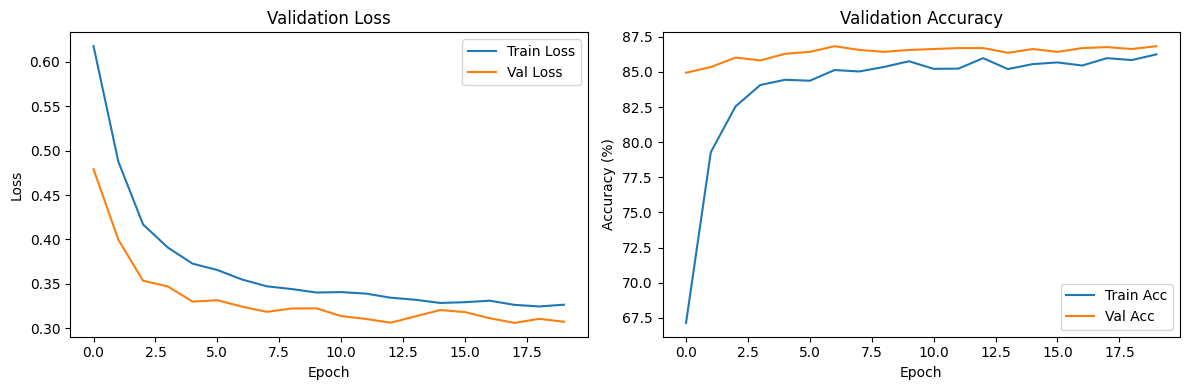

maximum accuracy:  86.83 %
high epoch:  7
Training model: fast_lstm
Parameters: {'name': 'fast_lstm', 'type': 'lstm', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.5695, Train Acc: 71.03%, Val Loss: 0.4192, Val Acc: 86.90%
Epoch [2/5], Train Loss: 0.3691, Train Acc: 84.93%, Val Loss: 0.3338, Val Acc: 86.09%
Epoch [3/5], Train Loss: 0.3445, Train Acc: 85.46%, Val Loss: 0.4326, Val Acc: 78.39%
Epoch [4/5], Train Loss: 0.3337, Train Acc: 85.90%, Val Loss: 0.3363, Val Acc: 86.56%
Epoch [5/5], Train Loss: 0.3335, Train Acc: 85.79%, Val Loss: 0.3715, Val Acc: 86.36%


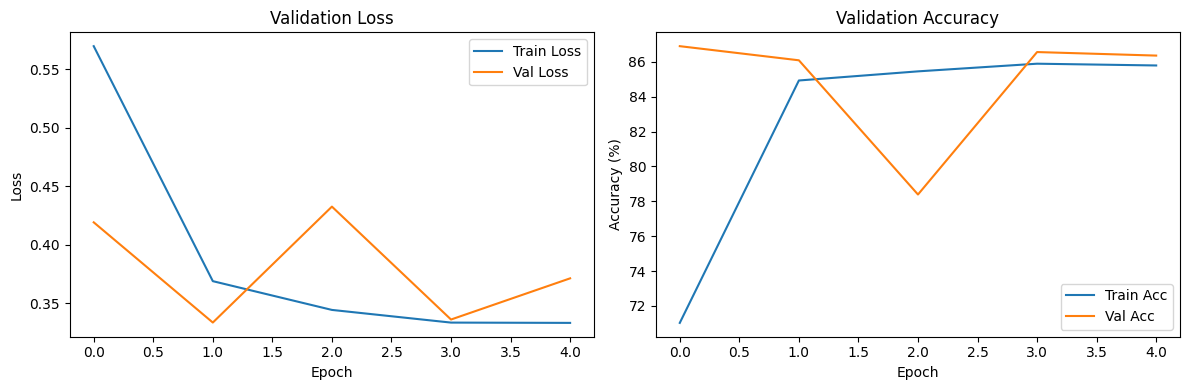

maximum accuracy:  86.9 %
high epoch:  1

Testing vectorizer: combined_base
Loading GloVe model...
Loaded 400000 word vectors
Transforming data...
Data shapes:
Train: (5920, 5100)
Val: (1481, 5100)
Test: (1851, 5100)


Training combined_base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training model: base_combined
Parameters: {'name': 'base_combined', 'type': 'combined', 'params': {'hidden_dims': [256, 128], 'dropout_rate': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 10}}
Epoch [1/10], Train Loss: 0.4272, Train Acc: 81.74%, Val Loss: 0.2815, Val Acc: 90.21%
Epoch [2/10], Train Loss: 0.1796, Train Acc: 93.87%, Val Loss: 0.2234, Val Acc: 92.17%
Epoch [3/10], Train Loss: 0.1165, Train Acc: 96.00%, Val Loss: 0.2534, Val Acc: 91.42%
Epoch [4/10], Train Loss: 0.0732, Train Acc: 97.40%, Val Loss: 0.3394, Val Acc: 88.93%
Epoch [5/10], Train Loss: 0.0634, Train Acc: 97.69%, Val Loss: 0.2839, Val Acc: 92.51%
Epoch [6/10], Train Loss: 0.0526, Train Acc: 98.01%, Val Loss: 0.3251, Val Acc: 90.61%
Epoch [7/10], Train Loss: 0.0437, Train Acc: 98.41%, Val Loss: 0.3593, Val Acc: 91.63%
Epoch [8/10], Train Loss: 0.0398, Train Acc: 98.61%, Val Loss: 0.4048, Val Acc: 90.82%
Epoch [9/10], Train Loss: 0.0425, Train Acc: 98.48%, Val Loss: 0.3384, Val Acc: 91.22%
Epoch [10

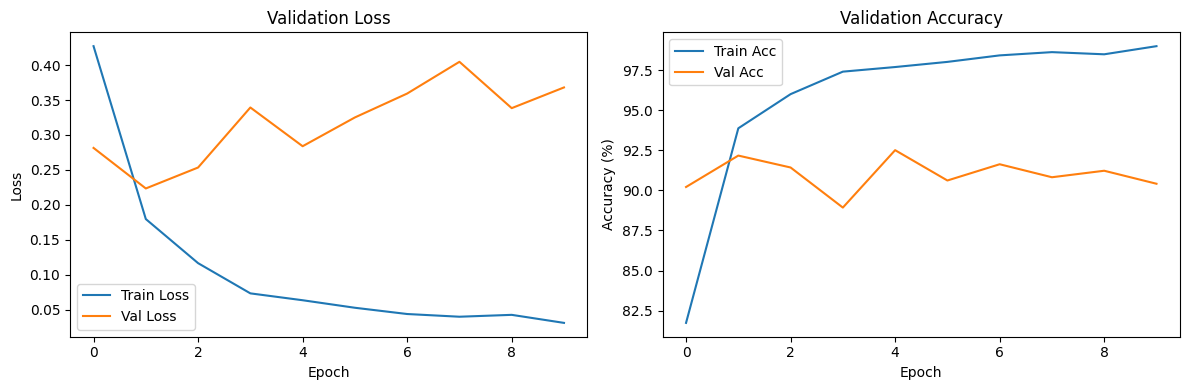

maximum accuracy:  92.51 %
high epoch:  5
Training model: large_combined
Parameters: {'name': 'large_combined', 'type': 'combined', 'params': {'hidden_dims': [512, 256, 128], 'dropout_rate': 0.5, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 15}}
Epoch [1/15], Train Loss: 0.5495, Train Acc: 74.53%, Val Loss: 0.3374, Val Acc: 89.94%
Epoch [2/15], Train Loss: 0.2745, Train Acc: 91.18%, Val Loss: 0.3356, Val Acc: 89.53%
Epoch [3/15], Train Loss: 0.1688, Train Acc: 95.00%, Val Loss: 0.2640, Val Acc: 92.57%
Epoch [4/15], Train Loss: 0.1404, Train Acc: 95.30%, Val Loss: 0.2723, Val Acc: 91.42%
Epoch [5/15], Train Loss: 0.1023, Train Acc: 96.82%, Val Loss: 0.2745, Val Acc: 92.37%
Epoch [6/15], Train Loss: 0.0809, Train Acc: 97.47%, Val Loss: 0.3282, Val Acc: 91.83%
Epoch [7/15], Train Loss: 0.0726, Train Acc: 97.50%, Val Loss: 0.3212, Val Acc: 91.83%
Epoch [8/15], Train Loss: 0.0709, Train Acc: 97.74%, Val Loss: 0.3807, Val Acc: 91.29%
Epoch [9/15], Train Loss: 0.0468, Train Acc: 98

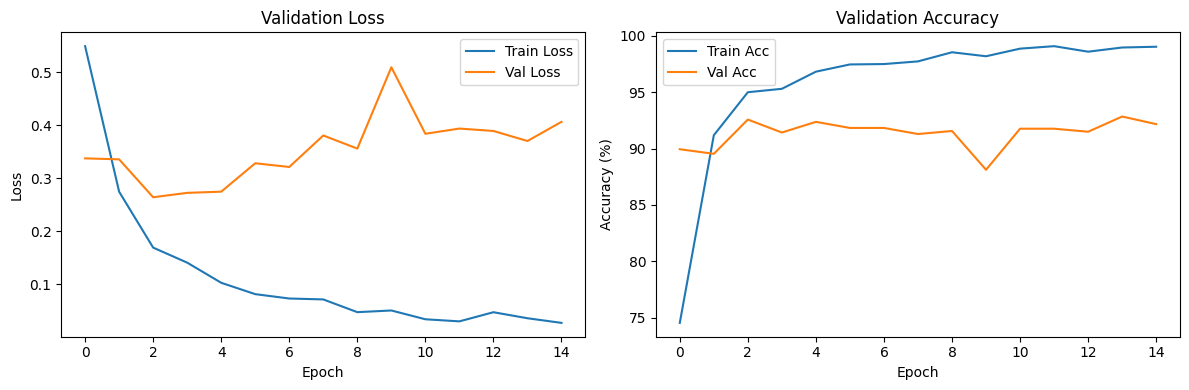

maximum accuracy:  92.84 %
high epoch:  14
Training model: small_combined
Parameters: {'name': 'small_combined', 'type': 'combined', 'params': {'hidden_dims': [128, 64], 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'num_epochs': 8}}
Epoch [1/8], Train Loss: 0.4471, Train Acc: 81.23%, Val Loss: 0.2370, Val Acc: 91.90%
Epoch [2/8], Train Loss: 0.1725, Train Acc: 94.49%, Val Loss: 0.2305, Val Acc: 91.83%
Epoch [3/8], Train Loss: 0.0915, Train Acc: 96.86%, Val Loss: 0.3029, Val Acc: 89.47%
Epoch [4/8], Train Loss: 0.0787, Train Acc: 97.16%, Val Loss: 0.4810, Val Acc: 83.79%
Epoch [5/8], Train Loss: 0.0592, Train Acc: 97.99%, Val Loss: 0.2609, Val Acc: 92.44%
Epoch [6/8], Train Loss: 0.0577, Train Acc: 97.84%, Val Loss: 0.2874, Val Acc: 91.02%
Epoch [7/8], Train Loss: 0.0393, Train Acc: 98.72%, Val Loss: 0.3291, Val Acc: 91.49%
Epoch [8/8], Train Loss: 0.0323, Train Acc: 98.83%, Val Loss: 0.4374, Val Acc: 90.68%


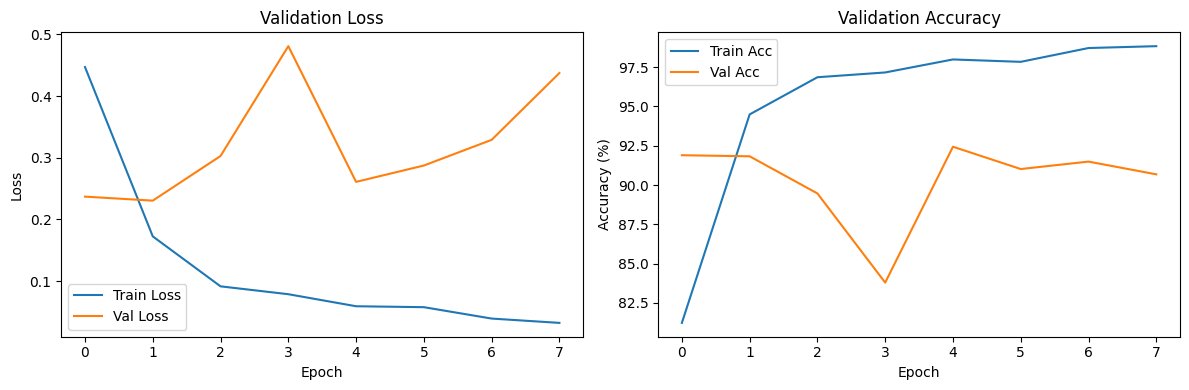

maximum accuracy:  92.44 %
high epoch:  5
Training model: deep_combined
Parameters: {'name': 'deep_combined', 'type': 'combined', 'params': {'hidden_dims': [512, 256, 128, 64], 'dropout_rate': 0.5, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 20}}
Epoch [1/20], Train Loss: 0.6518, Train Acc: 64.38%, Val Loss: 0.4211, Val Acc: 89.87%
Epoch [2/20], Train Loss: 0.4134, Train Acc: 84.66%, Val Loss: 0.3104, Val Acc: 91.90%
Epoch [3/20], Train Loss: 0.2662, Train Acc: 91.62%, Val Loss: 0.2353, Val Acc: 92.17%
Epoch [4/20], Train Loss: 0.1934, Train Acc: 93.94%, Val Loss: 0.2654, Val Acc: 90.48%
Epoch [5/20], Train Loss: 0.1623, Train Acc: 94.66%, Val Loss: 0.2329, Val Acc: 92.23%
Epoch [6/20], Train Loss: 0.1381, Train Acc: 95.81%, Val Loss: 0.2349, Val Acc: 91.76%
Epoch [7/20], Train Loss: 0.1260, Train Acc: 95.83%, Val Loss: 0.3275, Val Acc: 88.72%
Epoch [8/20], Train Loss: 0.1177, Train Acc: 96.17%, Val Loss: 0.2484, Val Acc: 91.69%
Epoch [9/20], Train Loss: 0.1064, Train Acc:

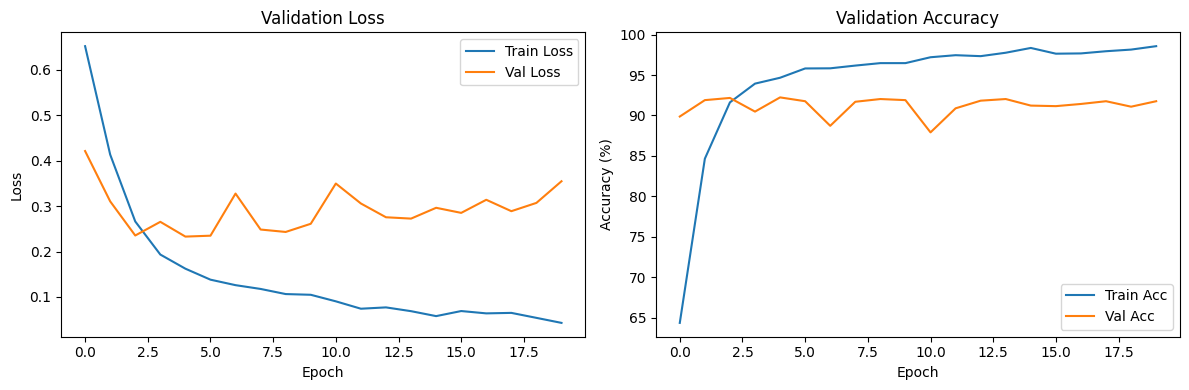

maximum accuracy:  92.23 %
high epoch:  5
Training model: fast_combined
Parameters: {'name': 'fast_combined', 'type': 'combined', 'params': {'hidden_dims': [64], 'dropout_rate': 0.2, 'learning_rate': 0.002, 'batch_size': 128, 'num_epochs': 5}}
Epoch [1/5], Train Loss: 0.4965, Train Acc: 77.64%, Val Loss: 0.3471, Val Acc: 88.93%
Epoch [2/5], Train Loss: 0.1630, Train Acc: 95.95%, Val Loss: 0.1963, Val Acc: 92.84%
Epoch [3/5], Train Loss: 0.0668, Train Acc: 98.34%, Val Loss: 1.4611, Val Acc: 49.36%
Epoch [4/5], Train Loss: 0.0376, Train Acc: 99.22%, Val Loss: 0.2434, Val Acc: 92.23%
Epoch [5/5], Train Loss: 0.0231, Train Acc: 99.53%, Val Loss: 0.3083, Val Acc: 90.82%


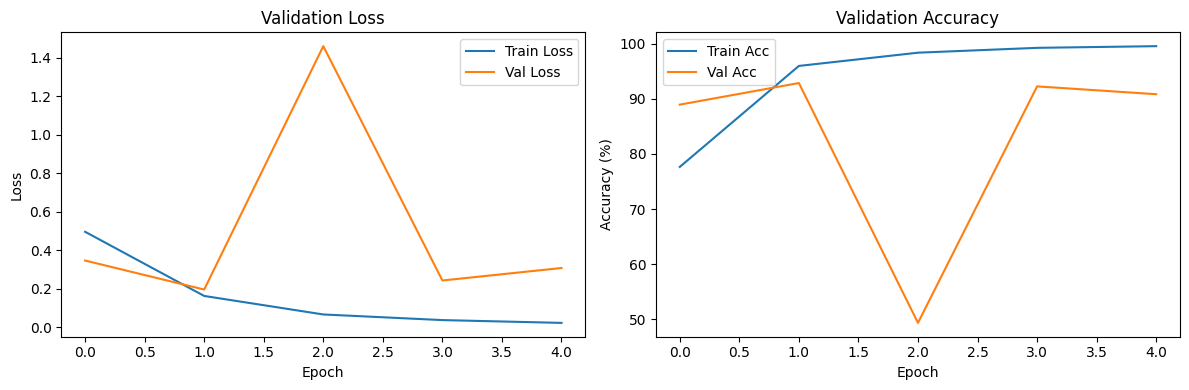

maximum accuracy:  92.84 %
high epoch:  2


In [ ]:
# Cell 6: Run experiments
# Run experiments
results_df = run_vectorization_experiments(
    train_texts, test_df['reviews'],
    train_labels, val_texts, val_labels,
    test_df
)


Best Models:
       vectorizer      model_name  val_accuracy  training_time
9      tfidf_base        fast_mlp      0.928427       2.271300
13     count_base        deep_mlp      0.925051     251.322787
12     count_base       small_mlp      0.921675      12.982930
21  combined_base  large_combined      0.921675      66.817000
14     count_base        fast_mlp      0.921675       2.107832


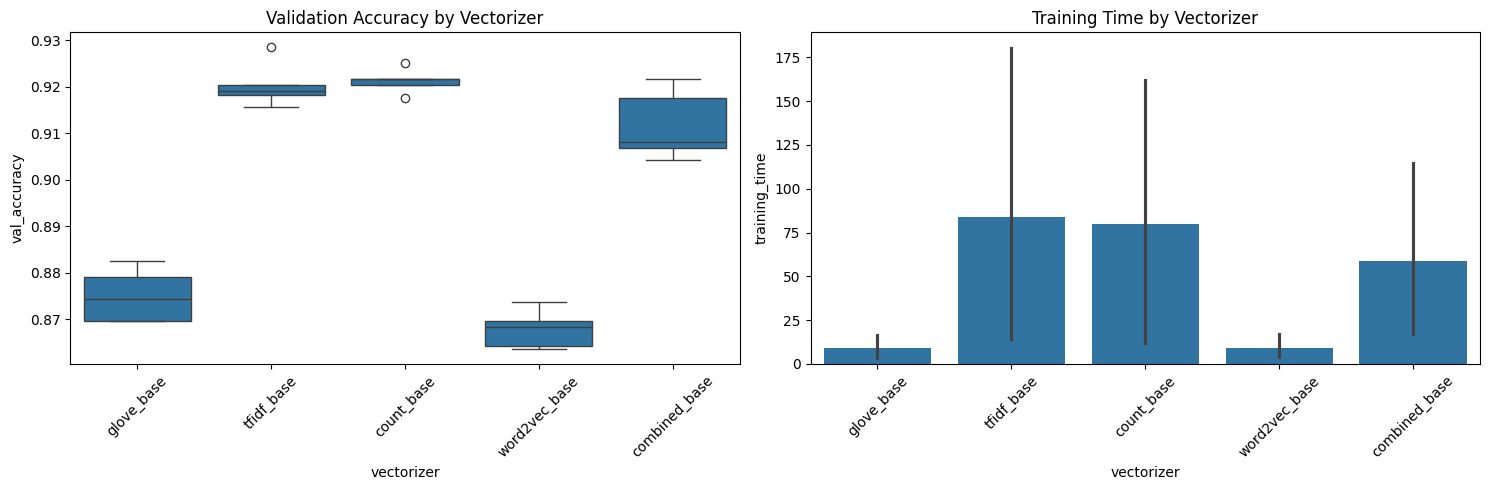

In [ ]:
# Cell 7: Save and display results
# Save results
results_df.to_csv('vectorization_comparison_results.csv', index=False)

# Print summary
print("\nBest Models:")
print(results_df.sort_values('val_accuracy', ascending=False)[
    ['vectorizer', 'model_name', 'val_accuracy', 'training_time']
].head())

# Create visualizations
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=results_df, x='vectorizer', y='val_accuracy')
plt.title('Validation Accuracy by Vectorizer')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='vectorizer', y='training_time')
plt.title('Training Time by Vectorizer')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def plot_comprehensive_results(results_df):
    """
    Create comprehensive visualizations comparing all models and vectorizers
    """
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 15))

    # 1. Model Architecture Comparison
    plt.subplot(3, 2, 1)
    model_types = ['base', 'large', 'small', 'deep', 'fast']
    sns.boxplot(data=results_df, x='model_type', y='val_accuracy',
                order=model_types)
    plt.title('Validation Accuracy by Model Architecture', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('Model Type')
    plt.ylabel('Validation Accuracy')

    # 2. Vectorizer Comparison
    plt.subplot(3, 2, 2)
    sns.boxplot(data=results_df, x='vectorizer', y='val_accuracy')
    plt.title('Validation Accuracy by Vectorizer', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('Vectorizer Type')
    plt.ylabel('Validation Accuracy')

    # 3. Training Time Comparison
    plt.subplot(3, 2, 3)
    sns.barplot(data=results_df, x='model_type', y='training_time',
                order=model_types)
    plt.title('Training Time by Model Architecture', fontsize=12)
    plt.xticks(rotation=45)
    plt.xlabel('Model Type')
    plt.ylabel('Training Time (seconds)')

    # 4. Loss Comparison
    plt.subplot(3, 2, 4)
    x = np.arange(len(model_types))
    width = 0.35
    train_losses = results_df.groupby('model_type')['final_train_loss'].mean()
    val_losses = results_df.groupby('model_type')['final_val_loss'].mean()

    plt.bar(x - width/2, train_losses[model_types], width, label='Train Loss')
    plt.bar(x + width/2, val_losses[model_types], width, label='Val Loss')
    plt.title('Average Losses by Model Type', fontsize=12)
    plt.xticks(x, model_types, rotation=45)
    plt.legend()

    # 5. Epochs vs Accuracy Scatter
    plt.subplot(3, 2, 5)
    for model_type in model_types:
        model_data = results_df[results_df['model_type'] == model_type]
        plt.scatter(model_data['num_epochs'], model_data['val_accuracy'],
                   label=model_type, alpha=0.6)
    plt.title('Validation Accuracy vs Epochs by Model Type', fontsize=12)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1))

    # 6. Model-Vectorizer Heatmap
    plt.subplot(3, 2, 6)
    pivot_table = results_df.pivot_table(
        values='val_accuracy',
        index='model_type',
        columns='vectorizer',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Model-Vectorizer Performance Heatmap', fontsize=12)

    plt.tight_layout()
    plt.show()

def print_detailed_results(results_df):
    """
    Print detailed statistical analysis of results
    """
    print("\n=== Detailed Results Analysis ===")

    # Best overall models
    print("\nTop 5 Best Performing Models:")
    top_models = results_df.nlargest(5, 'val_accuracy')
    print(top_models[['model_type', 'vectorizer', 'val_accuracy', 'training_time']].to_string())

    # Best model for each architecture
    print("\nBest Model for Each Architecture:")
    for model_type in results_df['model_type'].unique():
        best = results_df[results_df['model_type'] == model_type].nlargest(1, 'val_accuracy')
        print(f"\n{model_type.upper()}:")
        print(f"Vectorizer: {best['vectorizer'].iloc[0]}")
        print(f"Accuracy: {best['val_accuracy'].iloc[0]:.4f}")
        print(f"Training Time: {best['training_time'].iloc[0]:.2f}s")

    # Best vectorizer for each model type
    print("\nBest Vectorizer for Each Model Type:")
    pivot = results_df.pivot_table(
        values='val_accuracy',
        index='model_type',
        columns='vectorizer',
        aggfunc='mean'
    )
    print(pivot.round(4))

    # Statistical analysis
    print("\nStatistical Analysis:")

    # ANOVA test for model types
    model_groups = [group['val_accuracy'].values for name, group in results_df.groupby('model_type')]
    f_stat, p_val = stats.f_oneway(*model_groups)
    print(f"\nANOVA test for model types:")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_val:.4f}")

    # Training time analysis
    print("\nAverage Training Time by Model Type:")
    print(results_df.groupby('model_type')['training_time'].mean().round(2))

def analyze_results(results_df):
    """
    Main function to analyze and visualize results
    """
    # Preprocess results
    results_df['model_type'] = results_df['name'].apply(lambda x: x.split('_')[0])

    # Create visualizations
    plot_comprehensive_results(results_df)

    # Print detailed analysis
    print_detailed_results(results_df)

    # Save processed results
    results_df.to_csv('detailed_analysis_results.csv', index=False)

# Usage
if __name__ == "__main__":
    # Load results
    results_df = pd.read_csv('model_variation_results.csv')

    # Run analysis
    analyze_results(results_df)

In [ ]:
# Cell 2: Function to train and evaluate models
def train_and_evaluate_model(config, X_train, y_train, X_val, y_val, X_test, test_df):
    print(f"\nTraining model: {config['name']}")
    print("Parameters:", config)

    # Initialize model
    model = SentimentAnalyzer(
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['learning_rate'],
        batch_size=config['batch_size'],
        num_epochs=config['num_epochs']
    )

    # Train
    model.train(X_train, y_train, X_val, y_val)

    # Make predictions
    predictions, probabilities = model.predict(X_test)

    # Save results
    results_df = pd.DataFrame({
        'reviews': test_df['reviews'],
        'predicted_sentiment': predictions,
        'probability_0': probabilities[:, 0],
        'probability_1': probabilities[:, 1]
    })

    # Save to CSV
    filename = f"fnn_predictions_{config['name']}.csv"
    results_df.to_csv(filename, index=False)

    # Get validation performance
    val_predictions = model.predict(X_val)[0]
    val_accuracy = np.mean(val_predictions == y_val)

    return {
        'model_name': config['name'],
        'val_accuracy': val_accuracy,
        'max_val_acc': max(model.history['val_acc']),
        'final_train_loss': model.history['train_loss'][-1],
        'final_val_loss': model.history['val_loss'][-1],
        'filename': filename
    }


In [ ]:
# Cell 3: Run all experiments
results = []
for config in parameter_configs:
    result = train_and_evaluate_model(
        config,
        X_train_transformed,
        train_labels,
        X_val_transformed,
        val_labels,
        X_test_transformed,
        test_df
    )
    results.append(result)



Training model: base_model
Parameters: {'hidden_dims': [256, 128, 64], 'dropout_rate': 0.6, 'learning_rate': 0.0005, 'batch_size': 32, 'num_epochs': 10, 'name': 'base_model'}
Epoch [1/10], Train Loss: 0.6760, Train Acc: 62.89%, Val Loss: 0.4845, Val Acc: 85.48%
Epoch [2/10], Train Loss: 0.5304, Train Acc: 76.01%, Val Loss: 0.4074, Val Acc: 86.70%
Epoch [3/10], Train Loss: 0.4455, Train Acc: 81.84%, Val Loss: 0.3535, Val Acc: 87.31%
Epoch [4/10], Train Loss: 0.3975, Train Acc: 83.73%, Val Loss: 0.3223, Val Acc: 87.71%
Epoch [5/10], Train Loss: 0.3756, Train Acc: 85.07%, Val Loss: 0.3192, Val Acc: 87.91%
Epoch [6/10], Train Loss: 0.3637, Train Acc: 84.85%, Val Loss: 0.3094, Val Acc: 87.31%
Epoch [7/10], Train Loss: 0.3560, Train Acc: 85.34%, Val Loss: 0.3057, Val Acc: 87.51%
Epoch [8/10], Train Loss: 0.3496, Train Acc: 85.35%, Val Loss: 0.3050, Val Acc: 87.51%
Epoch [9/10], Train Loss: 0.3338, Train Acc: 86.39%, Val Loss: 0.3016, Val Acc: 87.31%
Epoch [10/10], Train Loss: 0.3399, Train 

In [ ]:
# Cell 4: Compare results
comparison_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison_df.round(4))


Model Comparison:
      model_name  val_accuracy  max_val_acc  final_train_loss  final_val_loss  \
0     base_model        0.8724      87.9136            0.3399          0.3024   
1   larger_model        0.8798      88.3187            0.3036          0.3031   
2  smaller_model        0.8832      88.3187            0.3238          0.2929   
3     deep_model        0.8771      88.1161            0.3579          0.3145   
4     fast_model        0.8325      88.3862            0.2831          0.4005   

                            filename  
0     fnn_predictions_base_model.csv  
1   fnn_predictions_larger_model.csv  
2  fnn_predictions_smaller_model.csv  
3     fnn_predictions_deep_model.csv  
4     fnn_predictions_fast_model.csv  


In [ ]:
# Cell 6: Analyze prediction distributions
def analyze_predictions(filename, model_name):
    df = pd.read_csv(filename)
    pos_conf = df[df['predicted_sentiment'] == 1]['probability_1'].mean()
    neg_conf = df[df['predicted_sentiment'] == 0]['probability_0'].mean()
    pos_ratio = (df['predicted_sentiment'] == 1).mean()

    return {
        'model': model_name,
        'positive_ratio': pos_ratio,
        'avg_positive_confidence': pos_conf,
        'avg_negative_confidence': neg_conf
    }

prediction_stats = []
for result in results:
    stats = analyze_predictions(result['filename'], result['model_name'])
    prediction_stats.append(stats)

prediction_comparison = pd.DataFrame(prediction_stats)
print("\nPrediction Statistics:")
print(prediction_comparison.round(4))


Prediction Statistics:
           model  positive_ratio  avg_positive_confidence  \
0     base_model          0.9741                   0.8817   
1   larger_model          0.9471                   0.9044   
2  smaller_model          0.9276                   0.8776   
3     deep_model          0.9660                   0.8467   
4     fast_model          0.7942                   0.8354   

   avg_negative_confidence  
0                   0.6305  
1                   0.6411  
2                   0.6990  
3                   0.6104  
4                   0.7119  


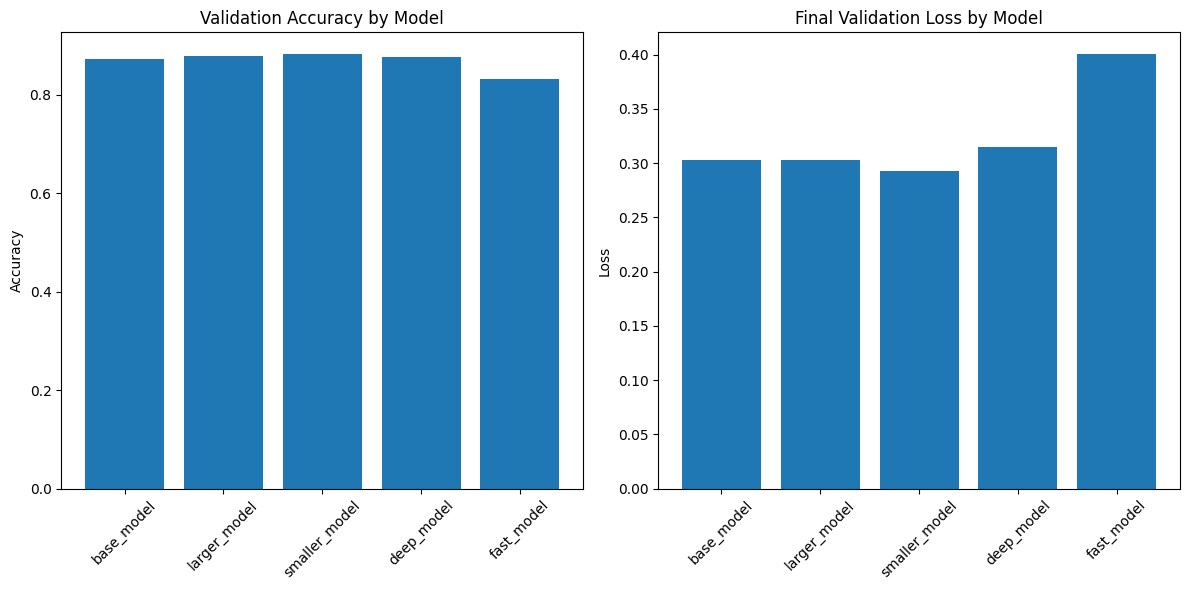

In [ ]:

# Cell 5: Add visualization of training curves
def plot_training_curves(results):
    plt.figure(figsize=(15, 10))

    # Plot accuracy comparison
    plt.subplot(2, 2, 1)
    accuracies = [r['val_accuracy'] for r in results]
    names = [r['model_name'] for r in results]
    plt.bar(names, accuracies)
    plt.title('Validation Accuracy by Model')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')

    # Plot loss comparison
    plt.subplot(2, 2, 2)
    train_losses = [r['final_train_loss'] for r in results]
    val_losses = [r['final_val_loss'] for r in results]
    x = np.arange(len(names))
    width = 0.35
    plt.bar(x - width/2, train_losses, width, label='Train Loss')
    plt.bar(x + width/2, val_losses, width, label='Val Loss')
    plt.title('Final Losses by Model')
    plt.xticks(x, names, rotation=45)
    plt.legend()

    # Plot max validation accuracy vs epochs
    plt.subplot(2, 2, 3)
    epochs = [r['num_epochs'] for r in results]
    max_accs = [r['max_val_acc'] for r in results]
    plt.scatter(epochs, max_accs)
    plt.title('Max Validation Accuracy vs Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Max Validation Accuracy')

    # Plot learning rate vs accuracy
    plt.subplot(2, 2, 4)
    lrs = [r['learning_rate'] for r in results]
    plt.scatter(lrs, accuracies)
    plt.xscale('log')
    plt.title('Validation Accuracy vs Learning Rate')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Add to your results comparison:
print("\nSorted by validation accuracy:")
comparison_df.sort_values('val_accuracy', ascending=False).round(4)

# Call the visualization
plot_training_curves(results)
```

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

class BERTSentimentDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx]) if isinstance(self.texts, pd.Series) else str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx])

        return item

class BERTSentimentClassifier(nn.Module):
    def __init__(self, n_classes=2, dropout_rate=0.3):
        super(BERTSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

class BERTSentimentAnalyzer:
    def __init__(self,
                 max_length=64,
                 batch_size=32,
                 epochs=2,
                 learning_rate=2e-5,
                 dropout_rate=0.3,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.max_length = max_length
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.device = device
        self.model = BERTSentimentClassifier(dropout_rate=dropout_rate).to(device)
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'epoch_times': []
        }

    def create_data_loaders(self, texts, labels=None):
        dataset = BERTSentimentDataset(
            texts=texts,
            labels=labels,
            tokenizer=self.tokenizer,
            max_length=self.max_length
        )
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=labels is not None)

    def train_epoch(self, data_loader, optimizer, scheduler):
        self.model.train()
        total_loss = 0
        predictions = []
        actual_labels = []

        for batch in tqdm(data_loader, desc="Training", leave=False):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(data_loader)
        accuracy = accuracy_score(actual_labels, predictions)

        return avg_loss, accuracy

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0
        predictions = []
        actual_labels = []

        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                loss = nn.CrossEntropyLoss()(outputs, labels)

                total_loss += loss.item()
                _, preds = torch.max(outputs, dim=1)
                predictions.extend(preds.cpu().numpy())
                actual_labels.extend(labels.cpu().numpy())

        return (
            total_loss / len(data_loader),
            accuracy_score(actual_labels, predictions),
            predictions,
            actual_labels
        )

    def train(self, train_texts, train_labels, val_texts=None, val_labels=None):
        print(f"Using device: {self.device}")
        train_dataloader = self.create_data_loaders(train_texts, train_labels)
        if val_texts is not None and val_labels is not None:
            val_dataloader = self.create_data_loaders(val_texts, val_labels)

        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate, no_deprecation_warning=True)
        total_steps = len(train_dataloader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )

        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'\nEpoch {epoch + 1}/{self.epochs}')
            epoch_start = time.time()

            train_loss, train_acc = self.train_epoch(train_dataloader, optimizer, scheduler)
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)

            epoch_time = time.time() - epoch_start
            self.history['epoch_times'].append(epoch_time)

            print(f'Training Loss: {train_loss:.4f}')
            print(f'Training Accuracy: {train_acc:.4f}')

            if val_dataloader is not None:
                val_loss, val_acc, _, _ = self.evaluate(val_dataloader)
                self.history['val_loss'].append(val_loss)
                self.history['val_acc'].append(val_acc)
                print(f'Validation Loss: {val_loss:.4f}')
                print(f'Validation Accuracy: {val_acc:.4f}')

                if val_acc > best_accuracy:
                    best_accuracy = val_acc
                    torch.save(self.model.state_dict(), 'best_bert_model.pt')

            print(f'Epoch completed in {epoch_time:.2f} seconds')

    def predict(self, texts):
        test_dataloader = self.create_data_loaders(texts)
        self.model.eval()
        predictions = []
        probabilities = []

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids, attention_mask)
                probs = torch.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, dim=1)

                predictions.extend(preds.cpu().numpy())
                probabilities.extend(probs.cpu().numpy())

        return np.array(predictions), np.array(probabilities)

    def plot_training_history(self):
        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(self.history['train_loss'], label='Train Loss')
        if self.history['val_loss']:
            plt.plot(self.history['val_loss'], label='Val Loss')
        plt.title('Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy plot
        plt.subplot(1, 3, 2)
        plt.plot(self.history['train_acc'], label='Train Accuracy')
        if self.history['val_acc']:
            plt.plot(self.history['val_acc'], label='Val Accuracy')
        plt.title('Accuracy Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Time plot
        plt.subplot(1, 3, 3)
        plt.plot(self.history['epoch_times'])
        plt.title('Training Time per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Time (seconds)')

        plt.tight_layout()
        plt.show()

def prepare_and_train_bert():
    # Load data
    try:
        train_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/train.json')
        test_df = pd.read_json('/content/drive/My Drive/AI DM PROJECT/test.json')
        print("Data loaded successfully")

        # Create train/val split
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            train_df['reviews'],
            train_df['sentiments'],
            test_size=0.2,
            random_state=42
        )

        # Initialize and train BERT
        bert_analyzer = BERTSentimentAnalyzer(
            max_length=64,
            batch_size=32,
            epochs=2,
            learning_rate=2e-5,
            dropout_rate=0.3
        )

        print("\nStarting training...")
        bert_analyzer.train(train_texts, train_labels, val_texts, val_labels)

        # Make predictions
        print("\nMaking predictions on test set...")
        predictions, probabilities = bert_analyzer.predict(test_df['reviews'])

        # Create submission
        submission_df = pd.DataFrame({
            'reviews': test_df['reviews'],
            'predicted_sentiment': predictions,
            'negative_prob': probabilities[:, 0],
            'positive_prob': probabilities[:, 1]
        })

        # Save results
        submission_df.to_csv('bert_predictions.csv', index=False)
        print("\nPredictions saved to 'bert_predictions.csv'")

        # Plot training history
        bert_analyzer.plot_training_history()

        return bert_analyzer, submission_df

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None, None

if __name__ == "__main__":
    bert_analyzer, submission_df = prepare_and_train_bert()

Data loaded successfully

Starting training...
Using device: cpu

Epoch 1/2


KeyboardInterrupt: 

In [ ]:
# Cell 5: Model Comparison
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(fnn_results, bert_results):
    # Prediction distribution comparison
    plt.figure(figsize=(15, 5))

    # FNN distribution
    plt.subplot(1, 2, 1)
    sns.countplot(data=fnn_results, x='predicted_sentiment')
    plt.title('FNN Predictions Distribution')

    # BERT distribution
    plt.subplot(1, 2, 2)
    sns.countplot(data=bert_results, x='predicted_sentiment')
    plt.title('BERT Predictions Distribution')

    plt.tight_layout()
    plt.show()

    # Model agreement analysis
    agreements = fnn_results['predicted_sentiment'] == bert_results['predicted_sentiment']
    agreement_rate = agreements.mean() * 100

    print(f"Model Agreement Rate: {agreement_rate:.2f}%")

    # Analyze disagreements
    disagreements = pd.DataFrame({
        'review': fnn_results[~agreements]['reviews'],
        'fnn_pred': fnn_results[~agreements]['predicted_sentiment'],
        'bert_pred': bert_results[~agreements]['predicted_sentiment'],
        'fnn_conf': np.maximum(fnn_results[~agreements]['probability_0'],
                             fnn_results[~agreements]['probability_1']),
        'bert_conf': np.maximum(bert_results[~agreements]['negative_prob'],
                              bert_results[~agreements]['positive_prob'])
    })

    print(f"\nNumber of disagreements: {len(disagreements)}")
    print("\nSample disagreements:")
    print(disagreements.head())

    return disagreements

# Compare models
disagreements = compare_models(fnn_results, bert_results)

# Save comparison results
disagreements.to_csv('model_disagreements.csv', index=False)
print("\nDisagreement analysis saved to 'model_disagreements.csv'")

## Step 6: Predict on Test Data

In [ ]:
test_path = '/content/drive/My Drive/AI DM PROJECT/test.json'
if os.path.exists(test_path):
  print("Test file founded")
  df = pd.read_json(test_path)
  print(f"Data shape: {df.shape}")
  print("\nFirst few rows:")
  print(df.head(2))
  test_df = df
else:
  print("File not founded")

Test file founded
Data shape: (1851, 1)

First few rows:
                                             reviews
0  I bought 2 sleepers.  sleeper had holes in the...
1  I dare say these are just about the sexiest th...


Clean test data

In [ ]:
if test_df is not None:
    print("Data Info:")
    print(test_df.info())

    print("\nMissing Values:")
    print(test_df.isnull().sum())

cleaner = TextCleaner()

if 'test_df' in locals():
    print("\nProcessing training data:")
    test_df['cleaned_reviews'] = cleaner.process_reviews(test_df['reviews'])


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1851 entries, 0 to 1850
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1851 non-null   object
dtypes: object(1)
memory usage: 14.6+ KB
None

Missing Values:
reviews    0
dtype: int64

Processing training data:

Original: I bought 2 sleepers.  sleeper had holes in the arm pit area and the other sleeper had a whole where ...
Cleaned:  bought 2 sleeper sleeper hole in arm pit area sleeper whole neck trim should sewed real waste money...

Original: I dare say these are just about the sexiest things I've ever worn. Oh I've had and have G-strings, h...
Cleaned:  dare say sexiest thing ever worn oh g-string pretty skimpy one too but crotchless g-string masquradi...

Original: everything about the transaction (price, delivery time, quality of item) was great.  I wouldn't hesi...
Cleaned:  everything transaction price delivery time quality item great would not he

In [ ]:
# Make predictions on test data
X_test_transformed = vectorizer.transform(test_df['cleaned_reviews'])
predictions, probabilities = analyzer.predict(X_test_transformed)

# Save predictions and probabilities to submission file
submission_df = pd.DataFrame({
    'reviews': test_df['reviews'],
    'cleaned_reviews': test_df['cleaned_reviews'],
    'sentiments': predictions,
    'probability_0': [prob[0] for prob in probabilities],  # Probability for class 0 (negative)
    'probability_1': [prob[1] for prob in probabilities]   # Probability for class 1 (positive)
})

# Save the submission DataFrame to CSV
submission_df.to_csv('submission.csv', index=False)

# Separate the predictions into two DataFrames based on sentiment value
good_reviews_df = submission_df[submission_df['sentiments'] == 1]
bad_reviews_df = submission_df[submission_df['sentiments'] == 0]

good_reviews_df = good_reviews_df.sort_values(by='probability_1', ascending=True)
bad_reviews_df = bad_reviews_df.sort_values(by='probability_0', ascending=True)

# Save each DataFrame to a separate CSV file
good_reviews_df.to_csv('good_reviews.csv', index=False)
bad_reviews_df.to_csv('bad_reviews.csv', index=False)

# Display the first 10 rows of the submission DataFrame
print(submission_df.head(10))

                                             reviews  \
0  I bought 2 sleepers.  sleeper had holes in the...   
1  I dare say these are just about the sexiest th...   
2  everything about the transaction (price, deliv...   
3  Not bad for just a shirt.  Very durable, and m...   
4  These are truly wrinkle free and longer than t...   
5  I love naughty monkey! I'm so happy with their...   
6  I fell in love with this boot when I first saw...   
7  These shades are a great buy.  Fast shipping, ...   
8  There was no picture of this selection, so I g...   
9  This leather briefcase was exactly what I was ...   

                                     cleaned_reviews  sentiments  \
0  bought 2 sleeper sleeper hole in arm pit area ...           0   
1  dare say sexiest thing ever worn oh g-string p...           1   
2  everything transaction price delivery time qua...           1   
3  not bad shirt very durable matched team color ...           1   
4  truly wrinkle free longer average woman 

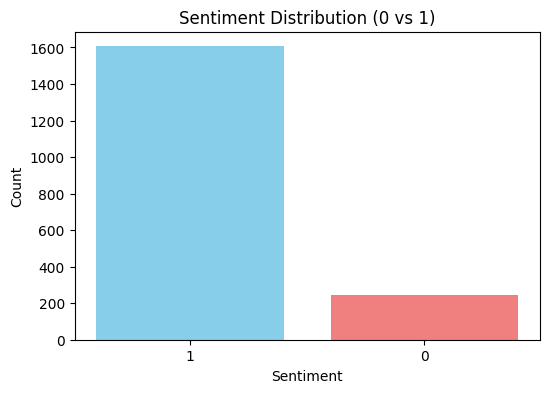

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sentiment_counts = pd.Series(predictions).value_counts()

plt.bar(sentiment_counts.index.astype(str), sentiment_counts.values, color=['skyblue', 'lightcoral'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution (0 vs 1)')
plt.xticks(sentiment_counts.index.astype(str))  # Ensure x-axis labels are integers (0 and 1)
plt.show()